# Initialize data

In [1]:
cd /data/a/cpac/isultan/projects/halomassloss/core_catalog_mevolved

/data/a/cpac/isultan/projects/halomassloss/core_catalog_mevolved


In [2]:
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import subhalo_mass_loss_model_ALCC as SHMLM_HM
import subhalo_mass_loss_model_LJDS as SHMLM_SV
import subhalo_mass_loss_model as SHMLM_AQ
import subhalo_mass_loss_model_LastJourney as SHMLM_LJ
import genericio as gio
from tqdm import tqdm
from itk import hist, h5_read_dict, h5_read_files, gio_read_dict, loadpickle, plt_latex, periodic_bcs, many_to_one, reldif, nratioerr, real_fof_tags, SIMPARAMS, duplicate_rows, inrange, combine_dicts, grep_dict, replace_elems
from scipy import spatial #KD Tree for subhalo-core matching
import itertools as it
from scipy.optimize import root #Fig1
from scipy.interpolate import interp1d #Fig1

In [3]:
assert SHMLM_HM.PARTICLES100MASS/100. * 2000 < 10**12
assert SHMLM_SV.PARTICLES100MASS/100. * 70 < 10**12

In [4]:
AFID, ZETAFID = 1.1, 0.1
A_arr = np.array([0.4, 0.5, 0.6 , 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4])
zeta_arr = np.array([0.001, 0.005, 0.01, 0.02, 0.04, 0.07, 0.08, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3])

In [5]:
PARTICLEMASS = {k:v['PARTICLEMASS'] for k,v in SIMPARAMS.items()}
OBJECTMASSCUT = {'HM':SHMLM_HM.PARTICLES100MASS, 'SV':SHMLM_SV.PARTICLES100MASS, 'AQ':SHMLM_AQ.PARTICLES100MASS, 'LJ':SHMLM_LJ.PARTICLES100MASS, 'AlphaQ':SHMLM_AQ.PARTICLES100MASS}
SUBHALOMINMASS = { 'HM':20.*SHMLM_HM.PARTICLES100MASS/100., 'SV':20.*SHMLM_SV.PARTICLES100MASS/100., 'AQ':20.*SHMLM_AQ.PARTICLES100MASS/100., 'AlphaQ':20.*SHMLM_AQ.PARTICLES100MASS/100. }
SUBHALOMINCOUNT = { 'HM':20, 'SV':20 }

In [6]:
exec(open('paper2plotscripts.py').read())

In [7]:
# HM, SV, AQ read-in
%time (cc_HM0, sh_HM0, centrals_mask_HM0), (cc_SV0, sh_SV0, centrals_mask_SV0),(cc_AQ0, sh_AQ0, centrals_mask_AQ0) = load_data(499)
%time (cc_HM1, sh_HM1, centrals_mask_HM1), (cc_SV1, sh_SV1, centrals_mask_SV1),(cc_AQ1, sh_AQ1, centrals_mask_AQ1) = load_data(247)

CPU times: user 6min 47s, sys: 1min 37s, total: 8min 25s
Wall time: 4min 1s
CPU times: user 11min 8s, sys: 2min 6s, total: 13min 15s
Wall time: 17min 3s


In [7]:
# Last Journey read-in
%time cc_LJ0, centrals_mask_LJ0 = load_cc_LastJourney(499)
%time cc_LJ1, centrals_mask_LJ1 = load_cc_LastJourney(247)

Assert 1: Elements of x0arr are unique.
CPU times: user 2min 40s, sys: 2min 22s, total: 5min 2s
Wall time: 7min 37s
Assert 1: Elements of x0arr are unique.
CPU times: user 1min 45s, sys: 1min 47s, total: 3min 33s
Wall time: 5min 33s


In [9]:
plt.style.reload_library()
plt.style.use(['science', 'high-vis'])
COLOR_SCHEME = ['#2402ba','#b400e0','#98c1d9','#ff0000','#292800','#ff9b71']

# z=0

## resolution tests

HM nH cores 39505
Mavg (cores centrals): 1.6998947e+12
HM nH_sh 39505
HM number of subhalos in bin 541343
Mavg (sh centrals): 1.6998932043768762e+12
8.545516267481092e-05 percent relative difference between Mavg_cores and Mavh_sh



/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in subtract


SV nH cores 40628
Mavg (cores centrals): 1.7033924e+12
SV nH_sh 40628
SV number of subhalos in bin 35236
Mavg (sh centrals): 1.7033923415564163e+12
6.0385137425623816e-06 percent relative difference between Mavg_cores and Mavh_sh

SV lim: -1.134210603304881


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


HM nH cores 4738
Mavg (cores centrals): 1.6894287e+13
HM nH_sh 4738
HM number of subhalos in bin 563608
Mavg (sh centrals): 1.6894267260209486e+13
0.00011928914218697282 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 4797
Mavg (cores centrals): 1.6754464e+13
SV nH_sh 4797
SV number of subhalos in bin 36337
Mavg (sh centrals): 1.6754462182588432e+13
1.0835104405187458e-05 percent relative difference between Mavg_cores and Mavh_sh

SV lim: -2.1270264045403824
HM nH cores 348
Mavg (cores centrals): 1.6276131e+14
HM nH_sh 348
HM number of subhalos in bin 376015
Mavg (sh centrals): 1.6276116409286797e+14
8.896738262100419e-05 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 337
Mavg (cores centrals): 1.6433545e+14
SV nH_sh 337
SV number of subhalos in bin 21791
Mavg (sh centrals): 1.6433543829330672e+14
5.885759698002493e-06 percent relative difference between Mavg_cores and Mavh_sh

SV lim: -3.118627140414612
ax1 YLIM (-2.3, 3.8)


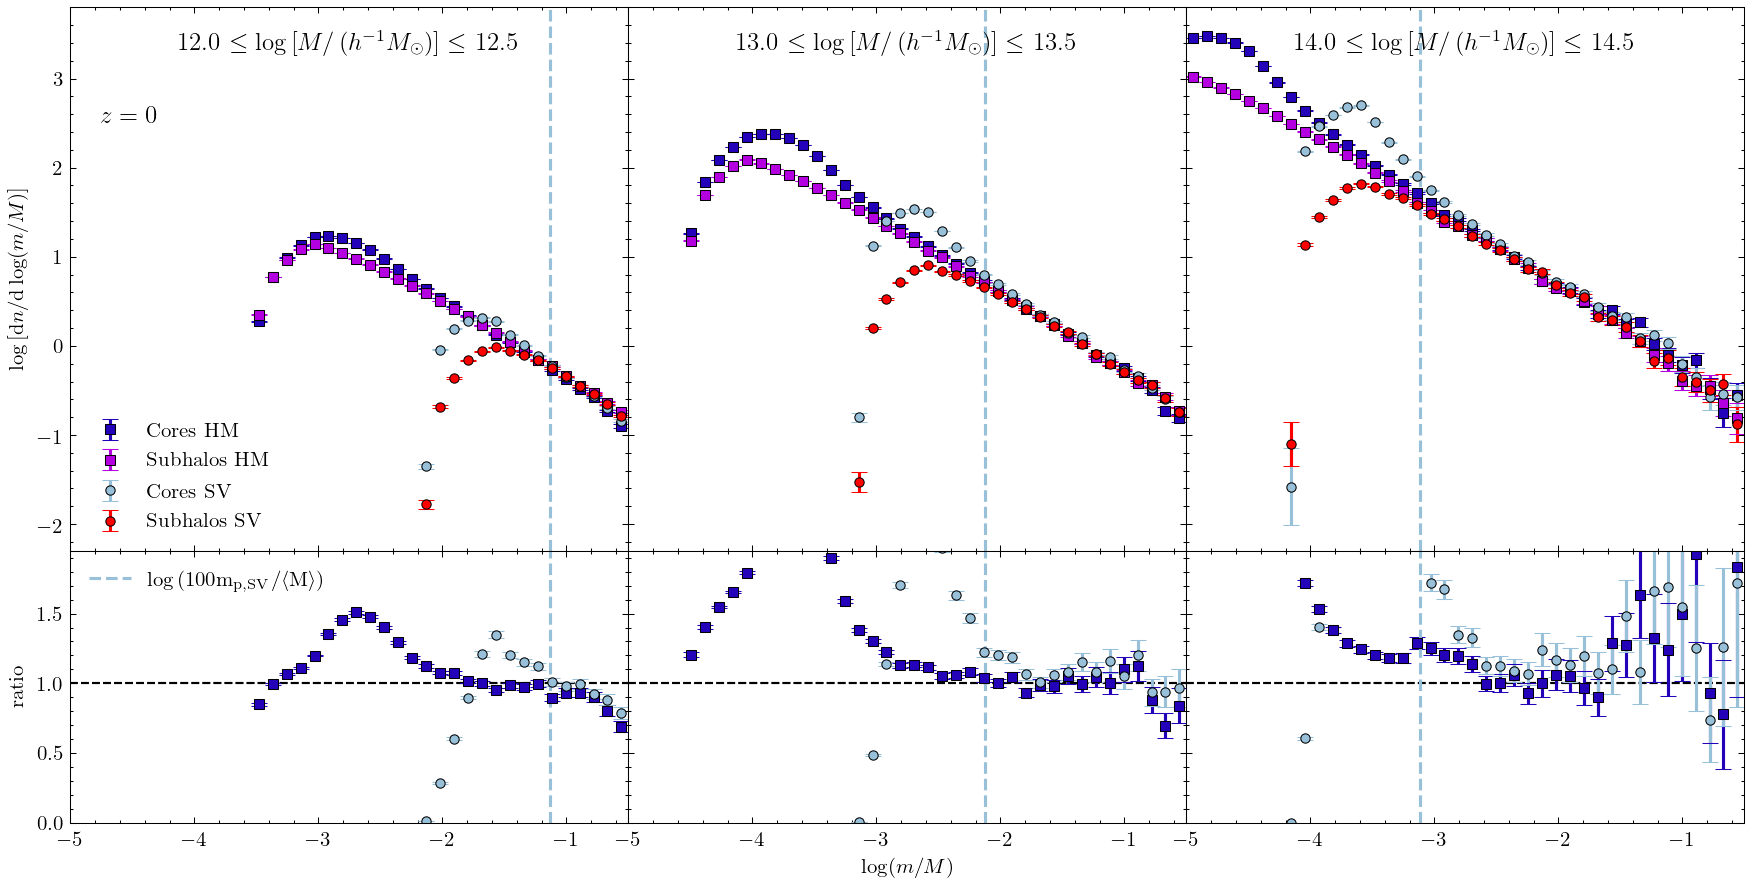

In [92]:
resolution_tests(cc_HM0, sh_HM0, centrals_mask_HM0, cc_SV0, sh_SV0, centrals_mask_SV0, zlabel='$z=0$', smallRatioYaxis=True)
# plt.savefig('Paper2Figs/resolution_test_z0_mcut_vl.pdf')
# plt.savefig('Paper2Figs/resolution_test_z0_mcut_vl_zlabel.pdf')
# plt.savefig('Paper2Figs/resolution_test_z0_mcut_vl_zlabel_smallratioy.pdf')

## cosmology tests

SV nH cores 40628

AlphaQ nH cores 37182

(-0.10926794470638777, 2.2946264515107555)


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:231: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:235: RuntimeWarning: invalid value encountered in subtract


SV nH cores 4797

AlphaQ nH cores 4335

(0.3358483644459653, 1.8949208255694536)
SV nH cores 337

AlphaQ nH cores 286

(-0.13404866021958137, 2.815021864611208)
(11.03178825378418, 14.065314865112304)


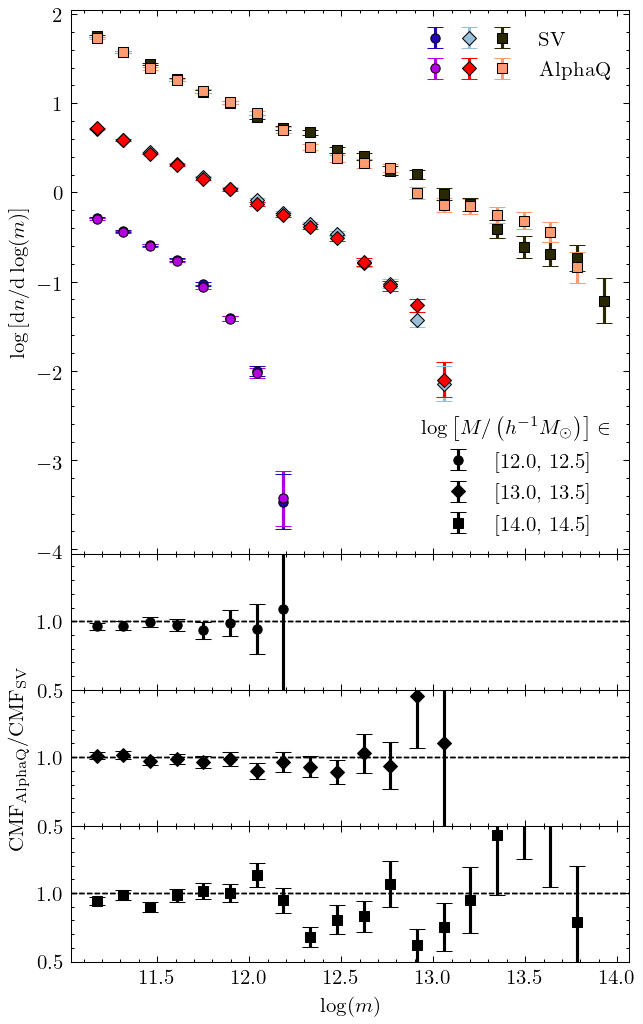

In [327]:
cosmology_tests(cc_SV0, centrals_mask_SV0, cc_AQ0, centrals_mask_AQ0, r=(np.log10(OBJECTMASSCUT['SV']),14), mlim=OBJECTMASSCUT['SV'], mplot=True, newlegend=True)
# plt.savefig('Paper2Figs/cosmology_test_z0_xaxism.pdf')

# z=1

## resolution tests

HM nH cores 33020
Mavg (cores centrals): 1.6786361e+12
HM nH_sh 33020
HM number of subhalos in bin 560634
Mavg (sh centrals): 1.6786352066843247e+12
5.258196895420167e-05 percent relative difference between Mavg_cores and Mavh_sh



/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in subtract


SV nH cores 34592
Mavg (cores centrals): 1.6771427e+12
SV nH_sh 34592
SV number of subhalos in bin 39698
Mavg (sh centrals): 1.6771425055584014e+12
8.909057607314903e-06 percent relative difference between Mavg_cores and Mavh_sh

SV lim: -1.1274658788317269


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


HM nH cores 2368
Mavg (cores centrals): 1.6394571e+13
HM nH_sh 2368
HM number of subhalos in bin 315103
Mavg (sh centrals): 1.6394565508174967e+13
3.163536240247361e-05 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 2418
Mavg (cores centrals): 1.6287099e+13
SV nH_sh 2418
SV number of subhalos in bin 21618
Mavg (sh centrals): 1.6287098271249545e+13
4.441788383436948e-06 percent relative difference between Mavg_cores and Mavh_sh

SV lim: -2.1147396297569663
HM nH cores 21
Mavg (cores centrals): 1.6244637e+14
HM nH_sh 21
HM number of subhalos in bin 23437
Mavg (sh centrals): 1.6244634413126762e+14
1.4076807260760282e-05 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 36
Mavg (cores centrals): 1.4413435e+14
SV nH_sh 36
SV number of subhalos in bin 2229
Mavg (sh centrals): 1.4413436048894266e+14
4.153978801650928e-06 percent relative difference between Mavg_cores and Mavh_sh

SV lim: -3.0616634384951404
ax1 YLIM (-2.3, 3.8)


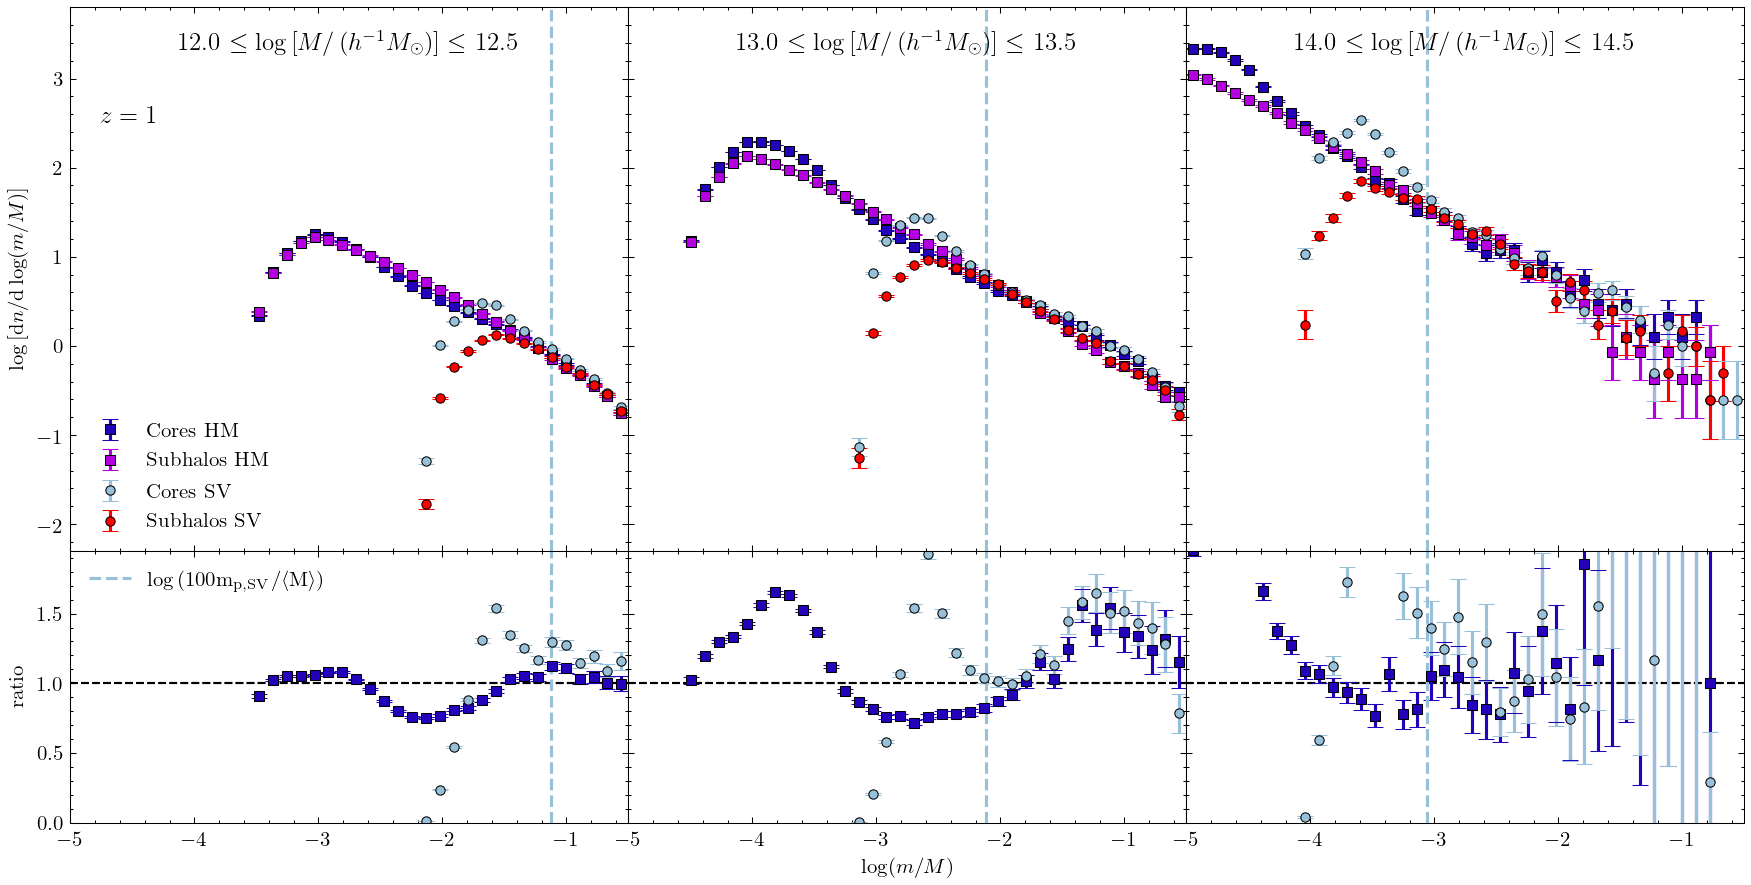

In [93]:
resolution_tests(cc_HM1, sh_HM1, centrals_mask_HM1, cc_SV1, sh_SV1, centrals_mask_SV1, zlabel='$z=1$', smallRatioYaxis=True)
# plt.savefig('Paper2Figs/resolution_test_z1_mcut_vl.pdf')
# plt.savefig('Paper2Figs/resolution_test_z1_mcut_vl_zlabel.pdf')
# plt.savefig('Paper2Figs/resolution_test_z1_mcut_vl_zlabel_smallratioy.pdf')

# Subhalo:Core matching

In [274]:
for logM1 in (12, 13, 14):
    M1, M2 = 10**logM1, 10**(logM1+0.5)
    _, _, matched_mask_cores, matched_mask_sh = subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499)
    _, _, matched_mask_cores_s1, matched_mask_sh_s1 = subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499, s1=True)
    _, _, matched_mask_cores_mmc, matched_mask_sh_mmc = subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499, mostMassiveCore=True)
    
    assert len(matched_mask_sh)==len(np.unique(matched_mask_sh))
    assert len(matched_mask_sh_s1)==len(np.unique(matched_mask_sh_s1))
    assert len(matched_mask_sh_mmc)==len(np.unique(matched_mask_sh_mmc))
    print('len matched_mask_sh_mmc', len(matched_mask_sh_mmc))
    
    print('ALL CORES UNIQUE', len(np.unique(matched_mask_cores))/len(matched_mask_cores)*100)
    print('S1  CORES UNIQUE', len(np.unique(matched_mask_cores_s1))/len(matched_mask_cores_s1)*100)
    print('MMC  CORES UNIQUE', len(np.unique(matched_mask_cores_mmc))/len(matched_mask_cores_mmc)*100)
    
    print('% OF SUBHALOS (ALL CORES) FOUND IN SUBHALOS (S1 CORES)', len(np.intersect1d(matched_mask_sh, matched_mask_sh_s1))/len(matched_mask_sh)*100)
    
#     assert np.isin(matched_mask_cores, matched_mask_cores_s1).all()
    print()

nH_cores: 40628, nH_sh: 40628
68.57429718875501% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 16.542421015264466% have mutliple cores and 83.45757898473553% have no core.
nH_cores: 40628, nH_sh: 40628
69.12092815707274% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 14.848265895953757% have mutliple cores and 85.15173410404624% have no core.
nH_cores: 40628, nH_sh: 40628
73.77286925479697% of masked subhalos have at least 1 core within their search radius.
len matched_mask_sh_mmc 6613
ALL CORES UNIQUE 97.54351716284366
S1  CORES UNIQUE 97.24015493867012
MMC  CORES UNIQUE 95.52396794193255
% OF SUBHALOS (ALL CORES) FOUND IN SUBHALOS (S1 CORES) 99.90239141044412

nH_cores: 4797, nH_sh: 4797
55.111891180342255% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 66.51026392961877% have mutliple cores and 33.489736070381234% have no core.
nH_cores: 4797, nH_sh: 4797
57.332163229486625% of masked subhalos have 1:1 core match. Of the u

nH_cores: 40628, nH_sh: 40628
73.77286925479697% of masked subhalos have at least 1 core within their search radius.
nH_cores: 4797, nH_sh: 4797
84.9670908293111% of masked subhalos have at least 1 core within their search radius.
nH_cores: 337, nH_sh: 337
90.47342433923905% of masked subhalos have at least 1 core within their search radius.


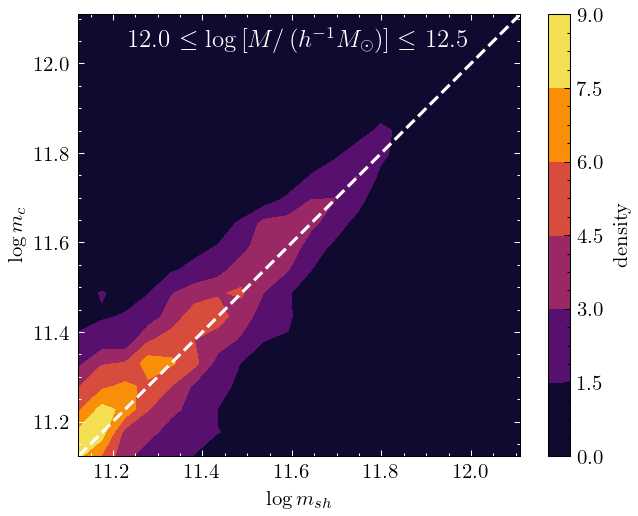

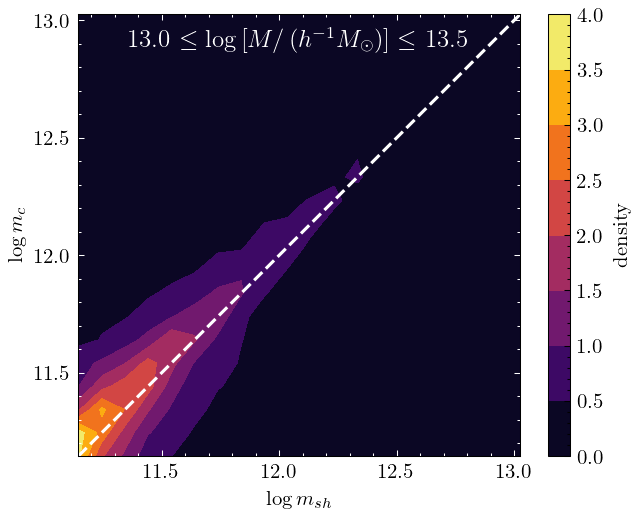

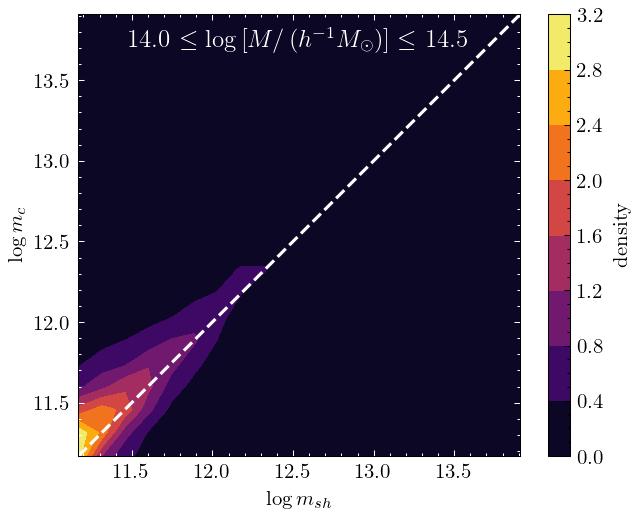

In [323]:
for logM1, alpha in zip( (12, 13, 14), (.3, .3, .3) ):
    M1, M2 = 10**logM1, 10**(logM1+0.5)
    (matched_m_cores, matched_M_cores, nH_cores, matched_ifhm_cores), (matched_m_sh, matched_M_sh, nH_sh), _, _ = subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499, mostMassiveCore=True)
    #(matched_m_cores, matched_M_cores, nH_cores, matched_ifhm_cores), (matched_m_sh, matched_M_sh, nH_sh), _, _ = subhalo_core_match(M1, M2, cc_HM0, centrals_mask_HM0, sh_HM0, 499, mlim=OBJECTMASSCUT['HM'], SHMLM=SHMLM_HM, mostMassiveCore=True)
    
#     histogram_matched_m(matched_ifhm_cores, matched_m_sh, matched_m_cores, M1, M2, legend=(logM1==14))
#     plt.savefig(f'Paper2Figs/spatialmatching_SV_z0_mostmassive_reldif_{logM1}.pdf')
    
    contour_matched_m(matched_m_cores, matched_m_sh, M1, M2)
#     plt.savefig(f'Paper2Figs/spatialmatching_SV_z0_mostmassive_contour_{logM1}.pdf')

## Infall tree node mass

nH_cores: 40628, nH_sh: 40628
73.77286925479697% of masked subhalos have at least 1 core within their search radius.
ylim:  (0.0, 3.6518978263405986)
xlim:  (-0.10499999620951712, 2.2049998999107627)

nH_cores: 4797, nH_sh: 4797
84.9670908293111% of masked subhalos have at least 1 core within their search radius.
ylim:  (0.0, 2.070853341117228)
xlim:  (-0.10499999620951712, 2.2049998999107627)

nH_cores: 337, nH_sh: 337
90.47342433923905% of masked subhalos have at least 1 core within their search radius.
ylim:  (0.0, 1.9020867030115147)
xlim:  (-0.10499999620951712, 2.2049998999107627)



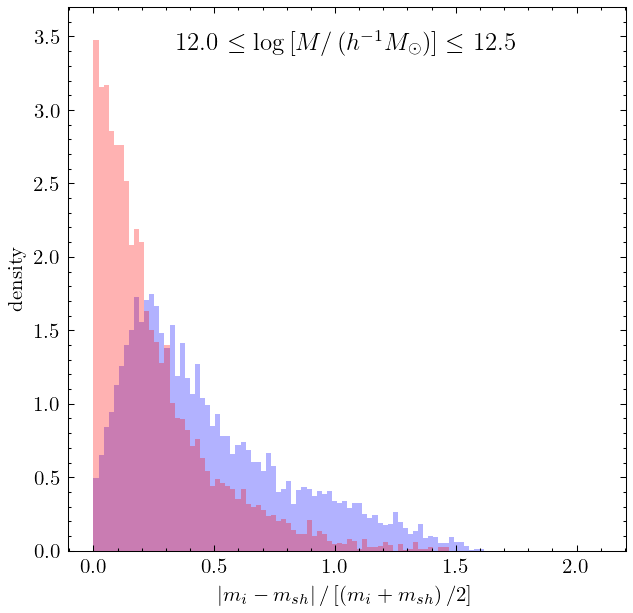

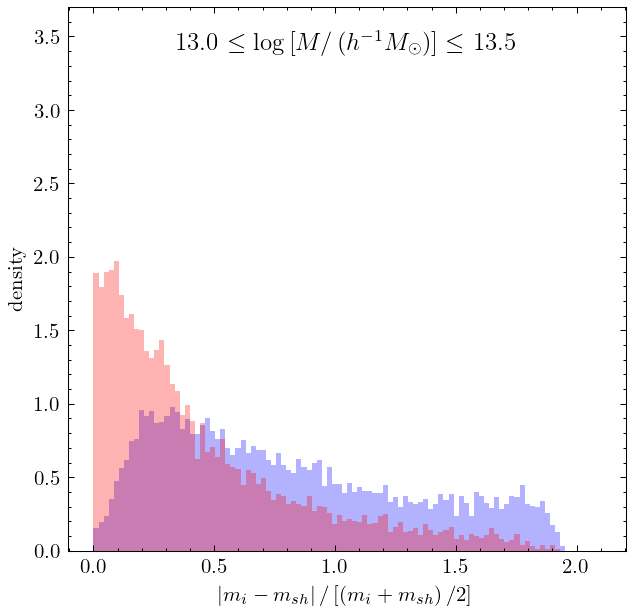

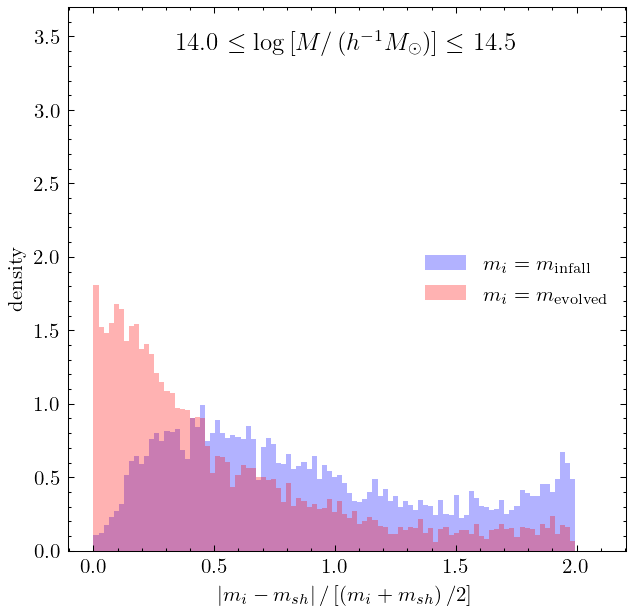

In [279]:
for logM1, alpha in zip( (12, 13, 14), (.3, .3, .3) ):
    M1, M2 = 10**logM1, 10**(logM1+0.5)
    (matched_m_cores, matched_M_cores, nH_cores, matched_ifhm_cores), (matched_m_sh, matched_M_sh, nH_sh), _, _ = subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499, mostMassiveCore=True, infall_mass_var='infall_tree_node_mass')
    histogram_matched_m(matched_ifhm_cores, matched_m_sh, matched_m_cores, M1, M2, legend=(logM1==14))
#     plt.savefig(f'Paper2Figs/spatialmatching_SV_z0_mostmassive_reldif_{logM1}_infalltreenodemass.pdf')
    print()

## All hosts, SV, z=0

In [141]:
# Include ALL SV z=0 hosts which have cores and subhalos
# M1, M2 = 70.*PARTICLEMASS['SV'], cc_SV0['M'].max()
M1, M2 = -np.inf, np.inf
(matched_m_cores, matched_M_cores, nH_cores, matched_ifhm_cores), (matched_m_sh, matched_M_sh, nH_sh), _, _ = subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499, mostMassiveCore=True, assert_nH=False)

nH_cores: 1789608, nH_sh: 555215
82.89772830614213% of masked subhalos have at least 1 core within their search radius.


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:390: RuntimeWarning: invalid value encountered in log10


(11.181928467750549, 12.2)

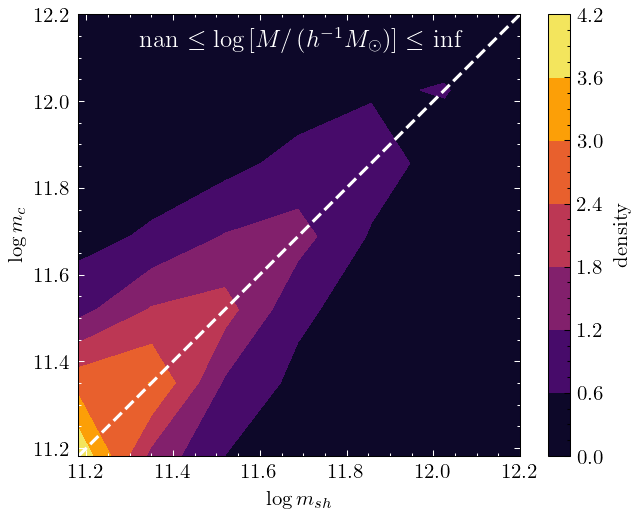

In [145]:
contour_matched_m(matched_m_cores, matched_m_sh, M1, M2)
plt.xlim(right=12.2)
plt.ylim(top=12.2)

# Host concentration bins

In [19]:
cc = cc_SV0
sh = sh_SV0
centrals_mask = centrals_mask_SV0
Mvar = 'M'
M1, M2 = 10**12.0, 10**13.0#10**12.5, 10**12.8

fht_fof = real_fof_tags(cc['fof_halo_tag'])
assert np.array_equal(fht_fof, cc['fof_halo_tag'])

fof_cores, idx_un = np.unique( fht_fof[centrals_mask&(M1 <= cc[Mvar])&(cc[Mvar] <= M2)], return_index=True )
idx_centrals = np.flatnonzero( centrals_mask&(M1 <= cc[Mvar])&(cc[Mvar] <= M2) )[idx_un]
nH_cores = len(fof_cores)

In [20]:
assert nH_cores == len(fht_fof[centrals_mask&(M1 <= cc[Mvar])&(cc[Mvar] <= M2)])

In [21]:
print('nH_cores\t', nH_cores)
print('nH_cores in sh\t', np.isin(fof_cores, sh['fof_halo_tag']).sum())

nH_cores	 54914
nH_cores in sh	 53890


In [25]:
print(len(np.unique( sh['fof_halo_tag'][(M1 <= sh[Mvar])&(sh[Mvar] <= M2)] )))
np.isin(np.unique( sh['fof_halo_tag'][(M1 <= sh[Mvar])&(sh[Mvar] <= M2)] ), cc['fof_halo_tag']).sum()

54914


53890

In [263]:
assert np.array_equal(fof_cores, cc['fof_halo_tag'][idx_centrals])
assert nH_cores==np.sum(centrals_mask&(M1 <= cc[Mvar])&(cc[Mvar] <= M2))

In [264]:
print('c<0:\t', (cc['infall_sod_halo_cdelta'][idx_centrals]<0).sum())
print('c==0:\t', (cc['infall_sod_halo_cdelta'][idx_centrals]==0).sum())
print('c==-1:\t', (cc['infall_sod_halo_cdelta'][idx_centrals]==-1).sum())
print('c==-101:', (cc['infall_sod_halo_cdelta'][idx_centrals]==-101).sum())

c<0:	 799
c==0:	 0
c==-1:	 766
c==-101: 0


In [265]:
# only get halos which are in sh catalog AND which have a nonnegative concentration
idx_centrals = idx_centrals[np.isin(fof_cores, sh['fof_halo_tag'])&(cc['infall_sod_halo_cdelta'][idx_centrals]>=0)]
print(f'Host fof halos in mass bin that are in sh catalog and have c>=0: {len(idx_centrals)/nH_cores*100}%')
nH_cores = len(idx_centrals)
print('nH_cores, sh\t', nH_cores)

Host fof halos in mass bin that are in sh catalog and have c>=0: 96.71122118221218%
nH_cores, sh	 53108


In [266]:
half1_mask = cc['infall_sod_halo_cdelta'][idx_centrals]<=np.median(cc['infall_sod_halo_cdelta'][idx_centrals])
h1 = cc['fof_halo_tag'][idx_centrals][half1_mask]
h2 = cc['fof_halo_tag'][idx_centrals][~half1_mask]

Med_cdelta = np.median(cc['infall_sod_halo_cdelta'][idx_centrals])
print('Med(cdelta)', Med_cdelta)
print('range(cdelta)', np.min(cc['infall_sod_halo_cdelta'][idx_centrals]), np.max(cc['infall_sod_halo_cdelta'][idx_centrals]))

Med(cdelta) 6.9317045
range(cdelta) 0.003244264 49.936092


In [267]:
print('c<0:\t', (cc['infall_sod_halo_cdelta'][idx_centrals]<0).sum())
print('c==0:\t', (cc['infall_sod_halo_cdelta'][idx_centrals]==0).sum())

c<0:	 0
c==0:	 0


In [268]:
#### figure out what -101 (fof p count <500), -1(sod part. count too low), -x (throw out) means
np.unique(cc['infall_sod_halo_cdelta'][centrals_mask], return_counts=True)

(array([-101.       ,   -1.       ,   -0.5039451, ...,   43.977493 ,
          46.8622   ,   49.936092 ], dtype=float32),
 array([1694826,   12925,       1, ...,       1,       1,       1]))

In [269]:
np.unique(cc['infall_sod_halo_cdelta'][idx_centrals], return_counts=True)

(array([3.2442641e-03, 5.7812827e-03, 1.8318620e-02, ..., 4.3104954e+01,
        4.3977493e+01, 4.9936092e+01], dtype=float32),
 array([1, 1, 1, ..., 1, 1, 1]))

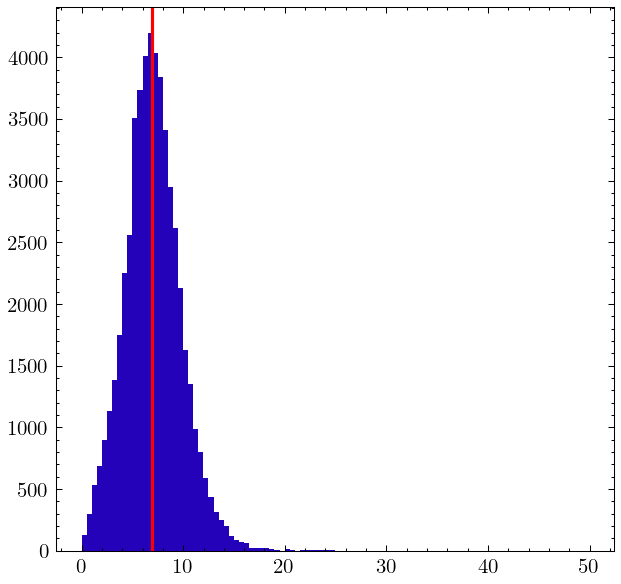

In [270]:
plt.hist(cc['infall_sod_halo_cdelta'][idx_centrals], 100)
plt.axvline(np.median(cc['infall_sod_halo_cdelta'][idx_centrals]), c='r')

nH_h, sh	 26554
nH_h, sh	 26554
xlim (11.06285228729248, 12.65367374420166)


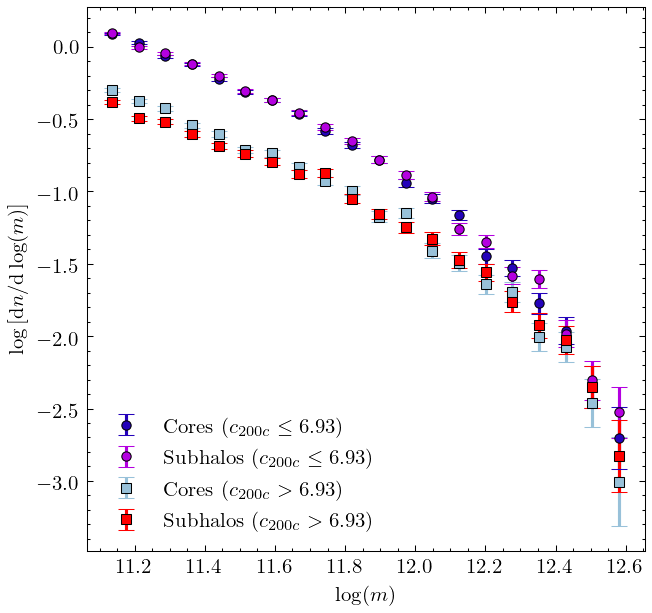

In [273]:
concentration_plot(cc, centrals_mask, sh, h1, h2, Med_cdelta)
# plt.savefig('Paper2Figs/concentration_12.0_13.0_SV_z0_newlegendlabels.pdf')

# The Last Journey Simulation

## Create host halo bins

In [9]:
# z=1 fragment tests
mask1 = (cc_LJ1['M'][centrals_mask_LJ1]>=10**14.5)&(cc_LJ1['M'][centrals_mask_LJ1]<10**14.51)
fht1 = cc_LJ1['fof_halo_tag'][centrals_mask_LJ1][mask1]
len(np.unique( (fht1<0)*np.bitwise_and(fht1*-1, 0xffffffffffff) + (fht1>=0)*fht1 ))

185

In [10]:
m_bin_all0 = []
for lM in [12.0, 12.5, 13.0, 13.5, 14.0, 14.5]:
    m_bin_all0.append(hostbins(cc_LJ0, centrals_mask_LJ0, 10**lM, 10**(lM+0.5), verbose=True, s1=False, minHalosFlag=True))

Total host halos within mass threshold 103359935
Number of host halos in bin 3.7842e+05
Host halo mass bin size: 1.31072e+05
Number of infall halos: 145318
Hosts with no infall halos: 240764 (63.62348713070134%)

Total host halos within mass threshold 36298650
Number of host halos in bin 4.264e+04
Host halo mass bin size: 2.62144e+05
Number of infall halos: 89731
Hosts with no infall halos: 2389 (5.602720450281429%)

Total host halos within mass threshold 12163595
Number of host halos in bin 1.4303e+04
Host halo mass bin size: 5.4347694e+09
Number of infall halos: 103913
Hosts with no infall halos: 0 (0.0%)

Total host halos within mass threshold 3662069
Number of host halos in bin 1.0102e+04
Host halo mass bin size: 5.435189e+10
Number of infall halos: 229534
Hosts with no infall halos: 0 (0.0%)

Total host halos within mass threshold 872353
Number of host halos in bin 1.0018e+04
Host halo mass bin size: 6.73924e+11
Number of infall halos: 701473
Hosts with no infall halos: 0 (0.0%)



In [11]:
m_bin_all1 = []
for lM in [12.0, 12.5, 13.0, 13.5, 14.0, 14.5]:
    m_bin_all1.append(hostbins(cc_LJ1, centrals_mask_LJ1, 10**lM, 10**(lM+0.5), verbose=True, s1=False, minHalosFlag=True))

Total host halos within mass threshold 93427959
Number of host halos in bin 3.54197e+05
Host halo mass bin size: 1.31072e+05
Number of infall halos: 127922
Hosts with no infall halos: 231071 (65.23798902870436%)

Total host halos within mass threshold 31619194
Number of host halos in bin 3.6743e+04
Host halo mass bin size: 2.62144e+05
Number of infall halos: 68268
Hosts with no infall halos: 5227 (14.2258389353074%)

Total host halos within mass threshold 12876430
Number of host halos in bin 1.3187e+04
Host halo mass bin size: 5.4347694e+09
Number of infall halos: 57021
Hosts with no infall halos: 4575 (34.69325851217108%)

Total host halos within mass threshold 5193612
Number of host halos in bin 1.0064e+04
Host halo mass bin size: 4.076444e+10
Number of infall halos: 58589
Hosts with no infall halos: 6718 (66.75278219395867%)

Total host halos within mass threshold 1190506
Number of host halos in bin 1.003e+04
Host halo mass bin size: 4.3749946e+11
Number of infall halos: 65066
Hosts

In [12]:
print('z=0')
for bin_mask, Mavg, Nhalos in m_bin_all0:
    print( 'logMavg', round(np.log10(Mavg), 1) )
    print('Mmin(1e12)', round(cc_LJ0['M'][bin_mask].min()/1.e12, 3))
    print('Mmax(1e12)', round(cc_LJ0['M'][bin_mask].max()/1.e12, 3))
    print('Nhalos', Nhalos)
    print()

print('z=1')
for bin_mask, Mavg, Nhalos in m_bin_all1:
    print( 'logMavg', round(np.log10(Mavg), 1) )
    print('Mmin(1e12)', round(cc_LJ1['M'][bin_mask].min()/1.e12, 3))
    print('Mmax(1e12)', round(cc_LJ1['M'][bin_mask].max()/1.e12, 3))
    print('Nhalos', Nhalos)
    print()

z=0
logMavg 12.0
Mmin(1e12) 1.0
Mmax(1e12) 1.0
Nhalos 378420

logMavg 12.5
Mmin(1e12) 3.163
Mmax(1e12) 3.163
Nhalos 42640

logMavg 13.0
Mmin(1e12) 10.0
Mmax(1e12) 10.005
Nhalos 14303

logMavg 13.5
Mmin(1e12) 31.625
Mmax(1e12) 31.679
Nhalos 10102

logMavg 14.0
Mmin(1e12) 100.0
Mmax(1e12) 100.674
Nhalos 10018

logMavg 14.5
Mmin(1e12) 316.229
Mmax(1e12) 328.172
Nhalos 10001

z=1
logMavg 12.0
Mmin(1e12) 1.0
Mmax(1e12) 1.0
Nhalos 343116

logMavg 12.5
Mmin(1e12) 3.163
Mmax(1e12) 3.163
Nhalos 32902

logMavg 13.0
Mmin(1e12) 10.0
Mmax(1e12) 10.005
Nhalos 8365

logMavg 13.5
Mmin(1e12) 31.625
Mmax(1e12) 31.666
Nhalos 2929

logMavg 14.0
Mmin(1e12) 100.0
Mmax(1e12) 100.438
Nhalos 1093

logMavg 14.5
Mmin(1e12) 316.245
Mmax(1e12) 331.645
Nhalos 354



## Core mass fn fitting (log space)

In [772]:
def mass_fitting_fn_eq6_log(x, AM, alpha):
    '''2016b eq 6 fitting function in form of y=dn/dlog(m/m) and x=log(m/M)'''
    beta, omega = 50., 4.
    psi = 10**x
    return np.log10( AM*(psi**(-alpha))*np.exp(-beta*(psi**omega)) )

ALPHA_Z_LOGSPACE = {0:0.964, 1:0.852} #{0:0.92, 1:0.80}
def mass_fitting_fn_eq6_z0_log(x, AM):
    '''2016b eq 6 fitting function in form of y=dn/dlog(m/m) and x=log(m/M)'''
    alpha = ALPHA_Z_LOGSPACE[0]
    beta, omega = 50., 4.
    psi = 10**x
    return np.log10( AM*(psi**(-alpha))*np.exp(-beta*(psi**omega)) )
def mass_fitting_fn_eq6_z1_log(x, AM):
    '''2016b eq 6 fitting function in form of y=dn/dlog(m/m) and x=log(m/M)'''
    alpha = ALPHA_Z_LOGSPACE[1]
    beta, omega = 50., 4.
    psi = 10**x
    return np.log10( AM*(psi**(-alpha))*np.exp(-beta*(psi**omega)) )

LJ nH cores 42640
12.500106 [0.05490906] [0.00116232]
LJ nH cores 14303
13.000117 [0.05966829] [0.00061441]
LJ nH cores 10102
13.500401 [0.0628601] [0.0005116]
LJ nH cores 10018
14.001463 [0.06388022] [0.00063588]
LJ nH cores 10001
14.507966 [0.06633513] [0.00074364]
LJ nH cores 32902
12.500106 [0.10584334] [0.00110674]
LJ nH cores 8365
13.000117 [0.11730616] [0.00180298]
LJ nH cores 2929
13.500312 [0.11365015] [0.00244827]
LJ nH cores 1093
14.000937 [0.11594535] [0.00247839]
LJ nH cores 354
14.509719 [0.12231137] [0.00239257]
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354


/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)
/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


Text(0, 0.5, 'ratio')

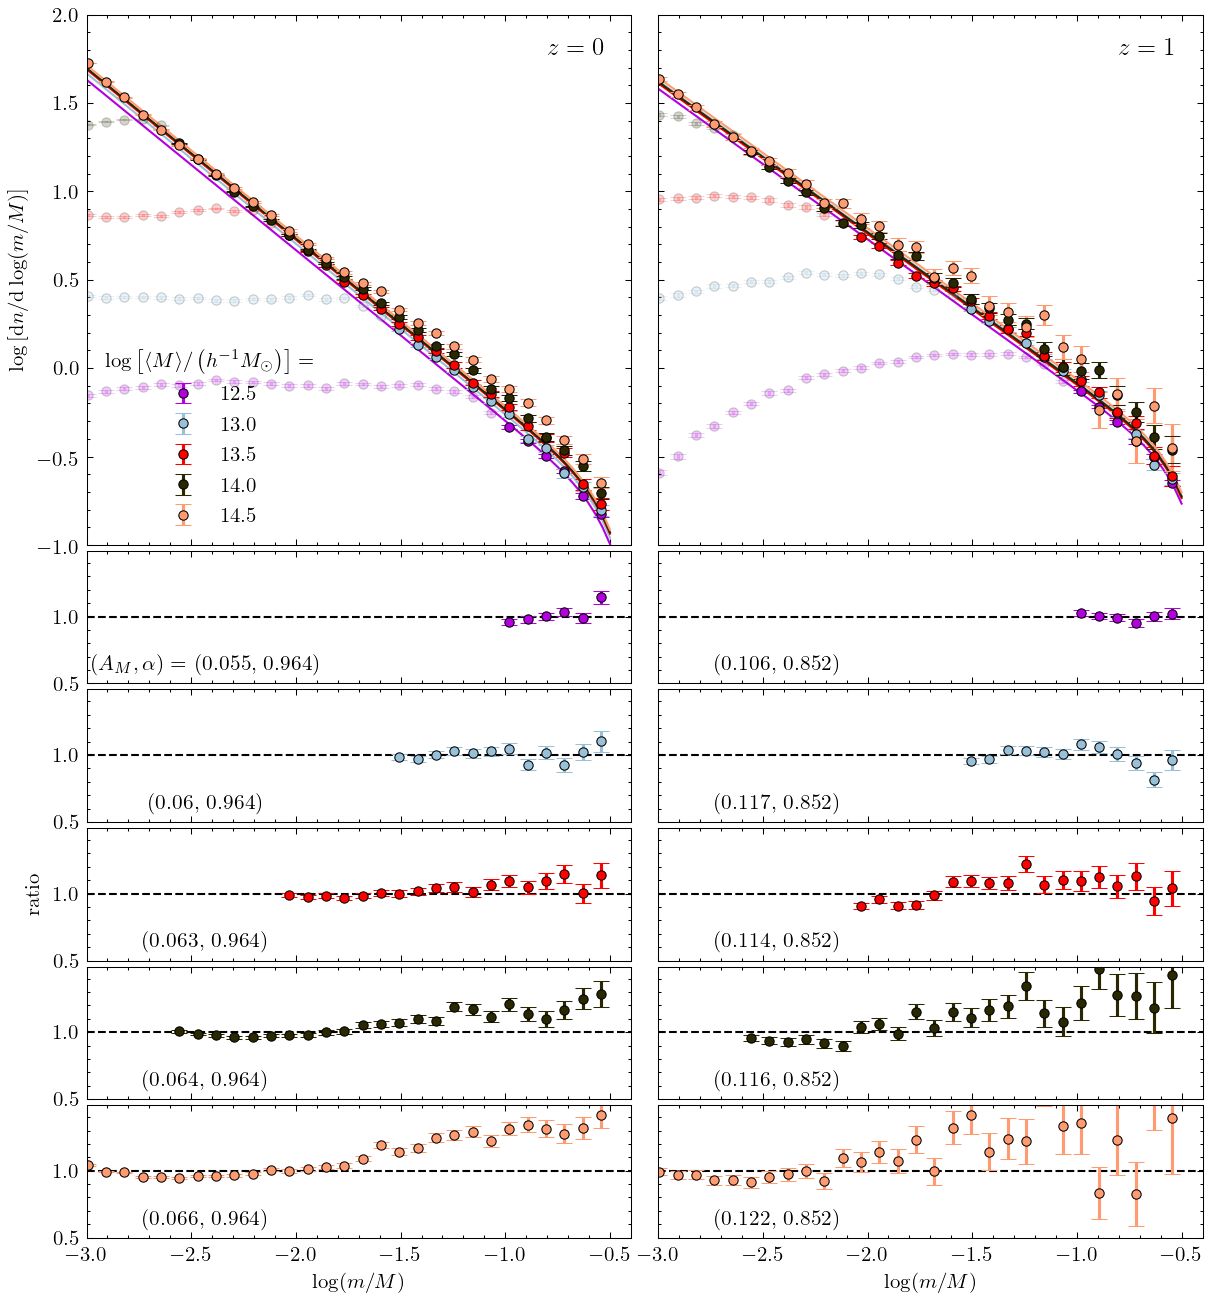

In [773]:
# beta=50, omega = 4. and a=1
# Remove 12 bin
# Paper 2 Eq 6 fitting for AM with alpha FIXED for each z
# Host bins seperate fits
# fitting sigma

r = r_eq6
bins = 40
fig, axtup = plt.subplots(6, 2, sharex=True, sharey='row', gridspec_kw={'wspace': .05, 'width_ratios': [1, 1], 'hspace':.03, 'height_ratios': [4,1,1,1,1,1]}, figsize=[4.8*2,4.8*9/4])
popt_z = {0:[], 1:[]}

for z, m_bin_all, cc, centrals_mask, ax, axrtup, mass_fitting_fn in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]), (mass_fitting_fn_eq6_z0_log, mass_fitting_fn_eq6_z1_log) ):
    for (bin_mask, Mavg, Nhalos), c, axr in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        
        popt, pcov = curve_fit(mass_fitting_fn, x[xmask], y[xmask], sigma=yerr_log[xmask], p0=(0.058))
        print(np.log10(Mavg), popt, np.sqrt(np.diag(pcov)))
        popt_z[z].append(popt)
        ax.plot(np.linspace(*r, 100), mass_fitting_fn(np.linspace(*r, 100), *popt), '-', color=c, lw=1)
    ax.set_xlim(-3,-0.4)
    ax.set_ylim(-1,2)

### ratio plot ###
for z, m_bin_all, cc, centrals_mask, ax, axrtup, mass_fitting_fn in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]), (mass_fitting_fn_eq6_z0_log, mass_fitting_fn_eq6_z1_log) ):
    for (bin_mask, Mavg, Nhalos), c, axr, popt in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup, popt_z[z]):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(axr, x[xmask], 10**(y[xmask])/10**mass_fitting_fn(x[xmask], *popt), yerr=yerr[xmask]/10**mass_fitting_fn(x[xmask], *popt), c=c)
        axr.set_ylim(0.5, 1.49)
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
        axr.set_title((r'$(A_M, \alpha)=$ 'if axr==axtup[1,0] else '')+f'({round(popt[0],3)}, {ALPHA_Z_LOGSPACE[z]})', x=0.22, y=0, fontsize=10.2)

axtup[0,0].legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$', loc=3)
axtup[0,0].set_title('$z=0$', y=0.9, x=0.9)
axtup[0,1].set_title('$z=1$', y=0.9, x=0.9)
axtup[5,0].set_xlabel(r'$\log(m/M)$')
axtup[5,1].set_xlabel(r'$\log(m/M)$')
axtup[0,0].set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
axtup[3,0].set_ylabel('ratio')
# ax2.legend(handles=[ax2.plot([],[], '-', color='b', lw=2, label=r'Fit $(\gamma, \alpha, \beta, \omega, a)$:')[0],
#                     ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.031, -0.95, 50., 4.0, 1.0)$ $z=0$')[0],
#                    ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.058, -0.83, 50., 4.0, 1.0)$ $z=1$')[0]], 
#            loc=4, handlelength=1)#, title=r'Fit $(\gamma, \alpha, \beta, \omega, a)=$')

LJ nH cores 42640
12.500106 [0.06883779 0.84383239] [0.00544193 0.04140974]
LJ nH cores 14303
13.000117 [0.06207837 0.94987887] [0.00313438 0.01761488]
LJ nH cores 10102
13.500401 [0.0719382  0.92886056] [0.00156713 0.00555325]
LJ nH cores 10018
14.001463 [0.07685102 0.92677139] [0.00280228 0.00721288]
LJ nH cores 10001
14.507966 [0.0784451  0.93582181] [0.00461732 0.00974829]
LJ nH cores 32902
12.500106 [0.10021427 0.8809906 ] [0.00632174 0.03297889]
LJ nH cores 8365
13.000117 [0.11952035 0.84524054] [0.00908696 0.02686195]
LJ nH cores 2929
13.500312 [0.15369162 0.7711001 ] [0.00994858 0.0169246 ]
LJ nH cores 1093
14.000937 [0.17429498 0.76728464] [0.00921385 0.01073831]
LJ nH cores 354
14.509719 [0.17840092 0.78679266] [0.01297372 0.01232923]
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354


/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)
/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


Text(0, 0.5, 'ratio')

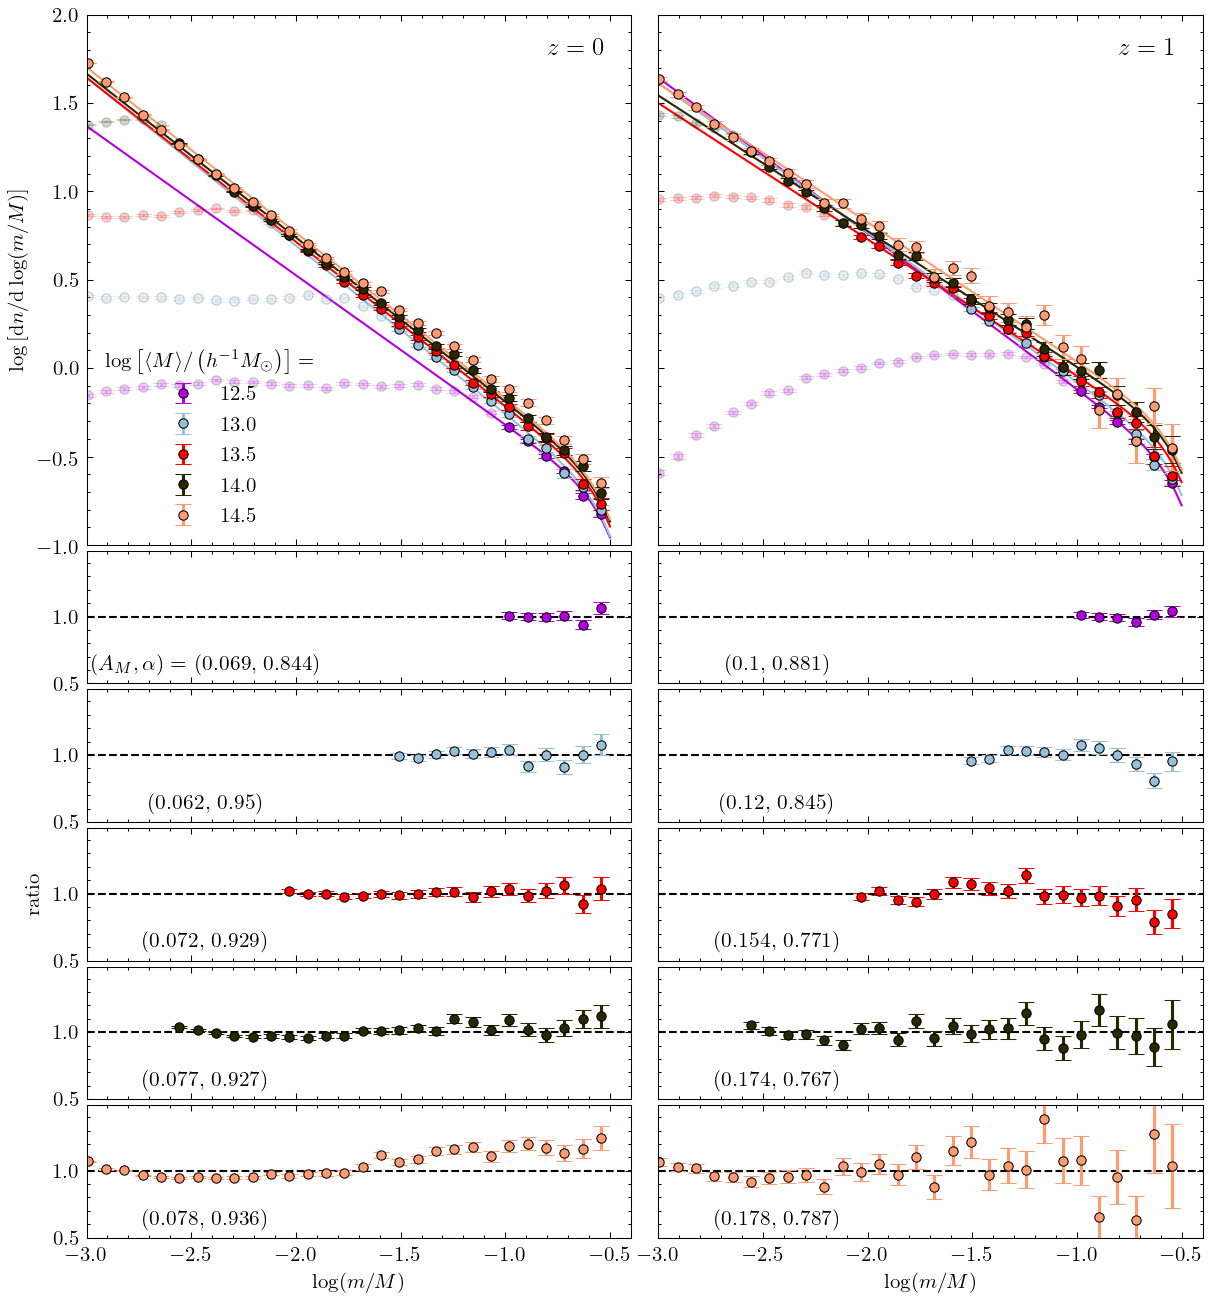

In [761]:
# beta=50, omega = 4. and a=1
# Remove 12 bin
# Paper 2 Eq 6 fitting for AM, alpha
# Host bins seperate fits
# fitting sigma

r = r_eq6
bins = 40
fig, axtup = plt.subplots(6, 2, sharex=True, sharey='row', gridspec_kw={'wspace': .05, 'width_ratios': [1, 1], 'hspace':.03, 'height_ratios': [4,1,1,1,1,1]}, figsize=[4.8*2,4.8*9/4])
popt_z = {0:[], 1:[]}

for z, m_bin_all, cc, centrals_mask, ax, axrtup in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]) ):
    for (bin_mask, Mavg, Nhalos), c, axr in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        
        popt, pcov = curve_fit(mass_fitting_fn_eq6_log, x[xmask], y[xmask], sigma=yerr_log[xmask], p0=(0.058, 0.86))
        print(np.log10(Mavg), popt, np.sqrt(np.diag(pcov)))
        popt_z[z].append(popt)
        ax.plot(np.linspace(*r, 100), mass_fitting_fn_eq6_log(np.linspace(*r, 100), *popt), '-', color=c, lw=1)
    ax.set_xlim(-3,-0.4)
    ax.set_ylim(-1,2)

### ratio plot ###
for z, m_bin_all, cc, centrals_mask, ax, axrtup in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]) ):
    for (bin_mask, Mavg, Nhalos), c, axr, popt in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup, popt_z[z]):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(axr, x[xmask], 10**(y[xmask])/10**mass_fitting_fn_eq6_log(x[xmask], *popt), yerr=yerr[xmask]/10**mass_fitting_fn_eq6_log(x[xmask], *popt), c=c)
        axr.set_ylim(0.5, 1.49)
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
        axr.set_title((r'$(A_M, \alpha)=$ 'if axr==axtup[1,0] else '')+f'({round(popt[0],3)}, {round(popt[1],3)})', x=0.22, y=0, fontsize=10.2)

axtup[0,0].legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$', loc=3)
axtup[0,0].set_title('$z=0$', y=0.9, x=0.9)
axtup[0,1].set_title('$z=1$', y=0.9, x=0.9)
axtup[5,0].set_xlabel(r'$\log(m/M)$')
axtup[5,1].set_xlabel(r'$\log(m/M)$')
axtup[0,0].set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
axtup[3,0].set_ylabel('ratio')
# ax2.legend(handles=[ax2.plot([],[], '-', color='b', lw=2, label=r'Fit $(\gamma, \alpha, \beta, \omega, a)$:')[0],
#                     ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.031, -0.95, 50., 4.0, 1.0)$ $z=0$')[0],
#                    ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.058, -0.83, 50., 4.0, 1.0)$ $z=1$')[0]], 
#            loc=4, handlelength=1)#, title=r'Fit $(\gamma, \alpha, \beta, \omega, a)=$')

LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
[0.06511079 0.96396107] [0.00187146 0.00515764]
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354
[0.11495926 0.85215471] [0.00299758 0.00625933]
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354


/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)
/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


Text(0, 0.5, 'ratio')

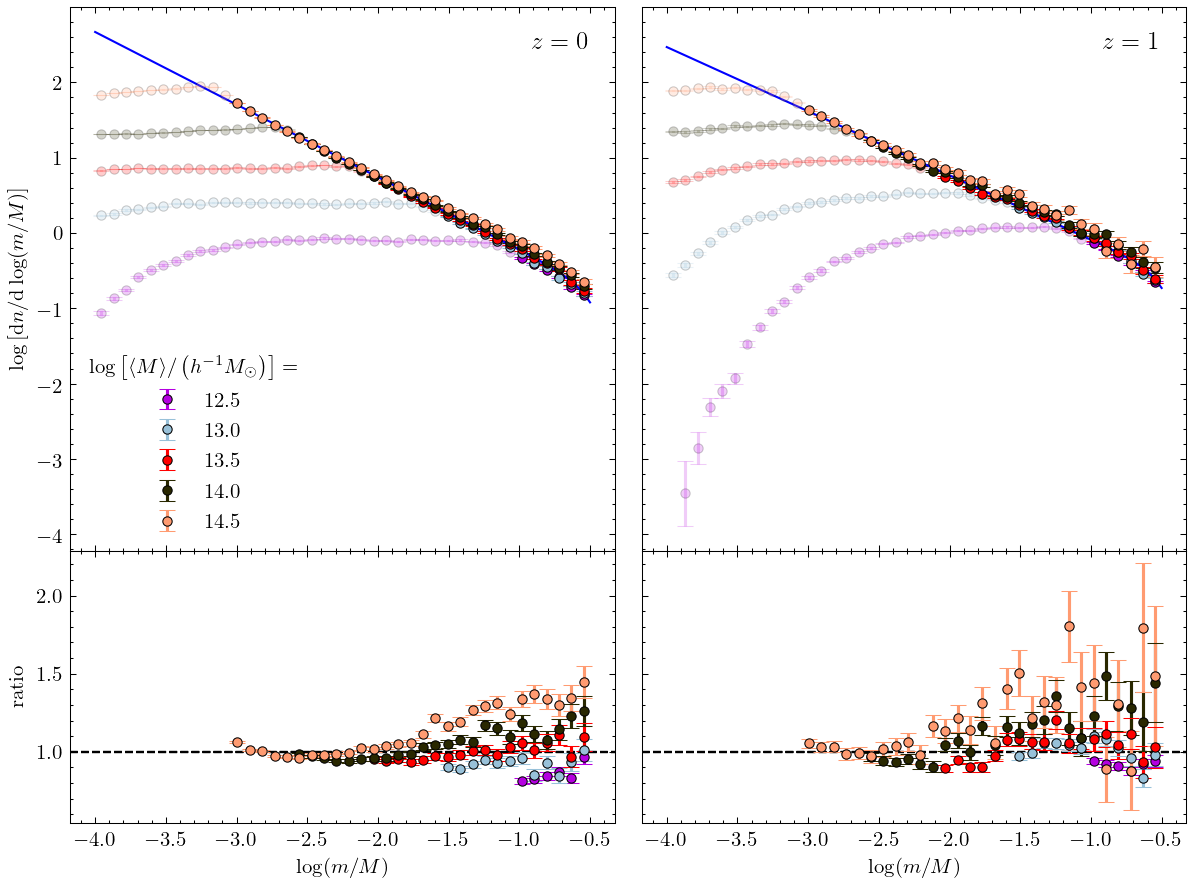

In [758]:
# beta=50, omega = 4. and a=1
# Remove 12 bin
# Paper 2 Eq 6 fitting for AM, alpha
# fitting sigma

r = r_eq6
bins = 40
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey='row', gridspec_kw={'wspace': .05, 'width_ratios': [1, 1], 'hspace':0, 'height_ratios': [2, 1]}, figsize=[4.8*2,4.8*1.5])
popt_z = []

for m_bin_all, cc, centrals_mask, ax, axr in zip( (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), (ax1,ax2), (ax3,ax4) ):
    x_fittingarr, y_fittingarr, sigma_fittingarr = [], [], []
    for (bin_mask, Mavg, Nhalos), c in zip(m_bin_all, COLOR_SCHEME):
        if round(np.log10(Mavg), 1)==12:
            continue
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        x_fittingarr.append(x[xmask])
        y_fittingarr.append(y[xmask])
        sigma_fittingarr.append(yerr_log[xmask])
    x_fittingarr = np.concatenate(x_fittingarr)
    y_fittingarr = np.concatenate(y_fittingarr)
    sigma_fittingarr = np.concatenate(sigma_fittingarr)
    popt, pcov = curve_fit(mass_fitting_fn_eq6_log, x_fittingarr, y_fittingarr, sigma=sigma_fittingarr, p0=(0.058, 0.86))
    print(popt, np.sqrt(np.diag(pcov)))
    popt_z.append(popt)
    ax.plot(np.linspace(*r, 100), mass_fitting_fn_eq6_log(np.linspace(*r, 100), *popt), '-', color='b', lw=1)

### ratio plot ###
for m_bin_all, cc, centrals_mask, ax, axr, popt in zip( (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), (ax1,ax2), (ax3,ax4), popt_z ):
    for (bin_mask, Mavg, Nhalos), c in zip(m_bin_all, COLOR_SCHEME):
        if round(np.log10(Mavg), 1)==12:
            continue
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(axr, x[xmask], 10**(y[xmask])/10**mass_fitting_fn_eq6_log(x[xmask], *popt), yerr=yerr[xmask]/10**mass_fitting_fn_eq6_log(x[xmask], *popt), c=c)
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
    
ax1.legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$')
ax1.set_title('$z=0$', y=0.9, x=0.9)
ax2.set_title('$z=1$', y=0.9, x=0.9)
ax3.set_xlabel(r'$\log(m/M)$')
ax4.set_xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
ax3.set_ylabel('ratio')
# ax2.legend(handles=[ax2.plot([],[], '-', color='b', lw=2, label=r'Fit $(\gamma, \alpha, \beta, \omega, a)$:')[0],
#                     ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.031, -0.95, 50., 4.0, 1.0)$ $z=0$')[0],
#                    ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.058, -0.83, 50., 4.0, 1.0)$ $z=1$')[0]], 
#            loc=4, handlelength=1)#, title=r'Fit $(\gamma, \alpha, \beta, \omega, a)=$')

## Core mass function fitting

In [13]:
from scipy.optimize import curve_fit
def general_mass_fitting_fn(x, gamma, alpha, beta, omega, a):
    '''Jiang+vdBosch 2016 general fitting function (A1) in form of y=log(dn/dlog(m/m)) and x=log(m/M)'''
    apsi = a*(10**x)
    return np.log10( np.log(10)*gamma*(apsi**alpha)*np.exp(-beta*(apsi**omega)) )

In [14]:
def mass_fitting_fn_eq6(x, AM, alpha):
    '''2016b eq 6 fitting function in form of y=dn/dlog(m/m) and x=log(m/M)'''
    beta, omega = 50., 4.
    psi = 10**x
    return AM*(psi**(-alpha))*np.exp(-beta*(psi**omega))

ALPHA_Z = {0:0.94, 1:0.8}#{0:0.9623486, 1:0.83457165}#{0:0.970, 1:0.855}
def mass_fitting_fn_eq6_z0(x, AM):
    '''2016b eq 6 fitting function in form of y=dn/dlog(m/m) and x=log(m/M)'''
    alpha = ALPHA_Z[0]
    beta, omega = 50., 4.
    psi = 10**x
    return AM*(psi**(-alpha))*np.exp(-beta*(psi**omega))
def mass_fitting_fn_eq6_z1(x, AM):
    '''2016b eq 6 fitting function in form of y=dn/dlog(m/m) and x=log(m/M)'''
    alpha = ALPHA_Z[1]
    beta, omega = 50., 4.
    psi = 10**x
    return AM*(psi**(-alpha))*np.exp(-beta*(psi**omega))

In [15]:
r_eq6 = (-4,-0.5)

LJ nH cores 42640
12.500106 [0.05730824] [0.0010131]
LJ nH cores 14303
13.000117 [0.06370901] [0.00066477]
LJ nH cores 10102
13.500401 [0.06888596] [0.00033106]
LJ nH cores 10018
14.001463 [0.07184161] [0.00050445]
LJ nH cores 10001
14.507966 [0.07622245] [0.0007283]
LJ nH cores 32902
12.500106 [0.11654128] [0.00177696]
LJ nH cores 8365
13.000117 [0.13469082] [0.0025414]
LJ nH cores 2929
13.500312 [0.13720689] [0.00203562]
LJ nH cores 1093
14.000937 [0.14808006] [0.00187151]
LJ nH cores 354
14.509719 [0.16396336] [0.00224718]
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354


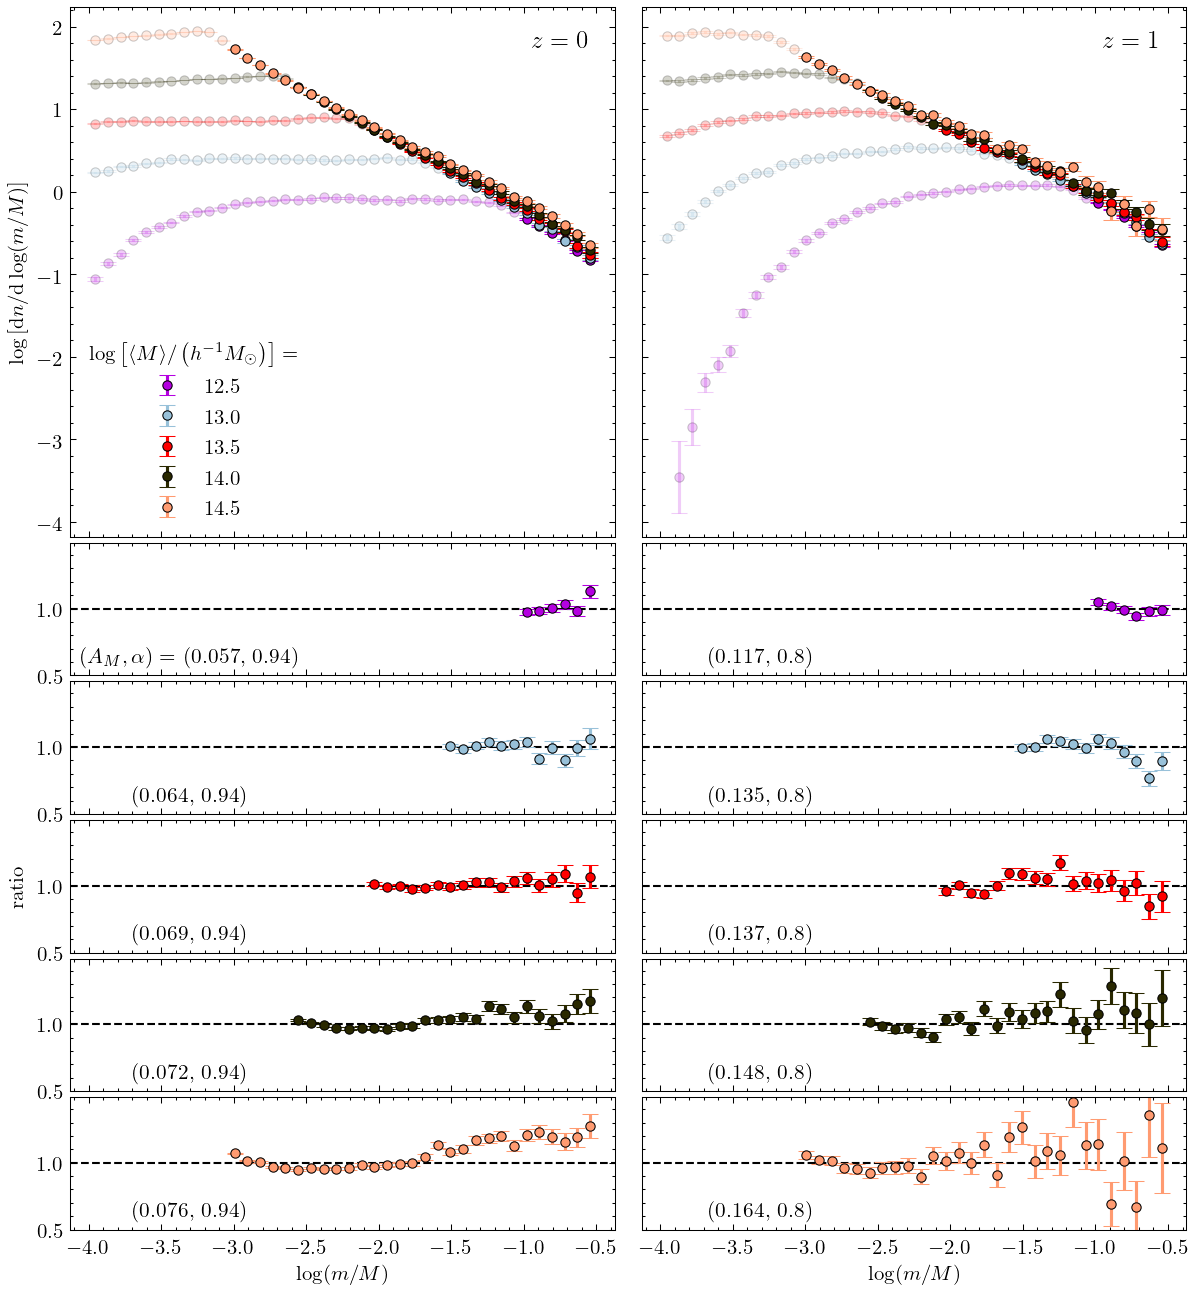

In [19]:
# FINAL VERSION (10/5/20)
# beta=50, omega = 4. and a=1
# Remove 12 bin
# Paper 2 Eq 6 fitting for AM with alpha FIXED for each z
# Host bins seperate fits
# fitting sigma

r = r_eq6
bins = 40
fig, axtup = plt.subplots(6, 2, sharex=True, sharey='row', gridspec_kw={'wspace': .05, 'width_ratios': [1, 1], 'hspace':.03, 'height_ratios': [4,1,1,1,1,1]}, figsize=[4.8*2,4.8*9/4])
popt_z = {0:[], 1:[]}

for z, m_bin_all, cc, centrals_mask, ax, axrtup, mass_fitting_fn in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]), (mass_fitting_fn_eq6_z0, mass_fitting_fn_eq6_z1) ):
    for (bin_mask, Mavg, Nhalos), c, axr in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        
        popt, pcov = curve_fit(mass_fitting_fn, x[xmask], 10**(y[xmask]), sigma=yerr[xmask], p0=(0.058))
        print(np.log10(Mavg), popt, np.sqrt(np.diag(pcov)))
        popt_z[z].append(popt)
        ##ax.plot(np.linspace(*r, 100), np.log10(mass_fitting_fn(np.linspace(*r, 100), *popt)), '-', color=c, lw=1)
#     ax.set_xlim(-3,-0.4)
#     ax.set_ylim(-1,2)

### ratio plot ###
for z, m_bin_all, cc, centrals_mask, ax, axrtup, mass_fitting_fn in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]), (mass_fitting_fn_eq6_z0, mass_fitting_fn_eq6_z1) ):
    for (bin_mask, Mavg, Nhalos), c, axr, popt in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup, popt_z[z]):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(axr, x[xmask], 10**(y[xmask])/mass_fitting_fn(x[xmask], *popt), yerr=yerr[xmask]/mass_fitting_fn(x[xmask], *popt), c=c)
        axr.set_ylim(0.5, 1.49)
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
        axr.set_title((r'$(A_M, \alpha)=$ 'if axr==axtup[1,0] else '')+f'({round(popt[0],3)}, {ALPHA_Z[z]})', x=0.22, y=0, fontsize=10.2)

axtup[0,0].legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$', loc=3)
axtup[0,0].set_title('$z=0$', y=0.9, x=0.9)
axtup[0,1].set_title('$z=1$', y=0.9, x=0.9)
axtup[5,0].set_xlabel(r'$\log(m/M)$')
axtup[5,1].set_xlabel(r'$\log(m/M)$')
axtup[0,0].set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
axtup[3,0].set_ylabel('ratio')
# ax2.legend(handles=[ax2.plot([],[], '-', color='b', lw=2, label=r'Fit $(\gamma, \alpha, \beta, \omega, a)$:')[0],
#                     ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.031, -0.95, 50., 4.0, 1.0)$ $z=0$')[0],
#                    ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.058, -0.83, 50., 4.0, 1.0)$ $z=1$')[0]], 
#            loc=4, handlelength=1)#, title=r'Fit $(\gamma, \alpha, \beta, \omega, a)=$')
##plt.savefig('Paper2Figs/massfn_LastJourney_alpha_eq1fit_fitlines.pdf')
# plt.savefig('Paper2Figs/massfn_LastJourney_alpha_eq1fit.pdf')

LJ nH cores 42640
12.500106 [0.05730824] [0.0010131]
LJ nH cores 14303
13.000117 [0.06370901] [0.00066477]
LJ nH cores 10102
13.500401 [0.06888596] [0.00033106]
LJ nH cores 10018
14.001463 [0.07184161] [0.00050445]
LJ nH cores 10001
14.507966 [0.07622245] [0.0007283]
LJ nH cores 32902
12.500106 [0.11654128] [0.00177696]
LJ nH cores 8365
13.000117 [0.13469082] [0.0025414]
LJ nH cores 2929
13.500312 [0.13720689] [0.00203562]
LJ nH cores 1093
14.000937 [0.14808006] [0.00187151]
LJ nH cores 354
14.509719 [0.16396336] [0.00224718]
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354


/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)
/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


Text(0, 0.5, 'ratio')

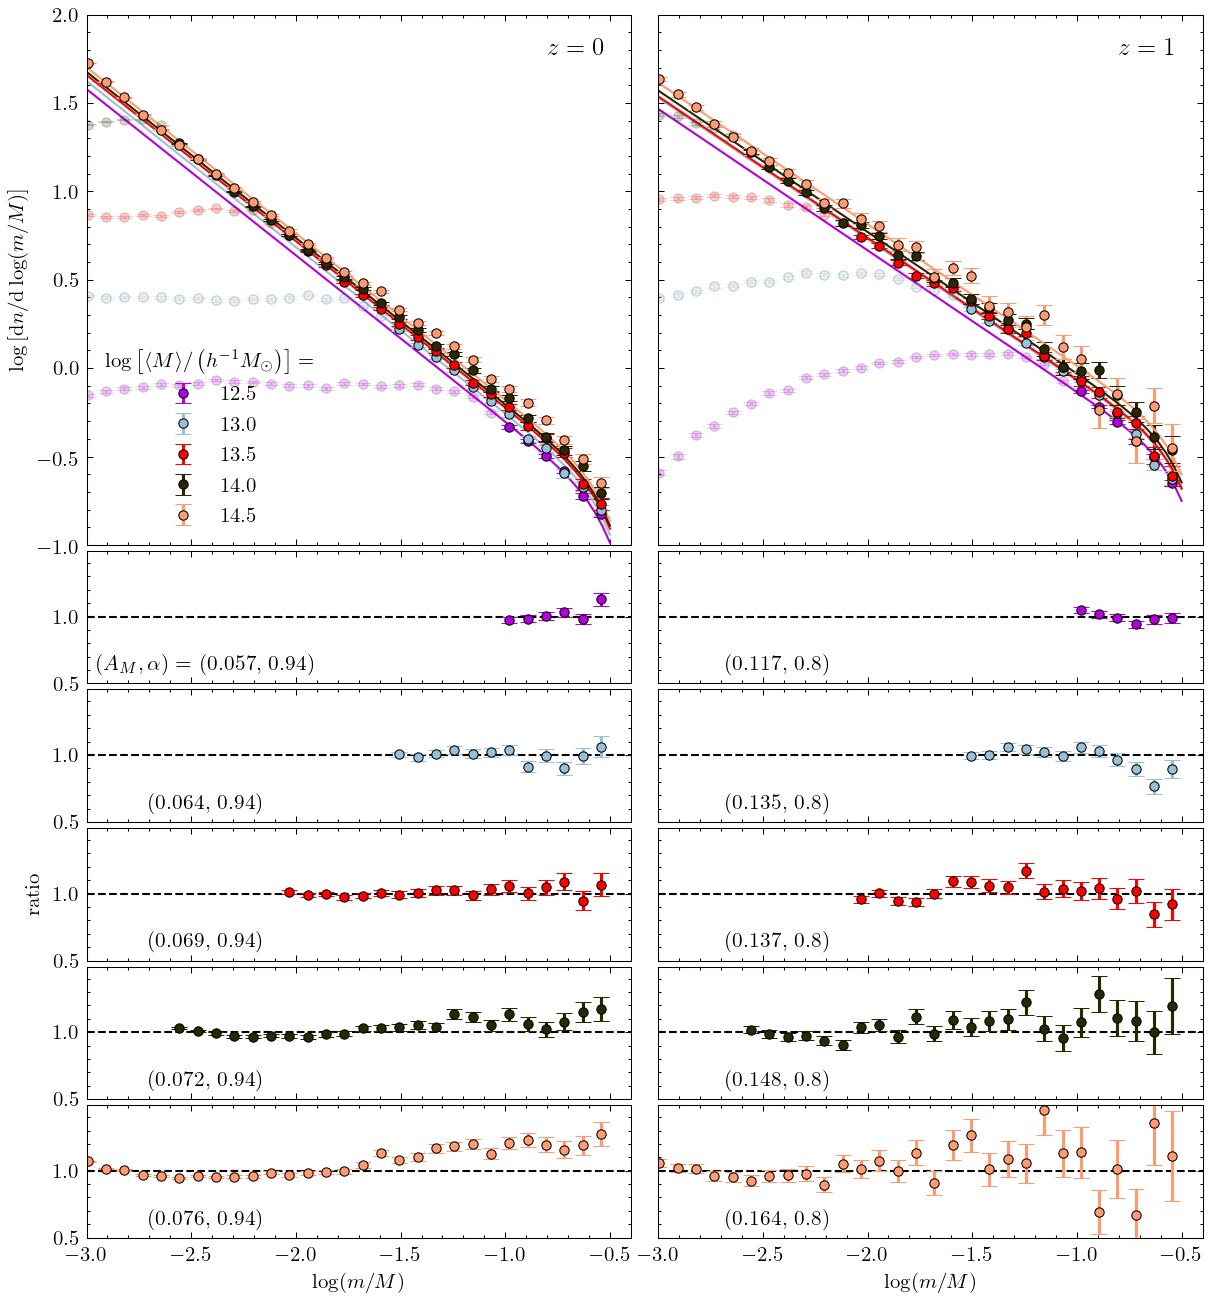

In [23]:
# beta=50, omega = 4. and a=1
# Remove 12 bin
# Paper 2 Eq 6 fitting for AM with alpha FIXED for each z
# Host bins seperate fits
# fitting sigma

r = r_eq6
bins = 40
fig, axtup = plt.subplots(6, 2, sharex=True, sharey='row', gridspec_kw={'wspace': .05, 'width_ratios': [1, 1], 'hspace':.03, 'height_ratios': [4,1,1,1,1,1]}, figsize=[4.8*2,4.8*9/4])
popt_z = {0:[], 1:[]}

for z, m_bin_all, cc, centrals_mask, ax, axrtup, mass_fitting_fn in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]), (mass_fitting_fn_eq6_z0, mass_fitting_fn_eq6_z1) ):
    for (bin_mask, Mavg, Nhalos), c, axr in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        
        popt, pcov = curve_fit(mass_fitting_fn, x[xmask], 10**(y[xmask]), sigma=yerr[xmask], p0=(0.058))
        print(np.log10(Mavg), popt, np.sqrt(np.diag(pcov)))
        popt_z[z].append(popt)
        ax.plot(np.linspace(*r, 100), np.log10(mass_fitting_fn(np.linspace(*r, 100), *popt)), '-', color=c, lw=1)
    ax.set_xlim(-3,-0.4)
    ax.set_ylim(-1,2)

### ratio plot ###
for z, m_bin_all, cc, centrals_mask, ax, axrtup, mass_fitting_fn in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]), (mass_fitting_fn_eq6_z0, mass_fitting_fn_eq6_z1) ):
    for (bin_mask, Mavg, Nhalos), c, axr, popt in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup, popt_z[z]):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(axr, x[xmask], 10**(y[xmask])/mass_fitting_fn(x[xmask], *popt), yerr=yerr[xmask]/mass_fitting_fn(x[xmask], *popt), c=c)
        axr.set_ylim(0.5, 1.49)
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
        axr.set_title((r'$(A_M, \alpha)=$ 'if axr==axtup[1,0] else '')+f'({round(popt[0],3)}, {ALPHA_Z[z]})', x=0.22, y=0, fontsize=10.2)

axtup[0,0].legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$', loc=3)
axtup[0,0].set_title('$z=0$', y=0.9, x=0.9)
axtup[0,1].set_title('$z=1$', y=0.9, x=0.9)
axtup[5,0].set_xlabel(r'$\log(m/M)$')
axtup[5,1].set_xlabel(r'$\log(m/M)$')
axtup[0,0].set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
axtup[3,0].set_ylabel('ratio')
# ax2.legend(handles=[ax2.plot([],[], '-', color='b', lw=2, label=r'Fit $(\gamma, \alpha, \beta, \omega, a)$:')[0],
#                     ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.031, -0.95, 50., 4.0, 1.0)$ $z=0$')[0],
#                    ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.058, -0.83, 50., 4.0, 1.0)$ $z=1$')[0]], 
#            loc=4, handlelength=1)#, title=r'Fit $(\gamma, \alpha, \beta, \omega, a)=$')

LJ nH cores 42640
12.500106 [0.06808545 0.84909443] [0.005455   0.04197113]
LJ nH cores 14303
13.000117 [0.06141373 0.95311497] [0.00313575 0.01780318]
LJ nH cores 10102
13.500401 [0.07173905 0.92945673] [0.00157822 0.00560969]
LJ nH cores 10018
14.001463 [0.07642054 0.9275962 ] [0.00284569 0.00737328]
LJ nH cores 10001
14.507966 [0.07666295 0.93903218] [0.00470098 0.01017054]
LJ nH cores 32902
12.500106 [0.09977703 0.88294215] [0.00643346 0.03372193]
LJ nH cores 8365
13.000117 [0.11680127 0.85207115] [0.00888602 0.02681315]
LJ nH cores 2929
13.500312 [0.15017982 0.77597651] [0.00944777 0.01640768]
LJ nH cores 1093
14.000937 [0.17167267 0.76957865] [0.00922381 0.0109181 ]
LJ nH cores 354
14.509719 [0.16670497 0.79714215] [0.0125954  0.01280873]
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354


/home/isultan/projects/itk/itk.py:138: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:154: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)
/home/isultan/projects/itk/itk.py:138: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:154: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


Text(0, 0.5, 'ratio')

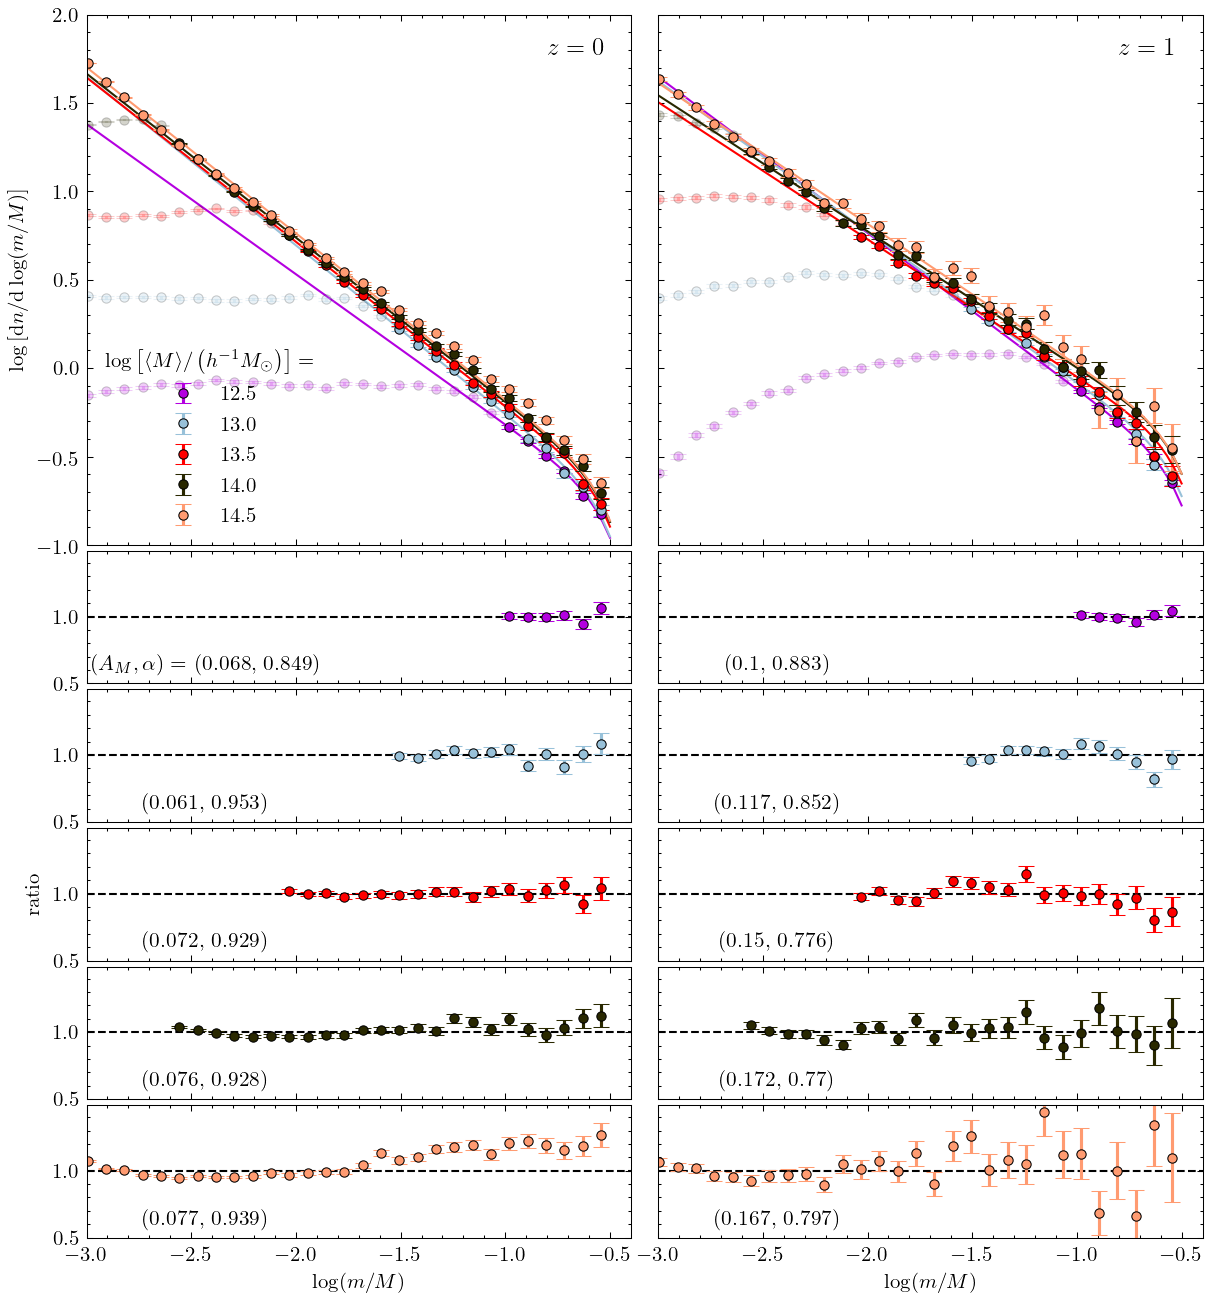

In [17]:
# beta=50, omega = 4. and a=1
# Remove 12 bin
# Paper 2 Eq 6 fitting for AM, alpha
# Host bins seperate fits
# fitting sigma

r = r_eq6
bins = 40
fig, axtup = plt.subplots(6, 2, sharex=True, sharey='row', gridspec_kw={'wspace': .05, 'width_ratios': [1, 1], 'hspace':.03, 'height_ratios': [4,1,1,1,1,1]}, figsize=[4.8*2,4.8*9/4])
popt_z = {0:[], 1:[]}

for z, m_bin_all, cc, centrals_mask, ax, axrtup in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]) ):
    for (bin_mask, Mavg, Nhalos), c, axr in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        
        popt, pcov = curve_fit(mass_fitting_fn_eq6, x[xmask], 10**(y[xmask]), sigma=yerr[xmask], p0=(0.058, 0.86))
        print(np.log10(Mavg), popt, np.sqrt(np.diag(pcov)))
        popt_z[z].append(popt)
        ax.plot(np.linspace(*r, 100), np.log10(mass_fitting_fn_eq6(np.linspace(*r, 100), *popt)), '-', color=c, lw=1)
    ax.set_xlim(-3,-0.4)
    ax.set_ylim(-1,2)

### ratio plot ###
for z, m_bin_all, cc, centrals_mask, ax, axrtup in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]) ):
    for (bin_mask, Mavg, Nhalos), c, axr, popt in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup, popt_z[z]):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(axr, x[xmask], 10**(y[xmask])/mass_fitting_fn_eq6(x[xmask], *popt), yerr=yerr[xmask]/mass_fitting_fn_eq6(x[xmask], *popt), c=c)
        axr.set_ylim(0.5, 1.49)
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
        axr.set_title((r'$(A_M, \alpha)=$ 'if axr==axtup[1,0] else '')+f'({round(popt[0],3)}, {round(popt[1],3)})', x=0.22, y=0, fontsize=10.2)

axtup[0,0].legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$', loc=3)
axtup[0,0].set_title('$z=0$', y=0.9, x=0.9)
axtup[0,1].set_title('$z=1$', y=0.9, x=0.9)
axtup[5,0].set_xlabel(r'$\log(m/M)$')
axtup[5,1].set_xlabel(r'$\log(m/M)$')
axtup[0,0].set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
axtup[3,0].set_ylabel('ratio')

# ax2.legend(handles=[ax2.plot([],[], '-', color='b', lw=2, label=r'Fit $(\gamma, \alpha, \beta, \omega, a)$:')[0],
#                     ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.031, -0.95, 50., 4.0, 1.0)$ $z=0$')[0],
#                    ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.058, -0.83, 50., 4.0, 1.0)$ $z=1$')[0]], 
#            loc=4, handlelength=1)#, title=r'Fit $(\gamma, \alpha, \beta, \omega, a)=$')

LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
[0.0655588 0.9623486] [0.00191729 0.0052128 ]
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354
[0.12477447 0.83457165] [0.00371264 0.00661158]
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354


Text(0, 0.5, 'ratio')

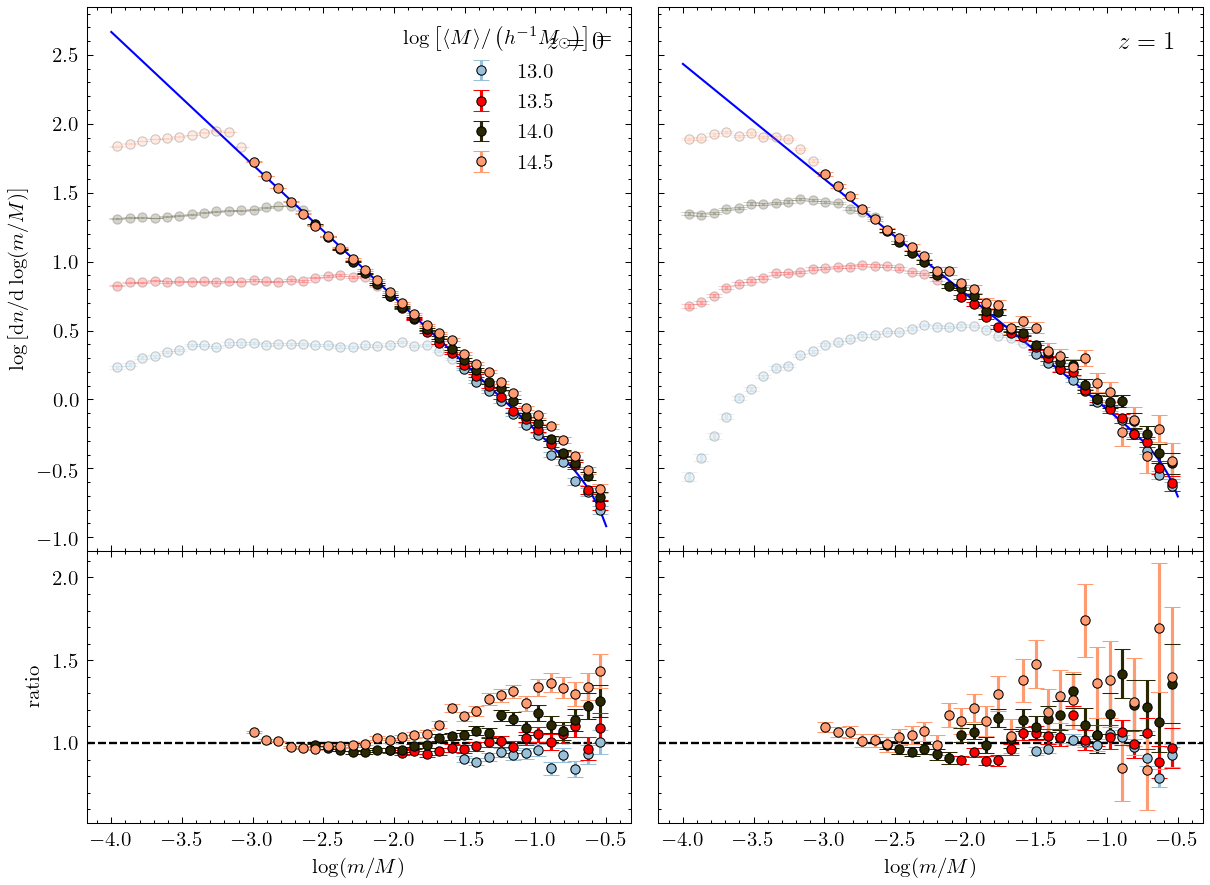

In [808]:
# beta=50, omega = 4. and a=1
# Remove 12 bin
# Paper 2 Eq 6 fitting for AM, alpha
# fitting sigma

r = r_eq6
bins = 40
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey='row', gridspec_kw={'wspace': .05, 'width_ratios': [1, 1], 'hspace':0, 'height_ratios': [2, 1]}, figsize=[4.8*2,4.8*1.5])
popt_z = []

for m_bin_all, cc, centrals_mask, ax, axr in zip( (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), (ax1,ax2), (ax3,ax4) ):
    x_fittingarr, y_fittingarr, sigma_fittingarr = [], [], []
    for (bin_mask, Mavg, Nhalos), c in zip(m_bin_all, COLOR_SCHEME):
        if round(np.log10(Mavg), 1)<=12.5:
            continue
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        x_fittingarr.append(x[xmask])
        y_fittingarr.append(y[xmask])
        sigma_fittingarr.append(yerr[xmask])
    x_fittingarr = np.concatenate(x_fittingarr)
    y_fittingarr = np.concatenate(y_fittingarr)
    sigma_fittingarr = np.concatenate(sigma_fittingarr)
    popt, pcov = curve_fit(mass_fitting_fn_eq6, x_fittingarr, 10**y_fittingarr, sigma=sigma_fittingarr, p0=(0.058, 0.86))
    print(popt, np.sqrt(np.diag(pcov)))
    popt_z.append(popt)
    ax.plot(np.linspace(*r, 100), np.log10(mass_fitting_fn_eq6(np.linspace(*r, 100), *popt)), '-', color='b', lw=1)

### ratio plot ###
for m_bin_all, cc, centrals_mask, ax, axr, popt in zip( (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), (ax1,ax2), (ax3,ax4), popt_z ):
    for (bin_mask, Mavg, Nhalos), c in zip(m_bin_all, COLOR_SCHEME):
        if round(np.log10(Mavg), 1)<=12.5:
            continue
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(axr, x[xmask], 10**(y[xmask])/mass_fitting_fn_eq6(x[xmask], *popt), yerr=yerr[xmask]/mass_fitting_fn_eq6(x[xmask], *popt), c=c)
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
    
ax1.legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$')
ax1.set_title('$z=0$', y=0.9, x=0.9)
ax2.set_title('$z=1$', y=0.9, x=0.9)
ax3.set_xlabel(r'$\log(m/M)$')
ax4.set_xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
ax3.set_ylabel('ratio')
# ax2.legend(handles=[ax2.plot([],[], '-', color='b', lw=2, label=r'Fit $(\gamma, \alpha, \beta, \omega, a)$:')[0],
#                     ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.031, -0.95, 50., 4.0, 1.0)$ $z=0$')[0],
#                    ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.058, -0.83, 50., 4.0, 1.0)$ $z=1$')[0]], 
#            loc=4, handlelength=1)#, title=r'Fit $(\gamma, \alpha, \beta, \omega, a)=$')

LJ nH cores 378420
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
[ 0.02922233 -0.93880448 12.00555848  2.66411403  0.90834805] [2.58526104e+04 1.58222867e-02 3.06334948e+07 1.17795351e+00
 8.55717466e+05]
LJ nH cores 343116
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354
[ 0.06719921 -0.79375939  5.94911018  1.89908142  0.95859491] [6.24637107e+04 2.30698235e-02 1.32677113e+07 7.16256183e-01
 1.12232303e+06]
LJ nH cores 378420
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)
/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


LJ nH cores 10018
LJ nH cores 10001
LJ nH cores 343116
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354


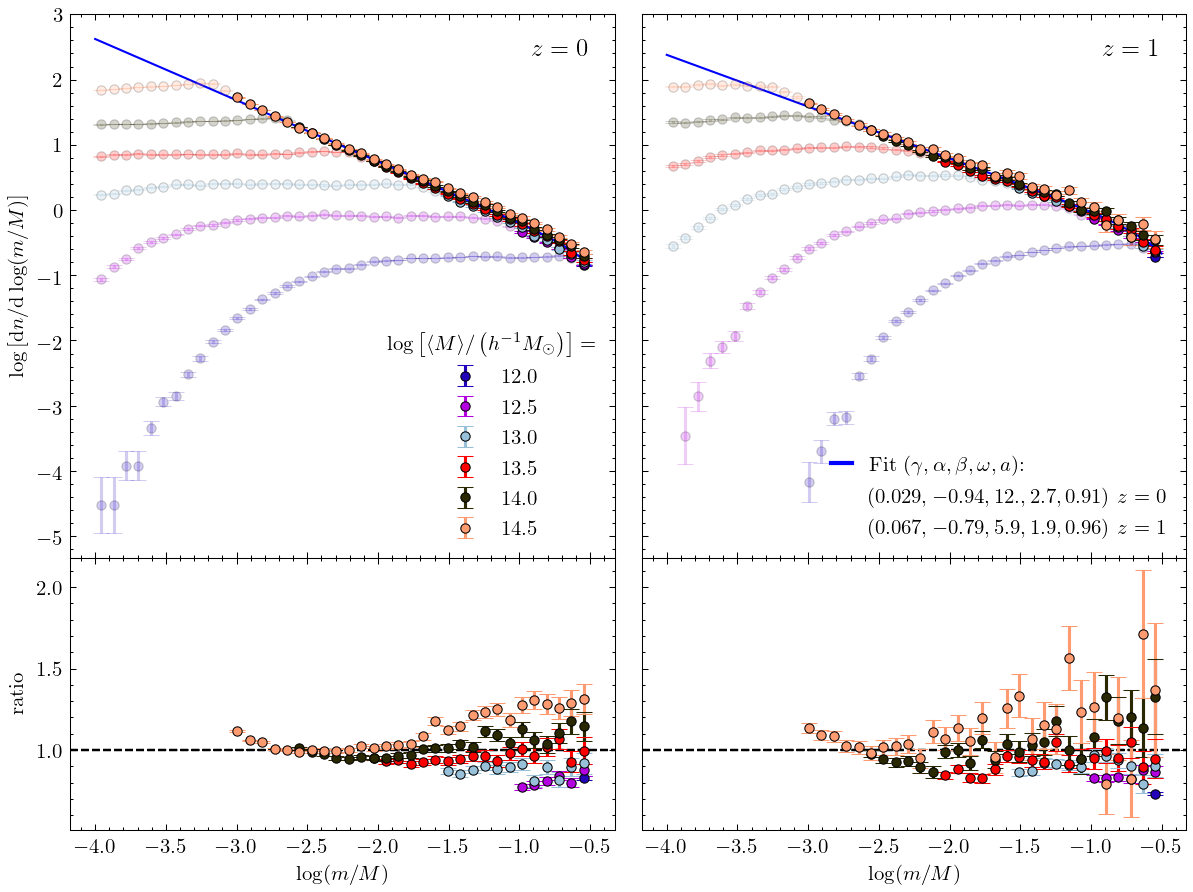

In [536]:
r = (-4,-0.5)
bins = 40
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey='row', gridspec_kw={'wspace': .05, 'width_ratios': [1, 1], 'hspace':0, 'height_ratios': [2, 1]}, figsize=[4.8*2,4.8*1.5])
popt_z = []

for m_bin_all, cc, centrals_mask, ax, axr in zip( (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), (ax1,ax2), (ax3,ax4) ):
    x_fittingarr, y_fittingarr = [], []
    for (bin_mask, Mavg, Nhalos), c in zip(m_bin_all, COLOR_SCHEME):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        x_fittingarr.append(x[xmask])
        y_fittingarr.append(y[xmask])
    x_fittingarr = np.concatenate(x_fittingarr)
    y_fittingarr = np.concatenate(y_fittingarr)
    popt, pcov = curve_fit(general_mass_fitting_fn, x_fittingarr, y_fittingarr, p0=(0.065, -0.86, 50.0, 4.0, 1.0))
    print(popt, np.sqrt(np.diag(pcov)))
    popt_z.append(popt)
    ax.plot(np.linspace(*r, 100), general_mass_fitting_fn(np.linspace(*r, 100), *popt), '-', color='b', lw=1)

### ratio plot ###
for m_bin_all, cc, centrals_mask, ax, axr, popt in zip( (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), (ax1,ax2), (ax3,ax4), popt_z ):
    for (bin_mask, Mavg, Nhalos), c in zip(m_bin_all, COLOR_SCHEME):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(axr, x[xmask], 10**(y[xmask]-general_mass_fitting_fn(x[xmask], *popt)), yerr=yerr[xmask]/10**general_mass_fitting_fn(x[xmask], *popt), c=c)
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
    
ax1.legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$')
ax1.set_title('$z=0$', y=0.9, x=0.9)
ax2.set_title('$z=1$', y=0.9, x=0.9)
ax3.set_xlabel(r'$\log(m/M)$')
ax4.set_xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
ax3.set_ylabel('ratio')
ax2.legend(handles=[ax2.plot([],[], '-', color='b', lw=2, label=r'Fit $(\gamma, \alpha, \beta, \omega, a)$:')[0],
                    ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.029, -0.94, 12., 2.7, 0.91)$ $z=0$')[0],
                   ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.067, -0.79, 5.9, 1.9, 0.96)$ $z=1$')[0]], 
           loc=4, handlelength=1)#, title=r'Fit $(\gamma, \alpha, \beta, \omega, a)=$')
# plt.savefig('Paper2Figs/massfn_LastJourney_alpha_fit.pdf')

LJ nH cores 378420
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
[ 0.02922233 -0.93880448 12.00555848  2.66411403  0.90834805] [2.58526104e+04 1.58222867e-02 3.06334948e+07 1.17795351e+00
 8.55717466e+05]
LJ nH cores 343116
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354
[ 0.06719921 -0.79375939  5.94911018  1.89908142  0.95859491] [6.24637107e+04 2.30698235e-02 1.32677113e+07 7.16256183e-01
 1.12232303e+06]


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)
/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


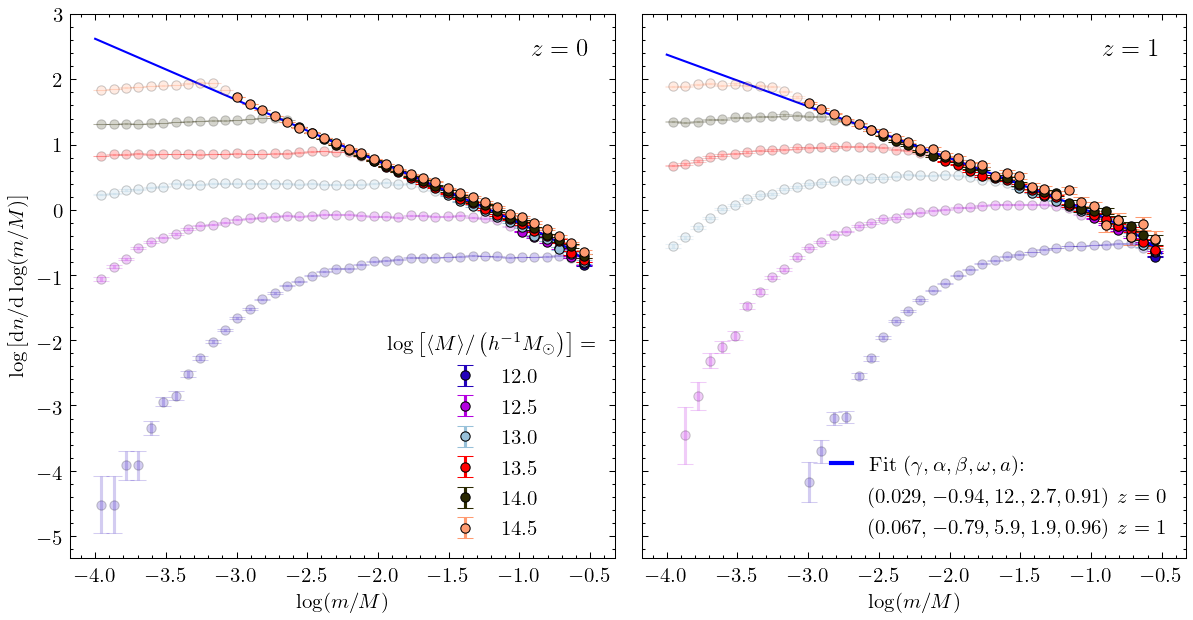

In [526]:
r = (-4,-0.5)
bins = 40
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, gridspec_kw={'wspace': .05, 'width_ratios': [1, 1]}, figsize=[4.8*2,4.8*1.])

for m_bin_all, cc, centrals_mask, ax in zip( (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), (ax1,ax2) ):
    x_fittingarr, y_fittingarr = [], []
    for (bin_mask, Mavg, Nhalos), c in zip(m_bin_all, COLOR_SCHEME):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        x_fittingarr.append(x[xmask])
        y_fittingarr.append(y[xmask])
    x_fittingarr = np.concatenate(x_fittingarr)
    y_fittingarr = np.concatenate(y_fittingarr)
    popt, pcov = curve_fit(general_mass_fitting_fn, x_fittingarr, y_fittingarr, p0=(0.065, -0.86, 50.0, 4.0, 1.0))
    print(popt, np.sqrt(np.diag(pcov)))
    ax.plot(np.linspace(*r, 100), general_mass_fitting_fn(np.linspace(*r, 100), *popt), '-', color='b', lw=1)

ax1.legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$')
ax1.set_title('$z=0$', y=0.9, x=0.9)
ax2.set_title('$z=1$', y=0.9, x=0.9)
ax1.set_xlabel(r'$\log(m/M)$')
ax2.set_xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
ax2.legend(handles=[ax2.plot([],[], '-', color='b', lw=2, label=r'Fit $(\gamma, \alpha, \beta, \omega, a)$:')[0],
                    ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.029, -0.94, 12., 2.7, 0.91)$ $z=0$')[0],
                   ax2.plot([],[], '-', color='w', lw=1, label=r'$(0.067, -0.79, 5.9, 1.9, 0.96)$ $z=1$')[0]], 
           loc=4, handlelength=1)#, title=r'Fit $(\gamma, \alpha, \beta, \omega, a)=$')
# plt.savefig('Paper2Figs/massfn_LastJourney_alpha_fit.pdf')

## Core mass function fitting (Mfof scaled to approx. Mvir)

In [95]:
m_bin_all0 = []
for lM in [12.0, 12.5, 13.0, 13.5, 14.0, 14.5]:
    m_bin_all0.append(hostbins(cc_LJ0, centrals_mask_LJ0, 10**lM, 10**(lM+0.5), verbose=True, s1=False, minHalosFlag=True))

Total host halos within mass threshold 112377773
Number of host halos in bin 4.51458e+05
Host halo mass bin size: 6.5536e+04
Number of infall halos: 142164
Hosts with no infall halos: 314178 (69.59185572079795%)

Total host halos within mass threshold 39639922
Number of host halos in bin 5.0964e+04
Host halo mass bin size: 2.62144e+05
Number of infall halos: 96528
Hosts with no infall halos: 3850 (7.5543520916725555%)

Total host halos within mass threshold 13355531
Number of host halos in bin 1.1305e+04
Host halo mass bin size: 2.9894902e+09
Number of infall halos: 74611
Hosts with no infall halos: 3 (0.026536930561693595%)

Total host halos within mass threshold 4069909
Number of host halos in bin 1.0565e+04
Host halo mass bin size: 5.081609e+10
Number of infall halos: 218097
Hosts with no infall halos: 0 (0.0%)

Total host halos within mass threshold 996745
Number of host halos in bin 1.0042e+04
Host halo mass bin size: 5.948446e+11
Number of infall halos: 640317
Hosts with no infal

In [96]:
m_bin_all1 = []
for lM in [12.0, 12.5, 13.0, 13.5, 14.0, 14.5]:
    m_bin_all1.append(hostbins(cc_LJ1, centrals_mask_LJ1, 10**lM, 10**(lM+0.5), verbose=True, s1=False, minHalosFlag=True))

Total host halos within mass threshold 102267290
Number of host halos in bin 4.25704e+05
Host halo mass bin size: 6.5536e+04
Number of infall halos: 124627
Hosts with no infall halos: 303707 (71.34229417623513%)

Total host halos within mass threshold 34410783
Number of host halos in bin 4.4167e+04
Host halo mass bin size: 2.62144e+05
Number of infall halos: 74731
Hosts with no infall halos: 6674 (15.110829352231303%)

Total host halos within mass threshold 13784159
Number of host halos in bin 1.0259e+04
Host halo mass bin size: 2.9894902e+09
Number of infall halos: 42479
Hosts with no infall halos: 3193 (31.12389121746759%)

Total host halos within mass threshold 5671110
Number of host halos in bin 1.0435e+04
Host halo mass bin size: 3.8860227e+10
Number of infall halos: 60102
Hosts with no infall halos: 6742 (64.60948730234787%)

Total host halos within mass threshold 1396956
Number of host halos in bin 1.0024e+04
Host halo mass bin size: 3.975529e+11
Number of infall halos: 64390
Ho

In [97]:
print('z=0')
for bin_mask, Mavg, Nhalos in m_bin_all0:
    print( 'logMavg', round(np.log10(Mavg), 1) )
    print('Mmin(1e12)', round(cc_LJ0['M'][bin_mask].min()/1.e12, 3))
    print('Mmax(1e12)', round(cc_LJ0['M'][bin_mask].max()/1.e12, 3))
    print('Nhalos', Nhalos)
    print()

print('z=1')
for bin_mask, Mavg, Nhalos in m_bin_all1:
    print( 'logMavg', round(np.log10(Mavg), 1) )
    print('Mmin(1e12)', round(cc_LJ1['M'][bin_mask].min()/1.e12, 3))
    print('Mmax(1e12)', round(cc_LJ1['M'][bin_mask].max()/1.e12, 3))
    print('Nhalos', Nhalos)
    print()

z=0
logMavg 12.0
Mmin(1e12) 1.001
Mmax(1e12) 1.001
Nhalos 451458

logMavg 12.5
Mmin(1e12) 3.163
Mmax(1e12) 3.163
Nhalos 50964

logMavg 13.0
Mmin(1e12) 10.002
Mmax(1e12) 10.005
Nhalos 11305

logMavg 13.5
Mmin(1e12) 31.625
Mmax(1e12) 31.676
Nhalos 10565

logMavg 14.0
Mmin(1e12) 100.002
Mmax(1e12) 100.596
Nhalos 10042

logMavg 14.5
Mmin(1e12) 316.23
Mmax(1e12) 326.372
Nhalos 10000

z=1
logMavg 12.0
Mmin(1e12) 1.001
Mmax(1e12) 1.001
Nhalos 414123

logMavg 12.5
Mmin(1e12) 3.163
Mmax(1e12) 3.163
Nhalos 40037

logMavg 13.0
Mmin(1e12) 10.002
Mmax(1e12) 10.005
Nhalos 6888

logMavg 13.5
Mmin(1e12) 31.625
Mmax(1e12) 31.664
Nhalos 3274

logMavg 14.0
Mmin(1e12) 100.002
Mmax(1e12) 100.399
Nhalos 1178

logMavg 14.5
Mmin(1e12) 316.269
Mmax(1e12) 327.669
Nhalos 383



LJ nH cores 50964
12.500031 [0.0542792  0.90899719] [0.0048922 0.0470659]
LJ nH cores 11305
13.000135 [0.05783599 0.92827894] [0.00234082 0.01415836]
LJ nH cores 10565
13.500382 [0.06675535 0.92010568] [0.00273417 0.01045458]
LJ nH cores 10042
14.001303 [0.07062477 0.92431065] [0.00250169 0.00701671]
LJ nH cores 10000
14.506861 [0.07244528 0.93253479] [0.00430238 0.00985897]
LJ nH cores 40037
12.500031 [0.06452417 1.04469376] [0.00613803 0.04931892]
LJ nH cores 6888
13.000136 [0.09769637 0.88866457] [0.00736784 0.02646705]
LJ nH cores 3274
13.500297 [0.14510002 0.76837223] [0.01490305 0.02678559]
LJ nH cores 1178
14.000848 [0.16145676 0.7643192 ] [0.01080121 0.01359231]
LJ nH cores 383
14.507367 [0.16333634 0.77935052] [0.01487947 0.01549009]
LJ nH cores 50964
LJ nH cores 11305
LJ nH cores 10565
LJ nH cores 10042
LJ nH cores 10000
LJ nH cores 40037
LJ nH cores 6888
LJ nH cores 3274
LJ nH cores 1178
LJ nH cores 383


/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)
/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


Text(0, 0.5, 'ratio')

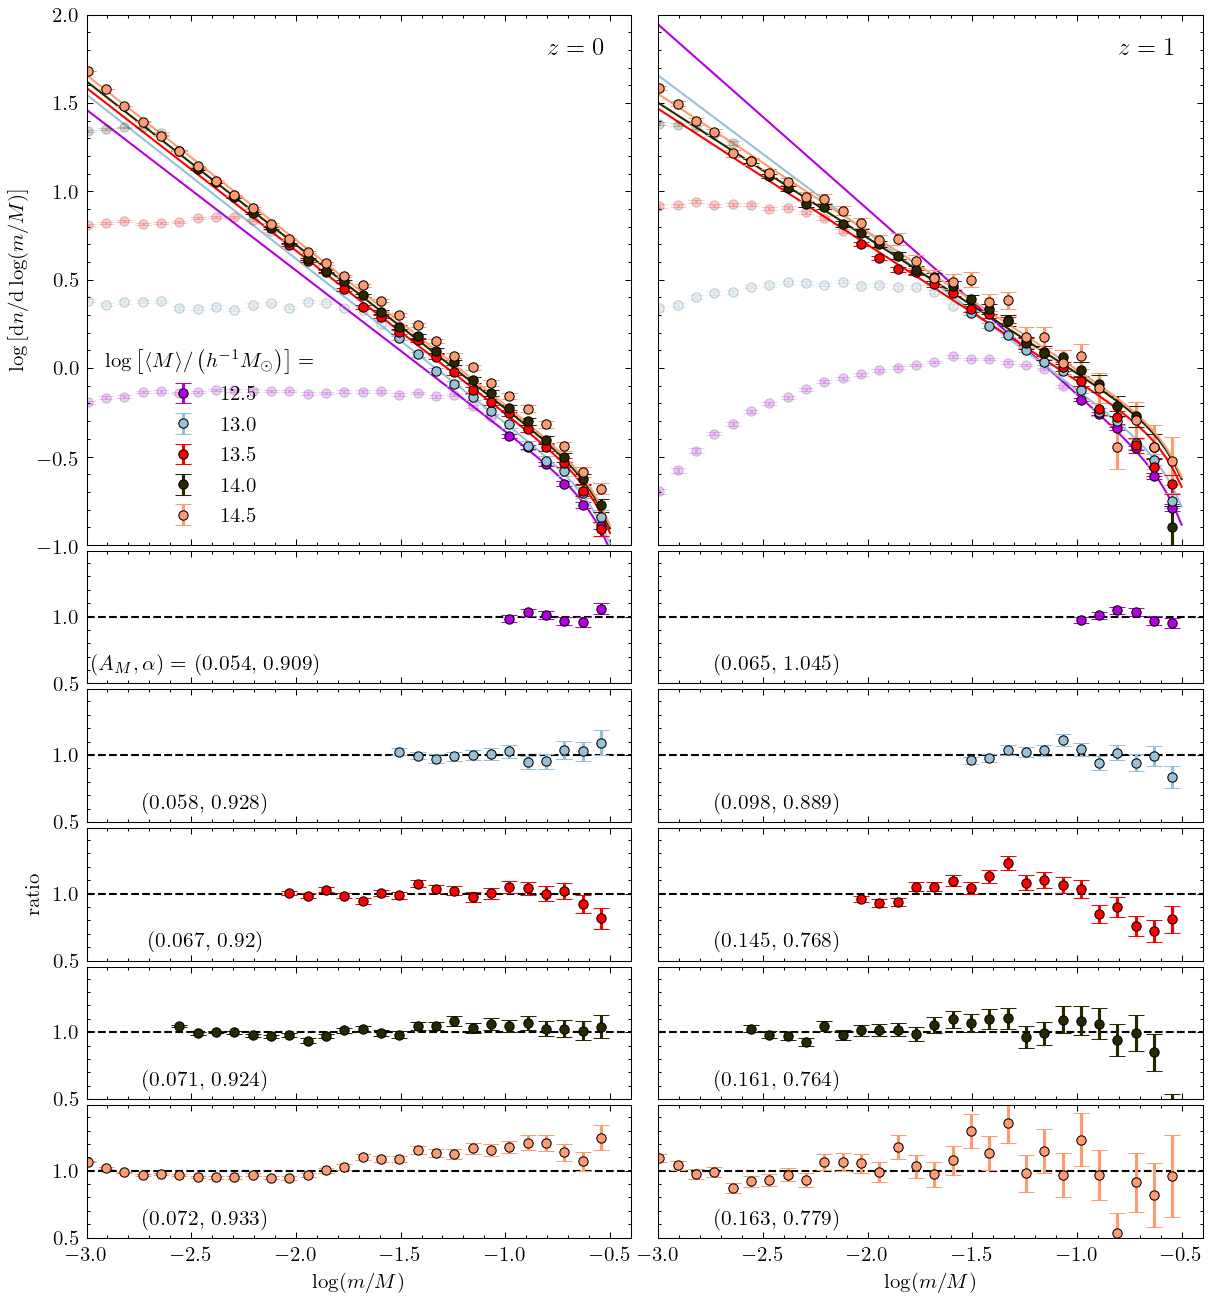

In [102]:
# beta=50, omega = 4. and a=1
# Remove 12 bin
# Paper 2 Eq 6 fitting for AM, alpha
# Host bins seperate fits
# fitting sigma

r = r_eq6
bins = 40
fig, axtup = plt.subplots(6, 2, sharex=True, sharey='row', gridspec_kw={'wspace': .05, 'width_ratios': [1, 1], 'hspace':.03, 'height_ratios': [4,1,1,1,1,1]}, figsize=[4.8*2,4.8*9/4])
popt_z = {0:[], 1:[]}

for z, m_bin_all, cc, centrals_mask, ax, axrtup in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]) ):
    for (bin_mask, Mavg, Nhalos), c, axr in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        
        popt, pcov = curve_fit(mass_fitting_fn_eq6, x[xmask], 10**(y[xmask]), sigma=yerr[xmask], p0=(0.058, 0.86))
        print(np.log10(Mavg), popt, np.sqrt(np.diag(pcov)))
        popt_z[z].append(popt)
        ax.plot(np.linspace(*r, 100), np.log10(mass_fitting_fn_eq6(np.linspace(*r, 100), *popt)), '-', color=c, lw=1)
    ax.set_xlim(-3,-0.4)
    ax.set_ylim(-1,2)

### ratio plot ###
for z, m_bin_all, cc, centrals_mask, ax, axrtup in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]) ):
    for (bin_mask, Mavg, Nhalos), c, axr, popt in zip(m_bin_all[1:], COLOR_SCHEME[1:], axrtup, popt_z[z]):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(axr, x[xmask], 10**(y[xmask])/mass_fitting_fn_eq6(x[xmask], *popt), yerr=yerr[xmask]/mass_fitting_fn_eq6(x[xmask], *popt), c=c)
        axr.set_ylim(0.5, 1.49)
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
        axr.set_title((r'$(A_M, \alpha)=$ 'if axr==axtup[1,0] else '')+f'({round(popt[0],3)}, {round(popt[1],3)})', x=0.22, y=0, fontsize=10.2)

axtup[0,0].legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$', loc=3)
axtup[0,0].set_title('$z=0$', y=0.9, x=0.9)
axtup[0,1].set_title('$z=1$', y=0.9, x=0.9)
axtup[5,0].set_xlabel(r'$\log(m/M)$')
axtup[5,1].set_xlabel(r'$\log(m/M)$')
axtup[0,0].set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
axtup[3,0].set_ylabel('ratio')

## Core mass function fitting (wide mass bins)

In [82]:
m_bin_all0 = []
for lM in [12.5, 13.0, 13.5, 14.0, 14.5]:
    m_bin_all0.append(hostbins_wide(cc_LJ0, centrals_mask_LJ0, 10**lM, 10**(lM+0.5), verbose=True, s1=False, Nhalos=-1))

Total host halos within mass threshold 36298650
Number of host halos in bin 3.629865e+07
Host halo mass bin size: 6.834253e+12
Number of infall halos: 137868214
Hosts with no infall halos: 557392 (1.5355722595743915%)

Total host halos within mass threshold 12163595
Number of host halos in bin 1.2163595e+07
Host halo mass bin size: 2.1622325e+13
Number of infall halos: 148564207
Hosts with no infall halos: 99 (0.0008139041130506008%)

Total host halos within mass threshold 3662069
Number of host halos in bin 3.662069e+06
Host halo mass bin size: 6.8372423e+13
Number of infall halos: 135938370
Hosts with no infall halos: 0 (0.0%)

Total host halos within mass threshold 872353
Number of host halos in bin 8.72353e+05
Host halo mass bin size: 2.16226e+14
Number of infall halos: 96960072
Hosts with no infall halos: 0 (0.0%)

Total host halos within mass threshold 125476
Number of host halos in bin 1.25476e+05
Host halo mass bin size: 6.837675e+14
Number of infall halos: 40630403
Hosts with 

In [83]:
m_bin_all1 = []
for lM in [12.5, 13.0, 13.5, 14.0, 14.5]:
    m_bin_all1.append(hostbins_wide(cc_LJ1, centrals_mask_LJ1, 10**lM, 10**(lM+0.5), verbose=True, s1=False, Nhalos=-1))

Total host halos within mass threshold 31619194
Number of host halos in bin 3.1619194e+07
Host halo mass bin size: 6.834253e+12
Number of infall halos: 91031999
Hosts with no infall halos: 6093665 (19.272044062856253%)

Total host halos within mass threshold 12876430
Number of host halos in bin 1.287643e+07
Host halo mass bin size: 2.1622325e+13
Number of infall halos: 66292609
Hosts with no infall halos: 6324126 (49.113970254177595%)

Total host halos within mass threshold 5193612
Number of host halos in bin 5.193612e+06
Host halo mass bin size: 6.8372415e+13
Number of infall halos: 31991725
Hosts with no infall halos: 3822471 (73.59947181268065%)

Total host halos within mass threshold 1190506
Number of host halos in bin 1.190506e+06
Host halo mass bin size: 2.162205e+14
Number of infall halos: 7615196
Hosts with no infall halos: 979995 (82.31751876933002%)

Total host halos within mass threshold 69557
Number of host halos in bin 6.9557e+04
Host halo mass bin size: 6.322701e+14
Numbe

In [92]:
print('z=0')
for bin_mask, Mavg, Nhalos in m_bin_all0:
    print( 'logMavg', round(np.log10(Mavg), 1) )
    print('Mmin(1e12)', round(cc_LJ0['M'][bin_mask].min()/1.e12, 3))
    print('Mmax(1e12)', round(cc_LJ0['M'][bin_mask].max()/1.e12, 3))
    print('logMmin', round(np.log10(cc_LJ0['M'][bin_mask].min()), 3))
    print('logMmax', round(np.log10(cc_LJ0['M'][bin_mask].max()), 3))
    print('Nhalos', Nhalos)
    print()

print('z=1')
for bin_mask, Mavg, Nhalos in m_bin_all1:
    print( 'logMavg', round(np.log10(Mavg), 1) )
    print('Mmin(1e12)', round(cc_LJ1['M'][bin_mask].min()/1.e12, 3))
    print('Mmax(1e12)', round(cc_LJ1['M'][bin_mask].max()/1.e12, 3))
    print('logMmin', round(np.log10(cc_LJ1['M'][bin_mask].min()), 3))
    print('logMmax', round(np.log10(cc_LJ1['M'][bin_mask].max()), 3))
    print('Nhalos', Nhalos)
    print()

z=0
logMavg 12.7
Mmin(1e12) 3.163
Mmax(1e12) 9.997
logMmin 12.5
logMmax 13.0
Nhalos 36298650

logMavg 13.2
Mmin(1e12) 10.0
Mmax(1e12) 31.622
logMmin 13.0
logMmax 13.5
Nhalos 12163595

logMavg 13.7
Mmin(1e12) 31.625
Mmax(1e12) 99.997
logMmin 13.5
logMmax 14.0
Nhalos 3662069

logMavg 14.2
Mmin(1e12) 100.0
Mmax(1e12) 316.226
logMmin 14.0
logMmax 14.5
Nhalos 872353

logMavg 14.7
Mmin(1e12) 316.229
Mmax(1e12) 999.996
logMmin 14.5
logMmax 15.0
Nhalos 125476

z=1
logMavg 12.7
Mmin(1e12) 3.163
Mmax(1e12) 9.997
logMmin 12.5
logMmax 13.0
Nhalos 25542530

logMavg 13.2
Mmin(1e12) 10.0
Mmax(1e12) 31.622
logMmin 13.0
logMmax 13.5
Nhalos 6202362

logMavg 13.7
Mmin(1e12) 31.625
Mmax(1e12) 99.997
logMmin 13.5
logMmax 14.0
Nhalos 1062663

logMavg 14.2
Mmin(1e12) 100.0
Mmax(1e12) 316.221
logMmin 14.0
logMmax 14.5
Nhalos 91944

logMavg 14.6
Mmin(1e12) 316.245
Mmax(1e12) 948.515
logMmin 14.5
logMmax 14.977
Nhalos 1988



LJ nH cores 36298650
12.729775 [0.06205939 0.92218321] [0.00212699 0.0144719 ]
LJ nH cores 12163595
13.226663 [0.06967433 0.91877749] [0.00105518 0.00448691]
LJ nH cores 3662069
13.720165 [0.07749166 0.91419822] [0.00136654 0.004117  ]
LJ nH cores 872353
14.205628 [0.0774349  0.93047204] [0.00339709 0.00806754]
LJ nH cores 125476
14.675253 [0.06924973 0.96014756] [0.00541272 0.01213801]
LJ nH cores 25542530
12.719326 [0.10074518 0.89845427] [0.00242291 0.01017199]
LJ nH cores 6202362
13.208923 [0.1436301  0.78756926] [0.00738941 0.0155103 ]
LJ nH cores 1062663
13.689038 [0.17646665 0.74705957] [0.00719793 0.00977681]
LJ nH cores 91944
14.152426 [0.18459449 0.75906737] [0.00789632 0.00838751]
LJ nH cores 1988
14.601647 [0.14938202 0.82164869] [0.01265271 0.01342811]
LJ nH cores 36298650
LJ nH cores 12163595
LJ nH cores 3662069
LJ nH cores 872353
LJ nH cores 125476
LJ nH cores 25542530
LJ nH cores 6202362
LJ nH cores 1062663
LJ nH cores 91944
LJ nH cores 1988


Text(0, 0.5, 'ratio')

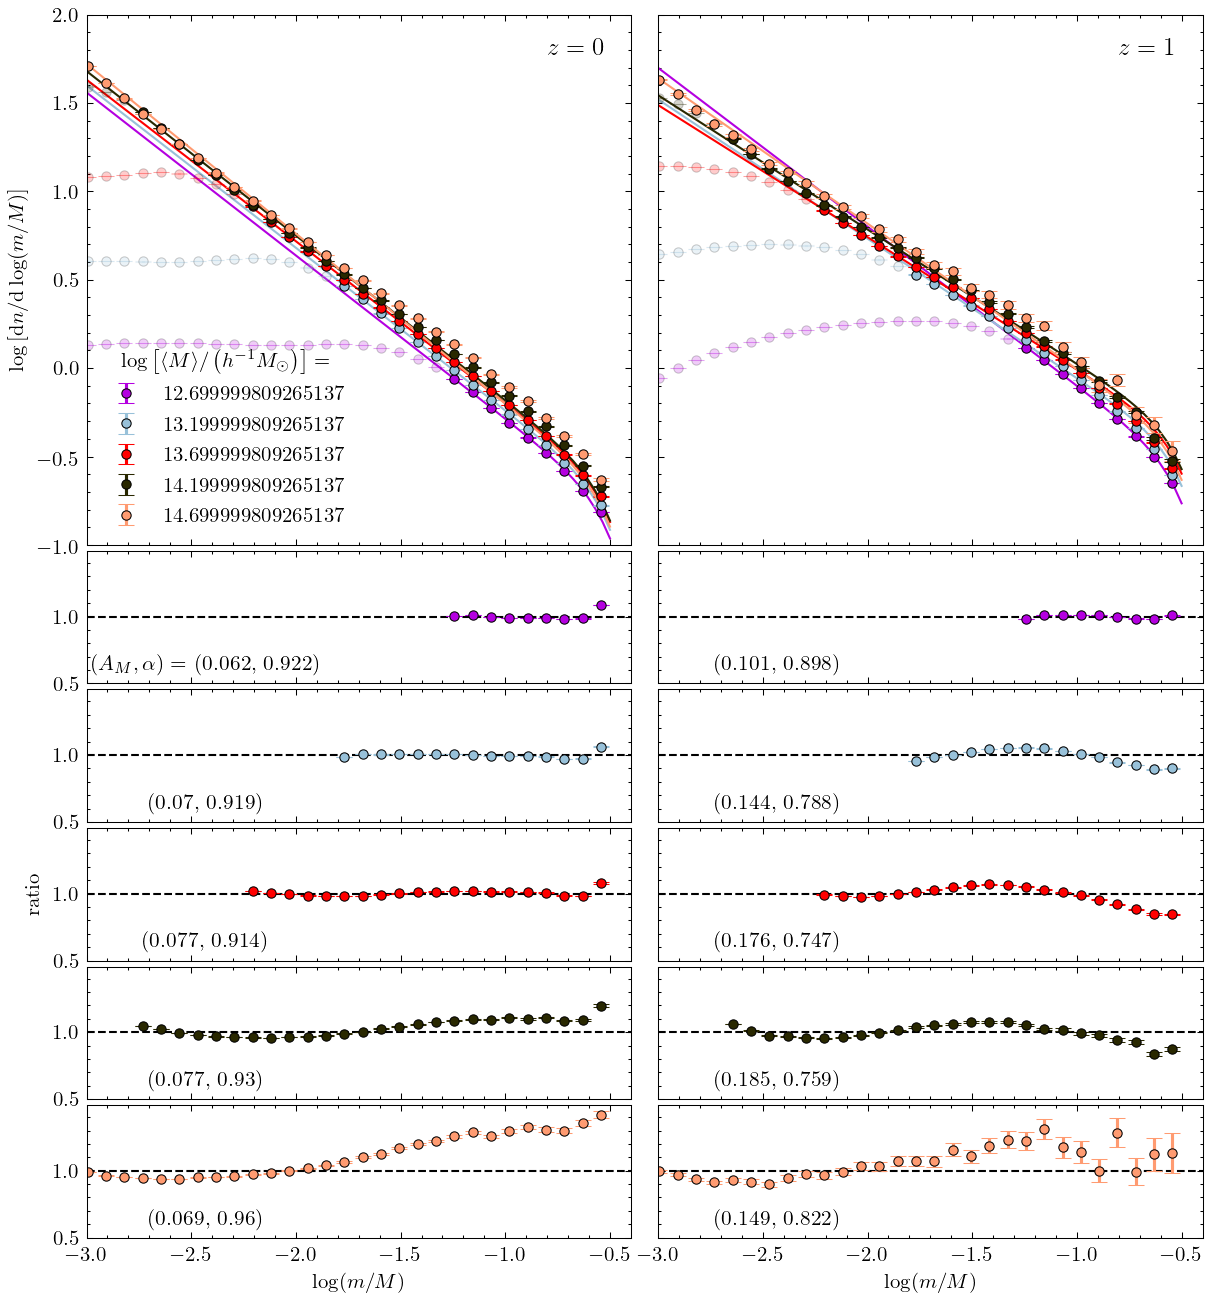

In [90]:
# beta=50, omega = 4. and a=1
# Remove 12 bin
# Paper 2 Eq 6 fitting for AM, alpha
# Host bins seperate fits
# fitting sigma

r = r_eq6
bins = 40
fig, axtup = plt.subplots(6, 2, sharex=True, sharey='row', gridspec_kw={'wspace': .05, 'width_ratios': [1, 1], 'hspace':.03, 'height_ratios': [4,1,1,1,1,1]}, figsize=[4.8*2,4.8*9/4])
popt_z = {0:[], 1:[]}

for z, m_bin_all, cc, centrals_mask, ax, axrtup in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]) ):
    for (bin_mask, Mavg, Nhalos), c, axr in zip(m_bin_all[0:], COLOR_SCHEME[1:], axrtup):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
        
        popt, pcov = curve_fit(mass_fitting_fn_eq6, x[xmask], 10**(y[xmask]), sigma=yerr[xmask], p0=(0.058, 0.86))
        print(np.log10(Mavg), popt, np.sqrt(np.diag(pcov)))
        popt_z[z].append(popt)
        ax.plot(np.linspace(*r, 100), np.log10(mass_fitting_fn_eq6(np.linspace(*r, 100), *popt)), '-', color=c, lw=1)
    ax.set_xlim(-3,-0.4)
    ax.set_ylim(-1,2)

### ratio plot ###
for z, m_bin_all, cc, centrals_mask, ax, axrtup in zip( (0,1), (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), axtup[0], (axtup[1:,0], axtup[1:,1]) ):
    for (bin_mask, Mavg, Nhalos), c, axr, popt in zip(m_bin_all[0:], COLOR_SCHEME[1:], axrtup, popt_z[z]):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(axr, x[xmask], 10**(y[xmask])/mass_fitting_fn_eq6(x[xmask], *popt), yerr=yerr[xmask]/mass_fitting_fn_eq6(x[xmask], *popt), c=c)
        axr.set_ylim(0.5, 1.49)
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
        axr.set_title((r'$(A_M, \alpha)=$ 'if axr==axtup[1,0] else '')+f'({round(popt[0],3)}, {round(popt[1],3)})', x=0.22, y=0, fontsize=10.2)

axtup[0,0].legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$', loc=3)
axtup[0,0].set_title('$z=0$', y=0.9, x=0.9)
axtup[0,1].set_title('$z=1$', y=0.9, x=0.9)
axtup[5,0].set_xlabel(r'$\log(m/M)$')
axtup[5,1].set_xlabel(r'$\log(m/M)$')
axtup[0,0].set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
axtup[3,0].set_ylabel('ratio')

## Core evolved mass plots

LJ nH cores 378420
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
LJ nH cores 343116
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354


/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


Text(0, 0.5, '$\\log \\left[ \\mathrm{d}n/\\mathrm{d} \\log(m/M) \\right]$')

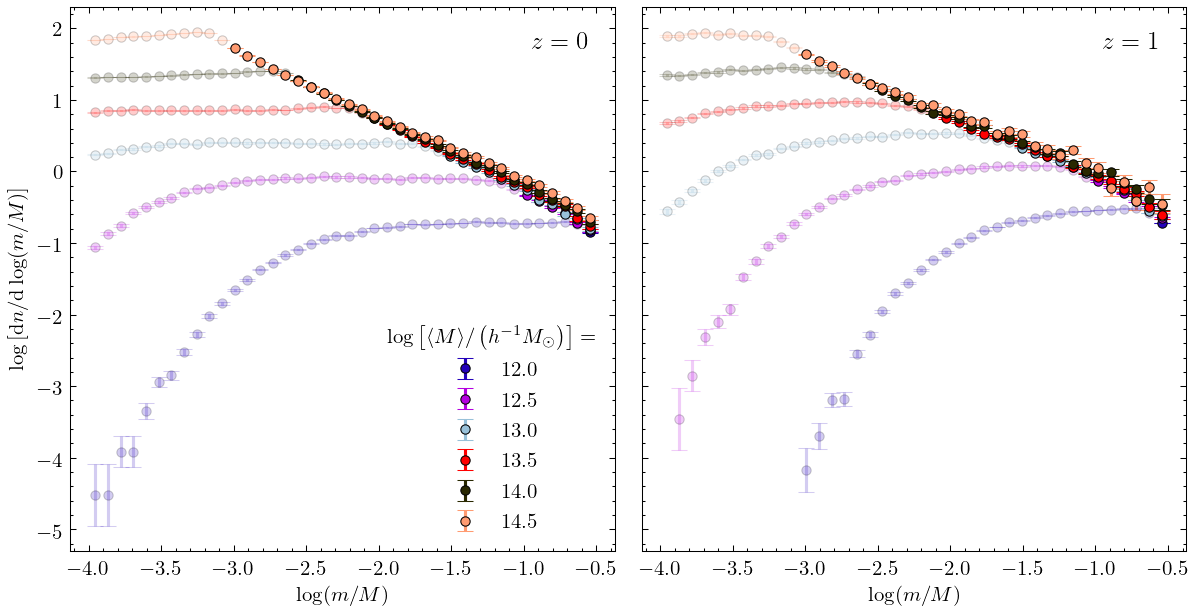

In [376]:
r = (-4,-0.5) #(-3,-0.4)
bins = 40
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, gridspec_kw={'wspace': .05, 'width_ratios': [1, 1]}, figsize=[4.8*2,4.8*1.])

for m_bin_all, cc, centrals_mask, ax in zip( (m_bin_all0,m_bin_all1), (cc_LJ0,cc_LJ1), (centrals_mask_LJ0,centrals_mask_LJ1), (ax1,ax2) ):
    for (bin_mask, Mavg, Nhalos), c in zip(m_bin_all, COLOR_SCHEME):
        x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
        xmask = x > np.log10(OBJECTMASSCUT['LJ']/Mavg)
        errorbar(ax, x[xmask], y[xmask], yerr=yerr_log[xmask], label='{}'.format(round(np.log10(Mavg), 1)), c=c, alpha=1.0)
        errorbar(ax, x[~xmask], y[~xmask], yerr=yerr_log[~xmask], c=c, alpha=0.2)
# ax1.set_xlim(-3, -0.5)
# ax1.set_ylim(-1,1.5)
# ax1.set_xlim(r)
ax1.legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$')
ax1.set_title('$z=0$', y=0.9, x=0.9)
ax2.set_title('$z=1$', y=0.9, x=0.9)
ax1.set_xlabel(r'$\log(m/M)$')
ax2.set_xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
# plt.savefig('Paper2Figs/massfn_LastJourney_alpha.pdf')

LJ nH cores 378420
LJ nH cores 42640
LJ nH cores 14303
LJ nH cores 10102
LJ nH cores 10018
LJ nH cores 10001
LJ nH cores 343116
LJ nH cores 32902
LJ nH cores 8365
LJ nH cores 2929
LJ nH cores 1093
LJ nH cores 354


Text(0, 0.5, '$\\log \\left[ \\mathrm{d}n/\\mathrm{d} \\log(m/M) \\right]$')

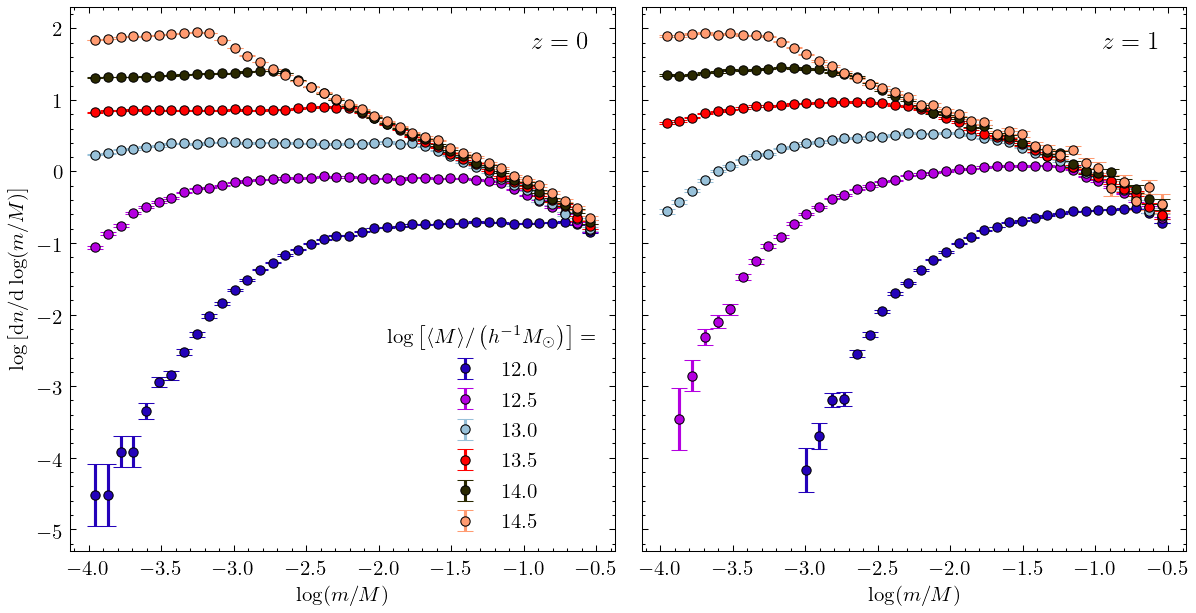

In [383]:
r = (-4,-0.5) #(-3,-0.4)
bins = 40
alpha=1.
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, gridspec_kw={'wspace': .05, 'width_ratios': [1, 1]}, figsize=[4.8*2,4.8*1.])

for bin_mask, Mavg, Nhalos in m_bin_all0:
    x, y, yerr, yerr_log, nH_cores = cores_plot(cc_LJ0, centrals_mask_LJ0, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
    errorbar(ax1, x, y, yerr=yerr_log, label='{}'.format(round(np.log10(Mavg), 1)), alpha=alpha)
for bin_mask, Mavg, Nhalos in m_bin_all1:
    x, y, yerr, yerr_log, nH_cores = cores_plot(cc_LJ1, centrals_mask_LJ1, M1=None, M2=None, label='LJ', bins=bins, r=r, bin_mask=bin_mask, nH_cores=Nhalos)
    errorbar(ax2, x, y, yerr=yerr_log, label='{}'.format(round(np.log10(Mavg), 1)), alpha=alpha)
# ax1.set_xlim(-3, -0.5)
# ax1.set_ylim(-1,1.5)
# ax1.set_xlim(r)
ax1.legend(title=r'$\log \left[ \langle M \rangle / \left(h^{{-1}}M_\odot \right) \right]=$')
ax1.set_title('$z=0$', y=0.9, x=0.9)
ax2.set_title('$z=1$', y=0.9, x=0.9)
ax1.set_xlabel(r'$\log(m/M)$')
ax2.set_xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
# plt.savefig('Paper2Figs/massfn_LastJourney.pdf')

SV nH cores 103359935

AlphaQ nH cores 88354142

(-0.07628945749701245, 1.628204645595558)


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:190: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


SV nH cores 12163595


/home/isultan/projects/itk/itk.py:101: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:117: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)



AlphaQ nH cores 6202362

(0.3719535306213498, 1.6264241717234162)


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in subtract
/home/isultan/projects/itk/itk.py:186: RuntimeWarning: invalid value encountered in true_divide
  return np.sqrt( (nerr/nfid)**2 + (n*nfiderr/nfid**2)**2 )


SV nH cores 872353

AlphaQ nH cores 91944

(0.3527564995824052, 1.567473682360266)


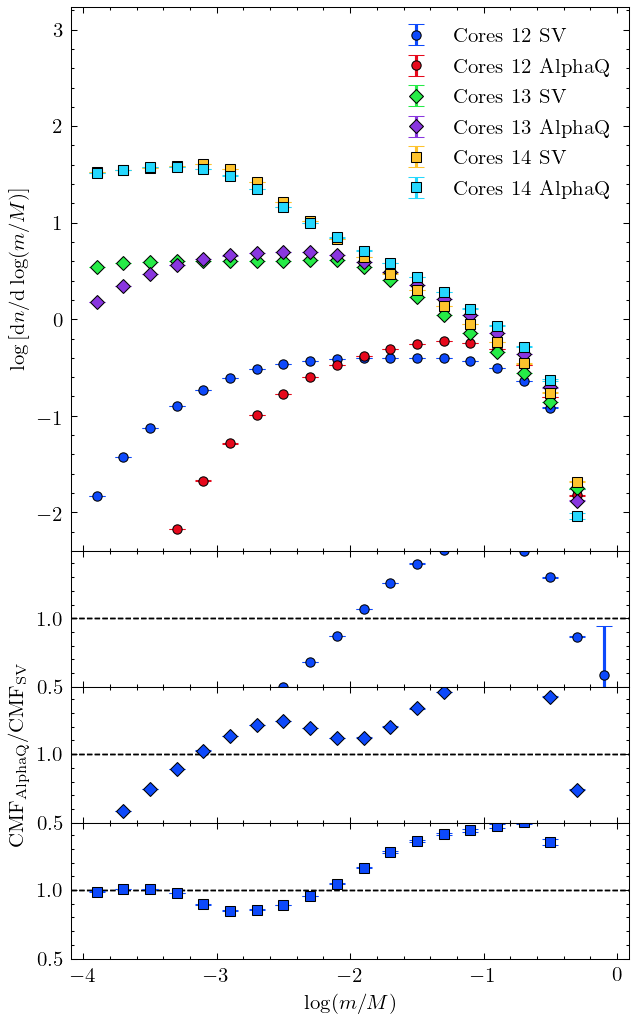

In [14]:
cosmology_tests(cc_LJ0, centrals_mask_LJ0, cc_LJ1, centrals_mask_LJ1)

# Fragment tests

In [ ]:
paramscan_resolution_tests(cc_HM1, sh_HM1, centrals_mask_HM1, cc_SV1, sh_SV1, centrals_mask_SV1, mplot=True, outfile='/home/isultan/projects/halomassloss/core_catalog_mevolved/Paper2Figs/paramexploration_mplot/z1_ccMtn/z1', ccMvar='Mtn')

In [45]:
np.sum((cc_HM1['fof_halo_tag']<0)&(centrals_mask_HM1))/np.sum(centrals_mask_HM1)*100

22.004982674945513

In [51]:
tmask = (cc_HM1['fof_halo_tag']>=0)&centrals_mask_HM1
np.array_equal( cc_HM1['infall_fof_halo_mass'][tmask], cc_HM1['infall_tree_node_mass'][tmask] )

True

In [64]:
tmask = (cc_HM1['fof_halo_tag']>=0)&centrals_mask_HM1
print np.array_equal( cc_HM1['infall_fof_halo_mass'][tmask], cc_HM1['infall_tree_node_mass'][tmask] )

print np.format_float_scientific( cc_HM1['infall_fof_halo_mass'][tmask].max() )
print np.format_float_scientific( cc_HM1['infall_tree_node_mass'][tmask].max() )

True
1.294977e+12
1.294977e+12


In [65]:
for logM1 in [12., 13., 14.]:
    M1, M2= 10**logM1, 10**(logM1+0.5)
    
    print np.sum( (M1<=cc_HM1['infall_fof_halo_mass'][tmask])&(cc_HM1['infall_fof_halo_mass'][tmask]<=M2) )
    print np.sum( (M1<=cc_HM1['infall_tree_node_mass'][tmask])&(cc_HM1['infall_tree_node_mass'][tmask]<=M2) )
    
    bin_mask = (~centrals_mask_HM1)&(M1 <= cc_HM1['M'])&(cc_HM1['M'] <= M2)
    print "non fragment satellite cores", np.sum((cc_HM1['fof_halo_tag'][~centrals_mask_HM1]>=0))/np.sum(~centrals_mask_HM1)
    print "non fragments count in mass bin", np.sum((~centrals_mask_HM1)&(M1 <= cc_HM1['M'])&(cc_HM1['M'] <= M2)&(cc_HM1['fof_halo_tag']>=0))
    
    print ''

1
1
non fragment satellite cores 0.19526844134090154
non fragments count in mass bin 52

0
0
non fragment satellite cores 0.19526844134090154
non fragments count in mass bin 0

0
0
non fragment satellite cores 0.19526844134090154
non fragments count in mass bin 0



# Core mass loss tests

In [59]:
np.mean((cc_SV0['infall_fof_halo_mass']/cc_SV0['infall_tree_node_mass'])[~centrals_mask_SV0])

4.1116014

In [107]:
M1, M2 = 10**14, 10**15

In [111]:
r_m_mi = (cc_SV0['m_evolved_1.1_0.1']/cc_SV0['infall_tree_node_mass'])[(~centrals_mask_SV0)
                                                                       &(M1<=cc_SV0['M'])&(cc_SV0['M']<=M2)]

In [112]:
(r_m_mi<0.01).sum()/len(r_m_mi)*100

26.063031983726976

In [113]:
r_m_mi_cut = (cc_SV0['m_evolved_1.1_0.1']/cc_SV0['infall_tree_node_mass'])[(~centrals_mask_SV0)
                                                              &(M1<=cc_SV0['M'])&(cc_SV0['M']<=M2)
                                            &(cc_SV0['m_evolved_1.1_0.1']>OBJECTMASSCUT['SV'])]

In [114]:
(r_m_mi_cut<0.01).sum()/len(r_m_mi_cut)*100

0.06513243595310464

In [115]:
np.log10(100*100*PARTICLEMASS['SV'])

13.09760432887441

# HM and SV SHMF fitting (z=0)

In [69]:
SV_masscuts = {}
for binwidth in (1.0, 0.5, 0.2, 0.1):
    SV_masscuts[binwidth] = {}
    for logM1 in (12.0, 13.0, 14.0):
        M1, M2 = 10**logM1, 10**(logM1+binwidth)
        x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh, Mavg_sh = subhalo_plot(sh_SV0, M1, M2, 'SV', 40, (-5,-0.5), mlim=SUBHALOMINMASS['SV'], returnMavg=True, mplot=False)
        SV_masscuts[binwidth][logM1] = np.log10(100*PARTICLEMASS['SV']/Mavg_sh)

SV nH_sh 54914
Mavg (sh centrals): 2.6633052e+12
SV nH_sh 6197
Mavg (sh centrals): 2.4771652e+13
SV nH_sh 384
Mavg (sh centrals): 2.073048e+14
SV nH_sh 40628
Mavg (sh centrals): 1.7033924e+12
SV nH_sh 4797
Mavg (sh centrals): 1.6754462e+13
SV nH_sh 337
Mavg (sh centrals): 1.6433545e+14
SV nH_sh 21293
Mavg (sh centrals): 1.2516449e+12
SV nH_sh 2650
Mavg (sh centrals): 1.2461279e+13
SV nH_sh 199
Mavg (sh centrals): 1.2464723e+14
SV nH_sh 11689
Mavg (sh centrals): 1.120064e+12
SV nH_sh 1487
Mavg (sh centrals): 1.1188264e+13
SV nH_sh 113
Mavg (sh centrals): 1.1170871e+14


In [70]:
SHMF_fitting_SVcut = {'HM':{}, 'SV':{}}
CMF_fitting_SVcut = {'HM':{}, 'SV':{}}

SHMF_fitting_HMcut = {'HM':{}, 'SV':{}}
CMF_fitting_HMcut = {'HM':{}, 'SV':{}}

In [71]:
def HM_SHMF_fitting(cc_HM, sh_HM, centrals_mask_HM, cc_SV, sh_SV, centrals_mask_SV, mplot=False, A=None, zeta=None, ccMvar='M', fixedAxis=True, zlabel=None, binwidth=0.5):
    r = (9,13) if mplot else (-5,-0.5)
    bins = 40

    fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='all', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0, 'height_ratios': [2, 1]}, figsize=[4.8*3,4.8*1.5], dpi=150)
    for logM1, ax, axr in zip((12, 13, 14), (ax1, ax2, ax3), (ax4, ax5, ax6)):
        yfid = 'HM'
        yerrfid = None
        M1, M2 = 10**logM1, 10**(logM1+binwidth)
        ax.set_title(r'{} $\le \log \left[ M / \left(h^{{-1}}M_\odot \right) \right] \le$ {}'.format(logM1+0.0, logM1+binwidth), y=0.9)

        for cc, sh, centrals_mask, label, marker, c in zip([cc_HM, cc_SV], [sh_HM, sh_SV], [centrals_mask_HM, centrals_mask_SV], ['HM', 'SV'], ['s', 'o'], ['#2402ba', '#98c1d9']):
            x, y, yerr, yerr_log, nH_cores, Mavg = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=SUBHALOMINMASS[label], returnMavg=True, mplot=mplot, A=A, zeta=zeta, Mvar=ccMvar)
            errorbar(ax, x, y, yerr=yerr_log, label='Cores '+label, marker=marker)

            x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh, Mavg_sh = subhalo_plot(sh, M1, M2, label, bins, r, mlim=SUBHALOMINMASS[label], returnMavg=True, mplot=mplot)
            errorbar(ax, x_sh, y_sh, yerr=yerr_log_sh, label='Subhalos '+label, marker=marker)

            print(reldif(Mavg, Mavg_sh)*100., 'percent relative difference between Mavg_cores and Mavh_sh')

            print('')
            if ccMvar!='Mtn':
                assert nH_cores == nH_sh

            if yfid == label:
                yfid = y_sh
                yerrfid = yerr_sh

            errorbar(axr, x, 10**(y-yfid), yerr=nratioerr(10**y, yerr, 10**yfid, yerrfid), marker=marker, c=c, zerocut=True)
            axr.axhline(1, c='k',ls='--', lw=1, zorder=-1)

            #ax.axvline( np.log10(SUBHALOMINMASS[label]/np.max(sh['M'][bin_mask_sh])), label=r'$\log \mathrm{m_{sh,min}/M_{max}}$ '+label, c='k' )
            if mplot:
                ax.axvline(  np.log10(100*PARTICLEMASS[label]), ymax=1., ls='--', c=c )
                axr.axvline( np.log10(100*PARTICLEMASS[label]), ls='--', label=r'$\log \left(\mathrm{100m_{p,'+label+ r'}}\right)$', c=c )
            elif label=='SV':
                # old Mavg_sh = np.mean(sh['M'][bin_mask_sh])
                ax.axvline(  np.log10(100*PARTICLEMASS[label]/Mavg_sh), ymax=1., ls='--', c=c )
                axr.axvline( np.log10(100*PARTICLEMASS[label]/Mavg_sh), ls='--', label=r'$\log \left(\mathrm{100m_{p,'+label+ r'}/\langle M \rangle}\right)$', c=c )
                assert np.log10(100*PARTICLEMASS[label]/Mavg_sh) == SV_masscuts[binwidth][logM1]
            ### Fitting to Equation 1 ###
            assert np.array_equal(x, x_sh)
            print('Fitting SV cut, binwidth=', binwidth)
            xmask_fitting = x > SV_masscuts[binwidth][logM1]
            
            popt, pcov = curve_fit(mass_fitting_fn_eq6, x_sh[xmask_fitting], 10**(y_sh[xmask_fitting]), sigma=yerr_sh[xmask_fitting], p0=(0.058, 0.86))
            SHMF_fitting_SVcut[label][binwidth][logM1] = popt
            print('Fitting', label, popt, pcov)
            
            popt, pcov = curve_fit(mass_fitting_fn_eq6, x[xmask_fitting], 10**(y[xmask_fitting]), sigma=yerr[xmask_fitting], p0=(0.058, 0.86))
            CMF_fitting_SVcut[label][binwidth][logM1] = popt
            print('Fitting Cores', label, popt, pcov)
            
            if label=='HM':
                print('Fitting HM cut, binwidth=', binwidth)
                xmask_fitting = x > np.log10(100*PARTICLEMASS[label]/Mavg_sh)
                popt, pcov = curve_fit(mass_fitting_fn_eq6, x_sh[xmask_fitting], 10**(y_sh[xmask_fitting]), sigma=yerr_sh[xmask_fitting], p0=(0.058, 0.86))
                SHMF_fitting_HMcut[label][binwidth][logM1] = popt
                print('Fitting', label, popt, pcov)

                popt, pcov = curve_fit(mass_fitting_fn_eq6, x[xmask_fitting], 10**(y[xmask_fitting]), sigma=yerr[xmask_fitting], p0=(0.058, 0.86))
                CMF_fitting_HMcut[label][binwidth][logM1] = popt
                print('Fitting Cores', label, popt, pcov)
            
        if mplot and fixedAxis:
            ax.set_ylim(-3,3.6) #CHANGE
            axr.set_ylim(-1,3.95) #CHANGE
            ax.set_xlim(9,12.95)
        elif fixedAxis: #finalized for res0,1 plots
            ax.set_ylim(-3,4)
            axr.set_ylim(-0.5,4.95)
            ax.set_xlim(-5,-0.5)

    ax1.legend(loc=3)
    ax4.legend(loc=2)
    if mplot:
        ax5.set_xlabel(r'$\log(m)$')
        ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m) \right]$')
    else:
        ax5.set_xlabel(r'$\log(m/M)$')
        ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
    ax4.set_ylabel(r'ratio')

    if zlabel:
        ax1.text(-4.75,2.5,zlabel, fontsize=12)

HM nH cores 53238
Mavg (cores centrals): 2.6449145e+12
HM nH_sh 53238
Mavg (sh centrals): 2.6449126e+12
6.937875487732647e-05 percent relative difference between Mavg_cores and Mavh_sh

Fitting SV cut, binwidth= 1.0
Fitting HM [0.08309112 0.76423197] [[ 4.95742193e-05 -2.50523561e-04]
 [-2.50523561e-04  1.31991580e-03]]
Fitting Cores HM [0.0605416  0.81636864] [[ 3.81904627e-06 -2.63522518e-05]
 [-2.63522518e-05  1.89571557e-04]]
Fitting HM cut, binwidth= 1.0
Fitting HM [0.08710986 0.77590402] [[ 1.15695931e-05 -2.47372733e-05]
 [-2.47372733e-05  5.52404506e-05]]
Fitting Cores HM [0.04971111 0.87284268] [[ 3.46394999e-06 -1.28383822e-05]
 [-1.28383822e-05  4.92525982e-05]]


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in subtract


SV nH cores 54914
Mavg (cores centrals): 2.6633054e+12
SV nH_sh 54914
Mavg (sh centrals): 2.6633052e+12
9.842806443967266e-06 percent relative difference between Mavg_cores and Mavh_sh

Fitting SV cut, binwidth= 1.0
Fitting SV [0.07629559 0.78623058] [[ 2.11848216e-05 -1.16356640e-04]
 [-1.16356640e-04  6.66176809e-04]]
Fitting Cores SV [0.06153565 0.84422628] [[ 1.34507618e-05 -9.11868077e-05]
 [-9.11868077e-05  6.43630070e-04]]


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


HM nH cores 6134
Mavg (cores centrals): 2.500933e+13
HM nH_sh 6134
Mavg (sh centrals): 2.50093e+13
0.00011739676694335127 percent relative difference between Mavg_cores and Mavh_sh

Fitting SV cut, binwidth= 1.0
Fitting HM [0.07782373 0.8568814 ] [[ 2.10525473e-05 -6.08427597e-05]
 [-6.08427597e-05  1.83678767e-04]]
Fitting Cores HM [0.07414732 0.81968061] [[ 6.91304041e-06 -2.10640302e-05]
 [-2.10640302e-05  6.72280540e-05]]
Fitting HM cut, binwidth= 1.0
Fitting HM [0.10627992 0.79562685] [[ 2.12258047e-05 -2.61947278e-05]
 [-2.61947278e-05  3.32040930e-05]]
Fitting Cores HM [0.02362871 1.02032737] [[ 1.06380089e-05 -5.78024398e-05]
 [-5.78024398e-05  3.18443011e-04]]
SV nH cores 6197
Mavg (cores centrals): 2.4771652e+13
SV nH_sh 6197
Mavg (sh centrals): 2.4771652e+13
0.0 percent relative difference between Mavg_cores and Mavh_sh

Fitting SV cut, binwidth= 1.0
Fitting SV [0.08700919 0.81704186] [[ 2.90370811e-05 -7.53182698e-05]
 [-7.53182698e-05  2.04961886e-04]]
Fitting Cores SV [0.

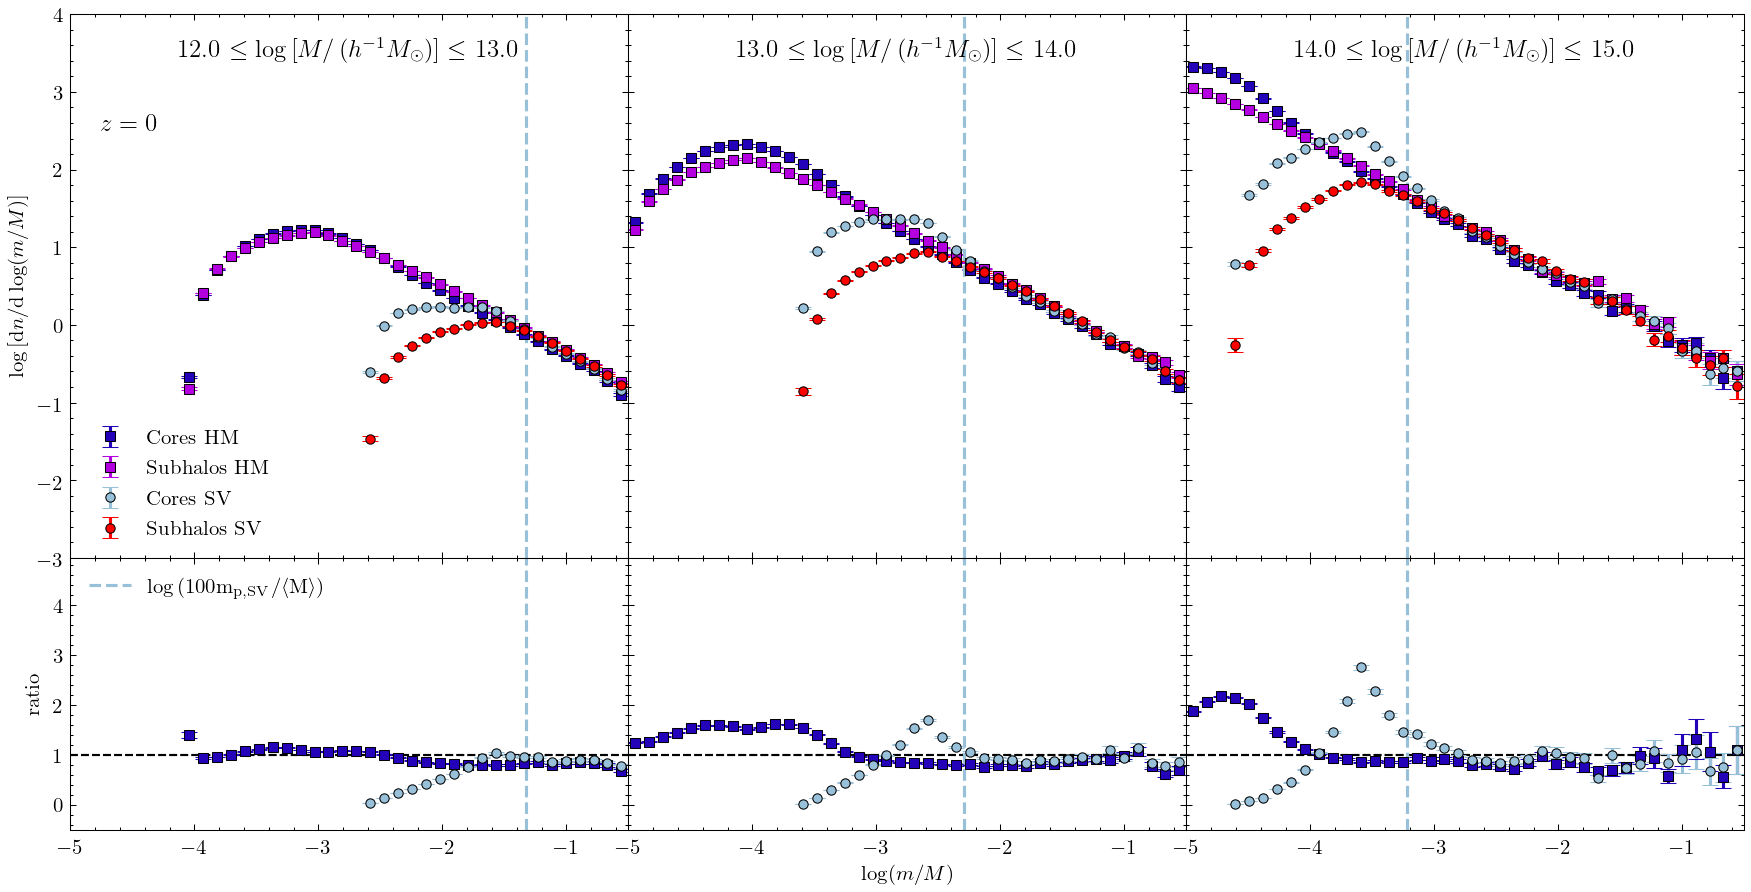

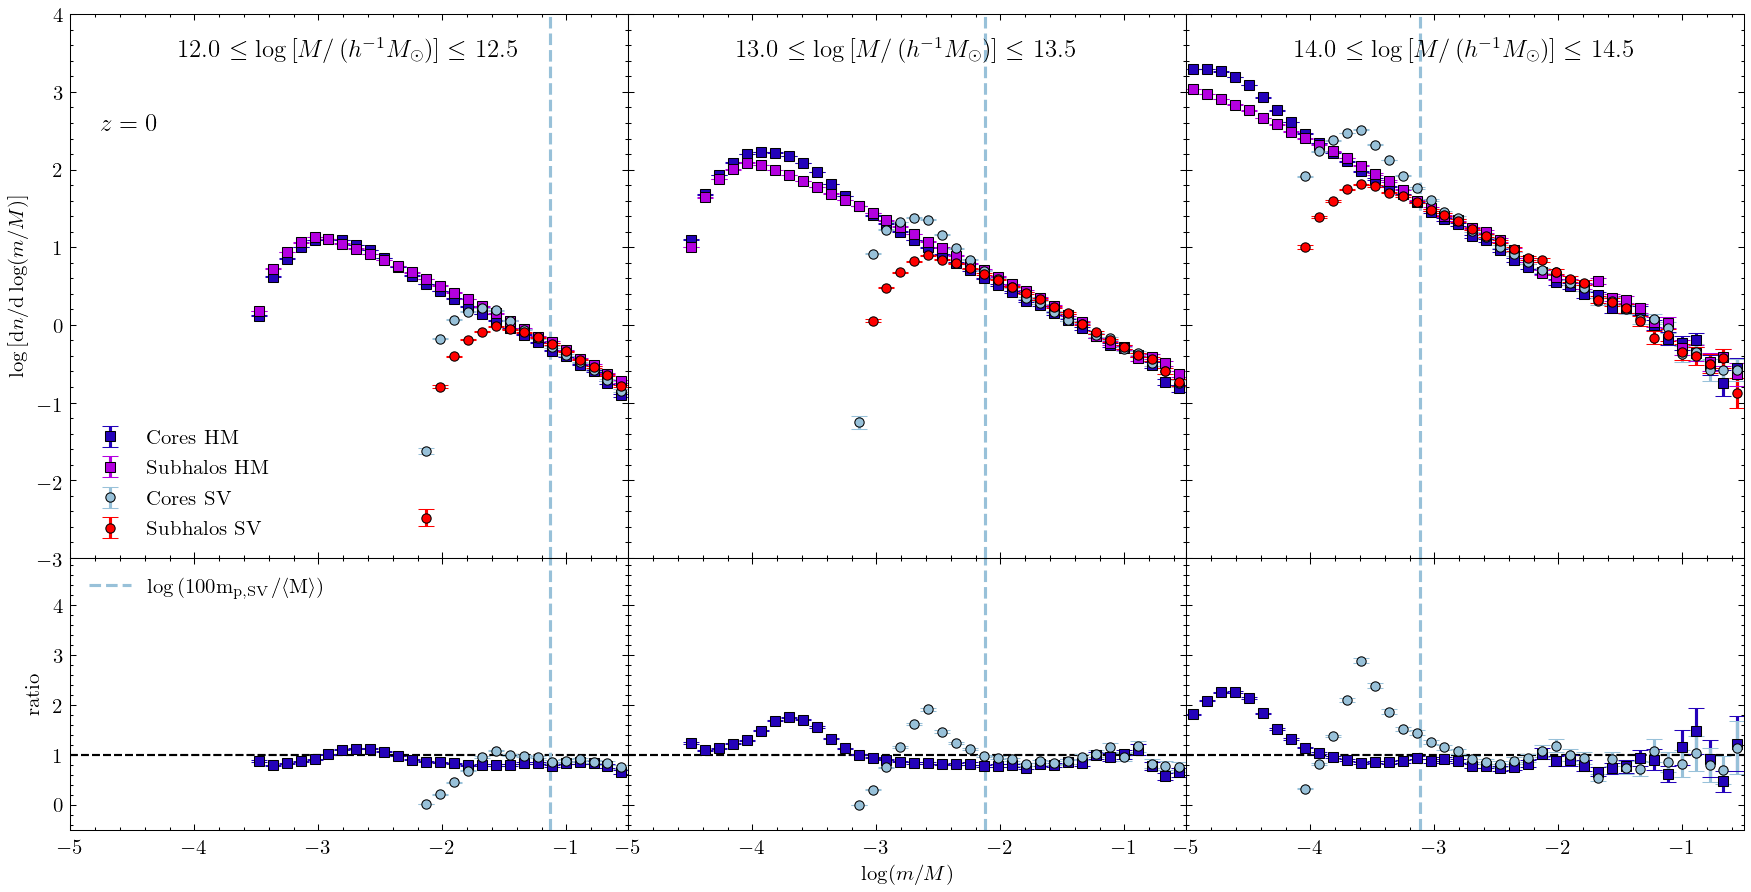

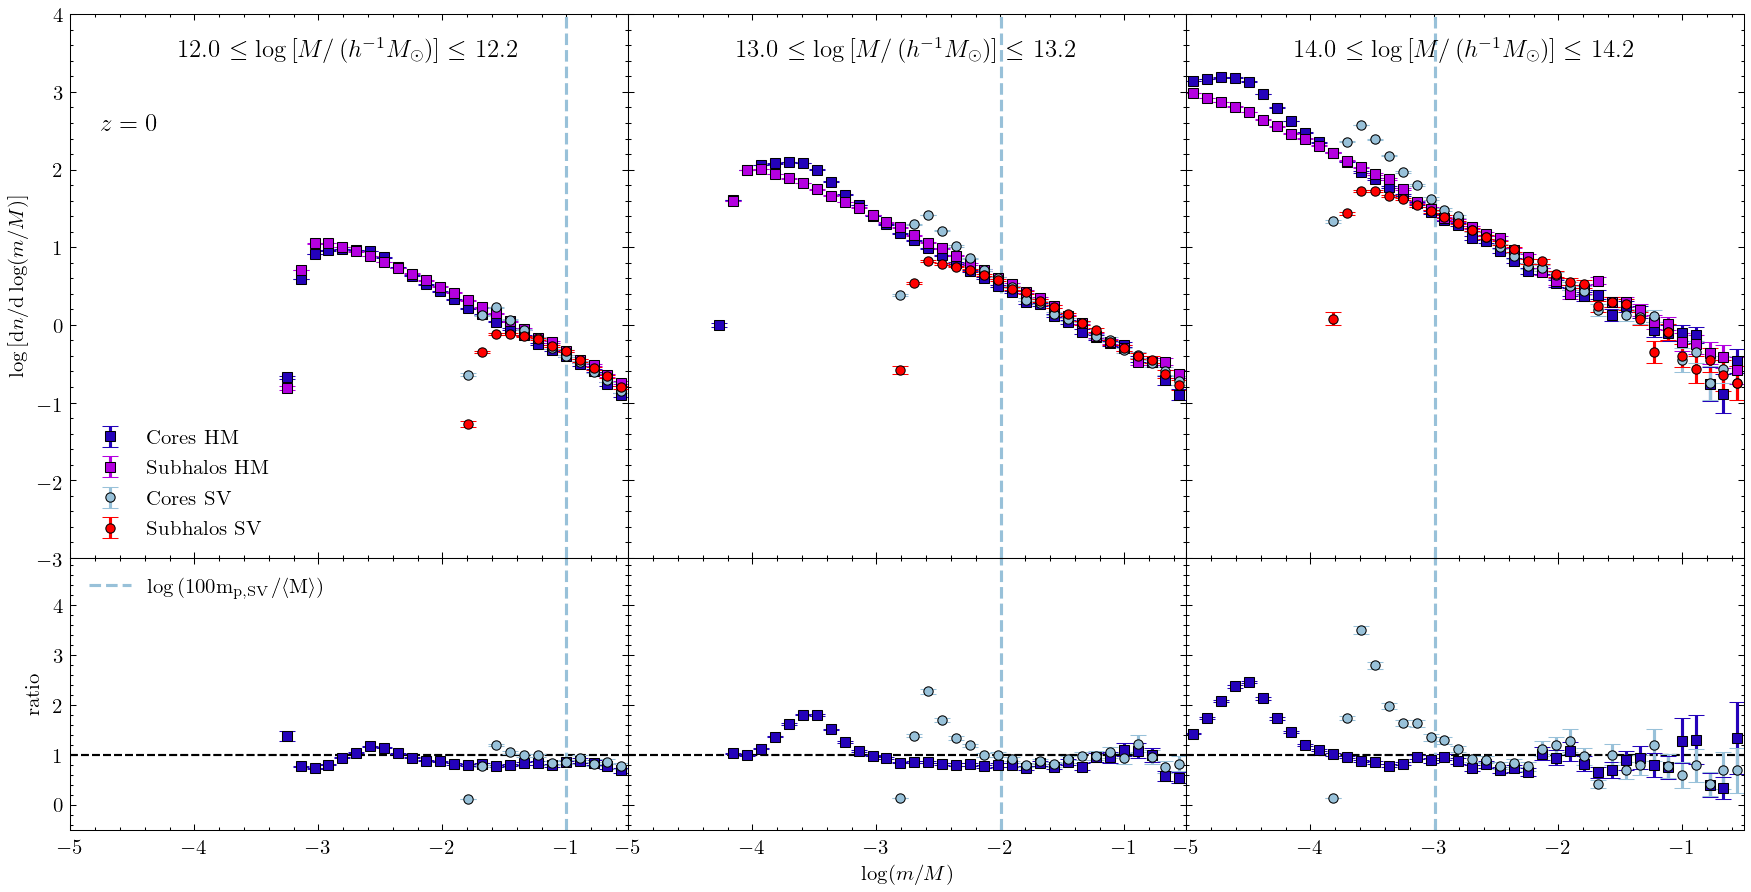

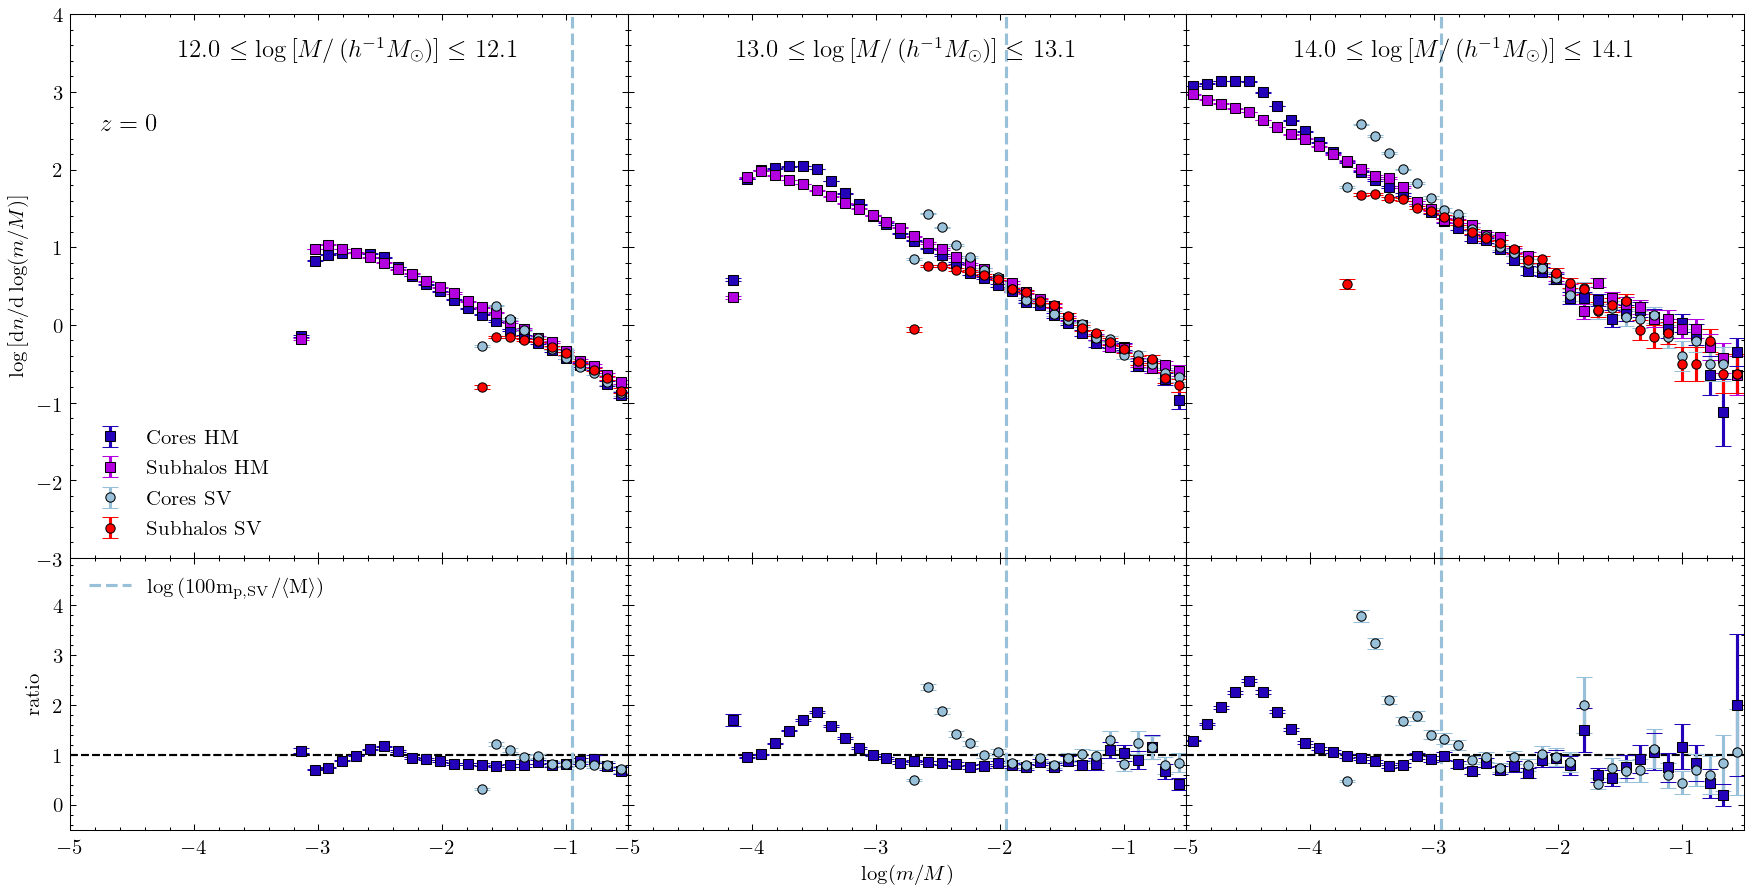

In [72]:
for binwidth in (1.0, 0.5, 0.2, 0.1):
    SHMF_fitting_SVcut['HM'][binwidth] = {}
    SHMF_fitting_SVcut['SV'][binwidth] = {}
    CMF_fitting_SVcut['HM'][binwidth] = {}
    CMF_fitting_SVcut['SV'][binwidth] = {}
    
    SHMF_fitting_HMcut['HM'][binwidth] = {}
    CMF_fitting_HMcut['HM'][binwidth] = {}
    
    HM_SHMF_fitting(cc_HM0, sh_HM0, centrals_mask_HM0, cc_SV0, sh_SV0, centrals_mask_SV0, zlabel='$z=0$', binwidth=binwidth, A=1.0, zeta=0.01)

In [75]:
for binwidth in (1, 0.5, 0.2, 0.1):
    for logM1 in (12, 13, 14):
        print(f'10^{logM1} to 10^{logM1+binwidth}')
        print('Fitting HM', SHMF_fitting_SVcut['HM'][binwidth][logM1])
        print('Fitting SV', SHMF_fitting_SVcut['SV'][binwidth][logM1])
        print(' ')
        print('Fitting Cores (z=0 best fit params) HM', CMF_fitting_SVcut['HM'][binwidth][logM1])
        print('Fitting Cores (z=0 best fit params) SV', CMF_fitting_SVcut['SV'][binwidth][logM1])
        print()
    print('-----------------------------------')

10^12 to 10^13
Fitting HM [0.08309112 0.76423197]
Fitting SV [0.07629559 0.78623058]
 
Fitting Cores (z=0 best fit params) HM [0.0605416  0.81636864]
Fitting Cores (z=0 best fit params) SV [0.06153565 0.84422628]

10^13 to 10^14
Fitting HM [0.07782373 0.8568814 ]
Fitting SV [0.08700919 0.81704186]
 
Fitting Cores (z=0 best fit params) HM [0.07414732 0.81968061]
Fitting Cores (z=0 best fit params) SV [0.06398179 0.88918266]

10^14 to 10^15
Fitting HM [0.10873581 0.8190819 ]
Fitting SV [0.09548604 0.8366412 ]
 
Fitting Cores (z=0 best fit params) HM [0.07507161 0.85430931]
Fitting Cores (z=0 best fit params) SV [0.04766772 0.9632268 ]

-----------------------------------
10^12 to 10^12.5
Fitting HM [0.08338386 0.75127648]
Fitting SV [0.07674123 0.76931204]
 
Fitting Cores (z=0 best fit params) HM [0.06014742 0.80288476]
Fitting Cores (z=0 best fit params) SV [0.06380781 0.80960156]

10^13 to 10^13.5
Fitting HM [0.06911496 0.88503413]
Fitting SV [0.07735147 0.84529242]
 
Fitting Cores (z=

In [76]:
for binwidth in (1, 0.5, 0.2, 0.1):
    for logM1 in (12, 13, 14):
        print(f'10^{logM1} to 10^{logM1+binwidth}')
        print('Fitting HM', SHMF_fitting_HMcut['HM'][binwidth][logM1])
        print('Fitting Cores (z=0 best fit params) HM', CMF_fitting_HMcut['HM'][binwidth][logM1])
        print()
    print('-------------------------------------')

10^12 to 10^13
Fitting HM [0.08710986 0.77590402]
Fitting Cores (z=0 best fit params) HM [0.04971111 0.87284268]

10^13 to 10^14
Fitting HM [0.10627992 0.79562685]
Fitting Cores (z=0 best fit params) HM [0.02362871 1.02032737]

10^14 to 10^15
Fitting HM [0.11228877 0.82818052]
Fitting Cores (z=0 best fit params) HM [0.0067955 1.1589298]

-------------------------------------
10^12 to 10^12.5
Fitting HM [0.08077697 0.78639742]
Fitting Cores (z=0 best fit params) HM [0.0482384  0.87416605]

10^13 to 10^13.5
Fitting HM [0.09836016 0.80306892]
Fitting Cores (z=0 best fit params) HM [0.02688161 1.0002448 ]

10^14 to 10^14.5
Fitting HM [0.10673571 0.83282168]
Fitting Cores (z=0 best fit params) HM [0.00661198 1.16272906]

-------------------------------------
10^12 to 10^12.2
Fitting HM [0.07944091 0.78387333]
Fitting Cores (z=0 best fit params) HM [0.05002982 0.86037738]

10^13 to 10^13.2
Fitting HM [0.09667727 0.80018549]
Fitting Cores (z=0 best fit params) HM [0.02990938 0.98230787]

10^1

# HM and SV host bin width tests

In [31]:
def resolution_binwidth_tests(cc_HM, sh_HM, centrals_mask_HM, cc_SV, sh_SV, centrals_mask_SV, mplot=False, A=None, zeta=None, ccMvar='M', fixedAxis=True, zlabel=None, smallRatioYaxis=False, binwidth=0.5):
    r = (9,13) if mplot else (-5,-0.5)
    bins = 40

    fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='all', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0, 'height_ratios': [2, 1]}, figsize=[4.8*3,4.8*1.5], dpi=150)
    for logM1, ax, axr in zip((12, 13, 14), (ax1, ax2, ax3), (ax4, ax5, ax6)):
        yfid = 'HM'
        yerrfid = None
        M1, M2 = 10**logM1, 10**(logM1+binwidth)
        ax.set_title(r'{} $\le \log \left[ M / \left(h^{{-1}}M_\odot \right) \right] \le$ {}'.format(logM1+0.0, logM1+binwidth), y=0.9)

        for cc, sh, centrals_mask, label, marker, c in zip([cc_HM, cc_SV], [sh_HM, sh_SV], [centrals_mask_HM, centrals_mask_SV], ['HM', 'SV'], ['s', 'o'], ['#2402ba', '#98c1d9']):
            x, y, yerr, yerr_log, nH_cores, Mavg = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=SUBHALOMINMASS[label], returnMavg=True, mplot=mplot, A=A, zeta=zeta, Mvar=ccMvar)
            errorbar(ax, x, y, yerr=yerr_log, label='Cores '+label, marker=marker)

            x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh, Mavg_sh = subhalo_plot(sh, M1, M2, label, bins, r, mlim=SUBHALOMINMASS[label], returnMavg=True, mplot=mplot)
            errorbar(ax, x_sh, y_sh, yerr=yerr_log_sh, label='Subhalos '+label, marker=marker)

            print(reldif(Mavg, Mavg_sh)*100., 'percent relative difference between Mavg_cores and Mavh_sh')

            print('')
            if ccMvar!='Mtn':
                assert np.abs(nH_cores- nH_sh)<2

            if yfid == label:
                yfid = y_sh
                yerrfid = yerr_sh

            errorbar(axr, x, 10**(y-yfid), yerr=nratioerr(10**y, yerr, 10**yfid, yerrfid), marker=marker, c=c, zerocut=True)
            axr.axhline(1, c='k',ls='--', lw=1, zorder=-1)

            #ax.axvline( np.log10(SUBHALOMINMASS[label]/np.max(sh['M'][bin_mask_sh])), label=r'$\log \mathrm{m_{sh,min}/M_{max}}$ '+label, c='k' )
            if mplot:
                ax.axvline(  np.log10(100*PARTICLEMASS[label]), ymax=1., ls='--', c=c )
                axr.axvline( np.log10(100*PARTICLEMASS[label]), ls='--', label=r'$\log \left(\mathrm{100m_{p,'+label+ r'}}\right)$', c=c )
            elif label=='SV':
                # old Mavg_sh = np.mean(sh['M'][bin_mask_sh])
                print('SV lim:', np.log10(100*PARTICLEMASS[label]/Mavg_sh))
                ax.axvline(  np.log10(100*PARTICLEMASS[label]/Mavg_sh), ymax=1., ls='--', c=c )
                axr.axvline( np.log10(100*PARTICLEMASS[label]/Mavg_sh), ls='--', label=r'$\log \left(\mathrm{100m_{p,'+label+ r'}/\langle M \rangle}\right)$', c=c )
        if mplot and fixedAxis:
            ax.set_ylim(-3,3.6) #CHANGE
            axr.set_ylim(-1,3.95) #CHANGE
            ax.set_xlim(9,12.95)
        elif fixedAxis: #finalized for res0,1 plots
            ax.set_ylim(-3,4)
            axr.set_ylim(-0.5,4.95)
            ax.set_xlim(-5,-0.5)

        if smallRatioYaxis:
            # axr.axhline(0.0)
            # axr.axhline(1.95)
            axr.set_ylim(0.0,1.95)

    ax1.legend(loc=3)
    ax4.legend(loc=2)
    if mplot:
        ax5.set_xlabel(r'$\log(m)$')
        ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m) \right]$')
    else:
        ax5.set_xlabel(r'$\log(m/M)$')
        ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
    ax4.set_ylabel(r'ratio')

    if zlabel:
        ax1.text(r[0]+0.25,2.5,zlabel, fontsize=12)

HM nH cores 42605


/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


Mavg (cores centrals): 2.4879156e+12
HM nH_sh 42605
HM number of subhalos in bin 1001198
Mavg (sh centrals): 2.4879146e+12
4.214677551352421e-05 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 44674


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in subtract
/home/isultan/projects/itk/itk.py:194: RuntimeWarning: invalid value encountered in true_divide
  return np.sqrt( (nerr/nfid)**2 + (n*nfiderr/nfid**2)**2 )
/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Mavg (cores centrals): 2.4829734e+12
SV nH_sh 44674
SV number of subhalos in bin 70868
Mavg (sh centrals): 2.482973e+12
2.111533077535178e-05 percent relative difference between Mavg_cores and Mavh_sh

HM nH cores 2767
Mavg (cores centrals): 2.1095965e+13
HM nH_sh 2767
HM number of subhalos in bin 459201
Mavg (sh centrals): 2.109596e+13
1.9882022069243318e-05 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 2843
Mavg (cores centrals): 2.131195e+13
SV nH_sh 2843
SV number of subhalos in bin 31122
Mavg (sh centrals): 2.131195e+13
0.0 percent relative difference between Mavg_cores and Mavh_sh

HM nH cores 22
Mavg (cores centrals): 1.7225389e+14
HM nH_sh 22
HM number of subhalos in bin 25570
Mavg (sh centrals): 1.7225387e+14
9.7398182861582e-06 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 37
Mavg (cores centrals): 1.4895695e+14
SV nH_sh 37
SV number of subhalos in bin 2341


/home/isultan/projects/itk/itk.py:194: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt( (nerr/nfid)**2 + (n*nfiderr/nfid**2)**2 )


Mavg (sh centrals): 1.4895695e+14
0.0 percent relative difference between Mavg_cores and Mavh_sh

HM nH cores 33020


/home/isultan/projects/itk/itk.py:107: RuntimeWarning: invalid value encountered in true_divide
  ebars_log = 1./np.log(10) * np.sqrt(cnts)/cnts
/home/isultan/projects/itk/itk.py:123: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


Mavg (cores centrals): 1.6786361e+12
HM nH_sh 33020
HM number of subhalos in bin 553422
Mavg (sh centrals): 1.6786354e+12
3.90412286305883e-05 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 34592


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in subtract
/home/isultan/projects/itk/itk.py:194: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt( (nerr/nfid)**2 + (n*nfiderr/nfid**2)**2 )
/home/isultan/projects/itk/itk.py:194: RuntimeWarning: invalid value encountered in true_divide
  return np.sqrt( (nerr/nfid)**2 + (n*nfiderr/nfid**2)**2 )
/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Mavg (cores centrals): 1.6771427e+12
SV nH_sh 34592
SV number of subhalos in bin 38565
Mavg (sh centrals): 1.6771429e+12
1.5630392485407467e-05 percent relative difference between Mavg_cores and Mavh_sh

HM nH cores 2368
Mavg (cores centrals): 1.6394571e+13
HM nH_sh 2368
HM number of subhalos in bin 312172
Mavg (sh centrals): 1.6394567e+13
2.558349721162266e-05 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 2418
Mavg (cores centrals): 1.6287099e+13
SV nH_sh 2418
SV number of subhalos in bin 21031
Mavg (sh centrals): 1.62871e+13
6.438077157521978e-06 percent relative difference between Mavg_cores and Mavh_sh

HM nH cores 21
Mavg (cores centrals): 1.6244637e+14
HM nH_sh 21
HM number of subhalos in bin 23227
Mavg (sh centrals): 1.6244637e+14
0.0 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 36
Mavg (cores centrals): 1.4413435e+14
SV nH_sh 36
SV number of subhalos in bin 2171
Mavg (sh centrals): 1.4413439e+14
2.3279965564274937e-05 percent

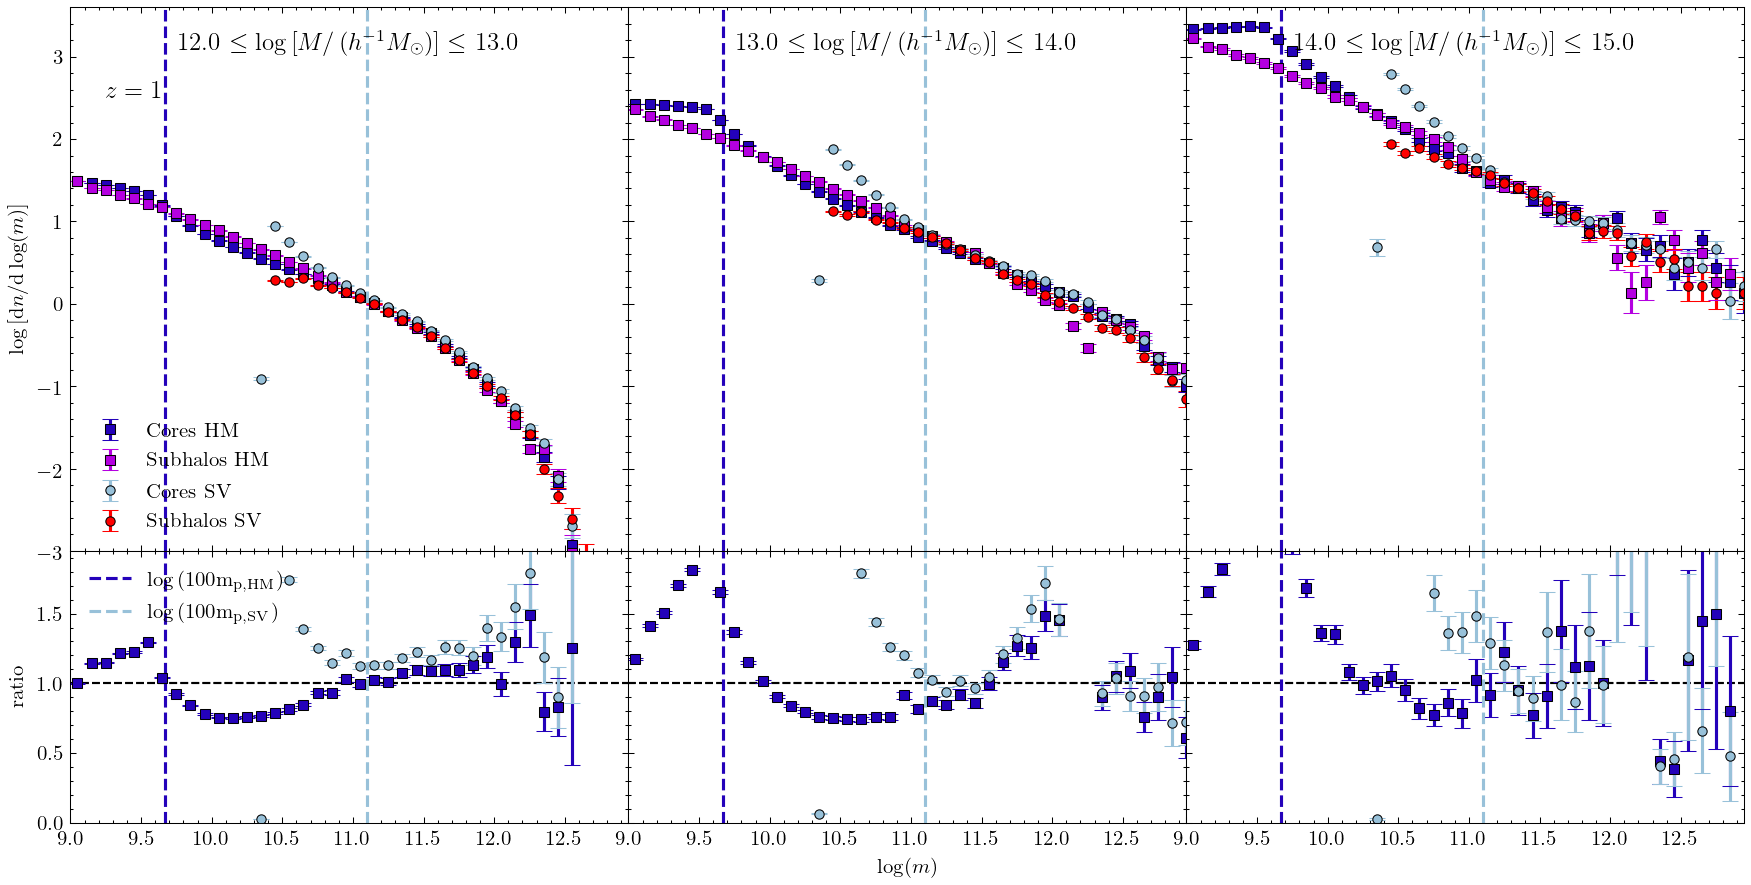

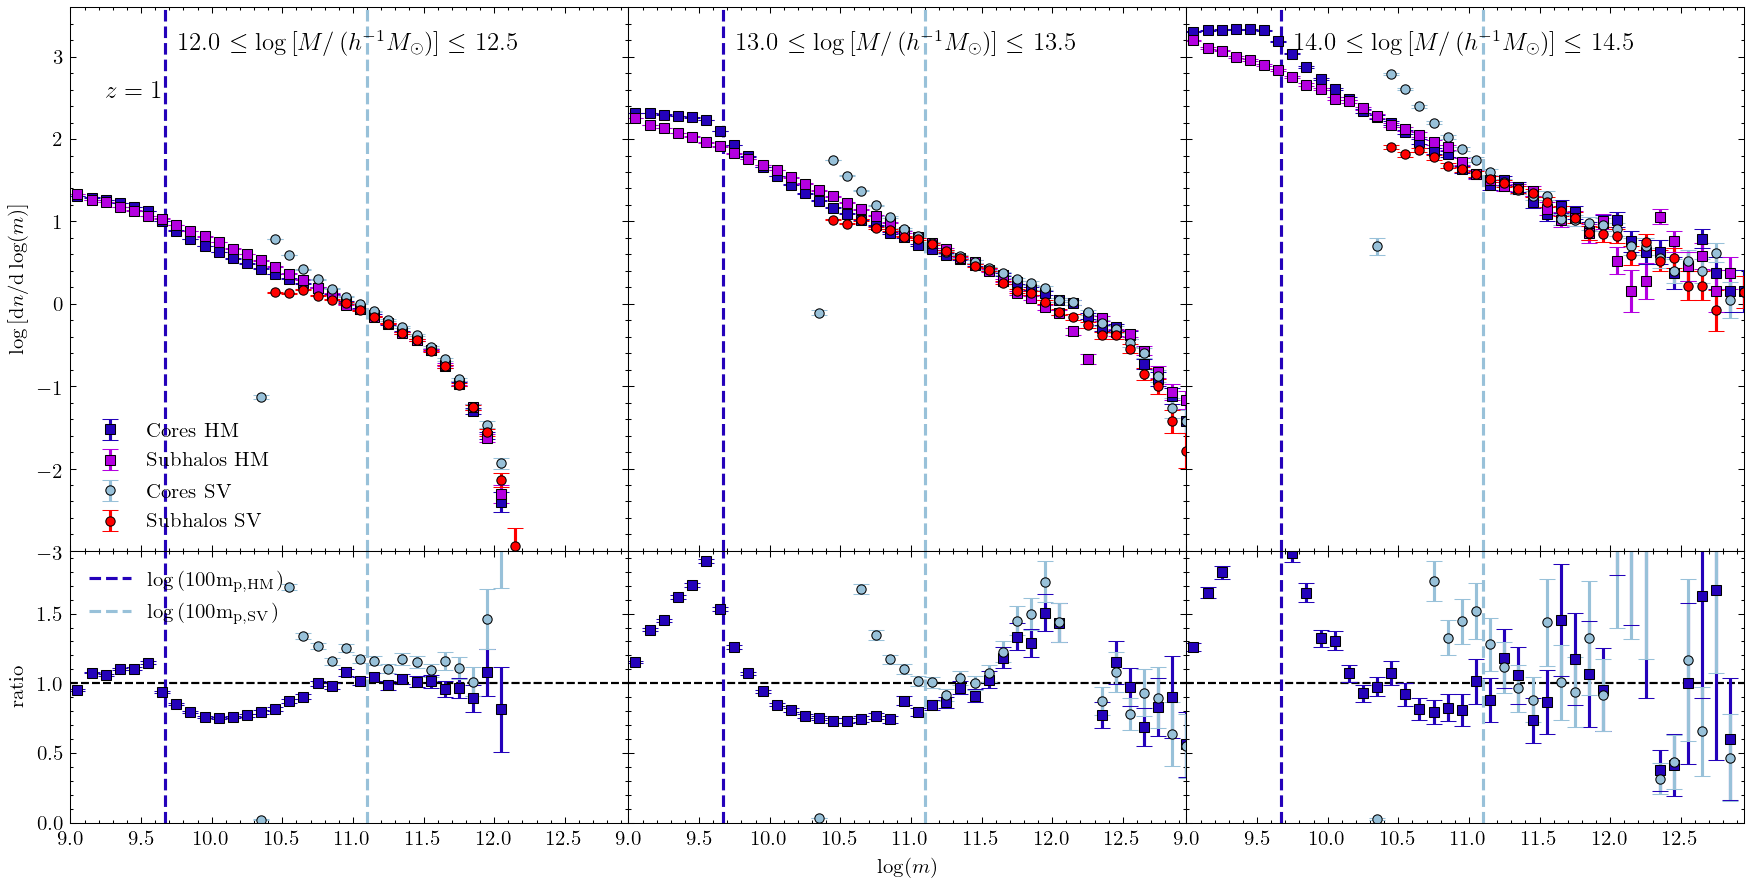

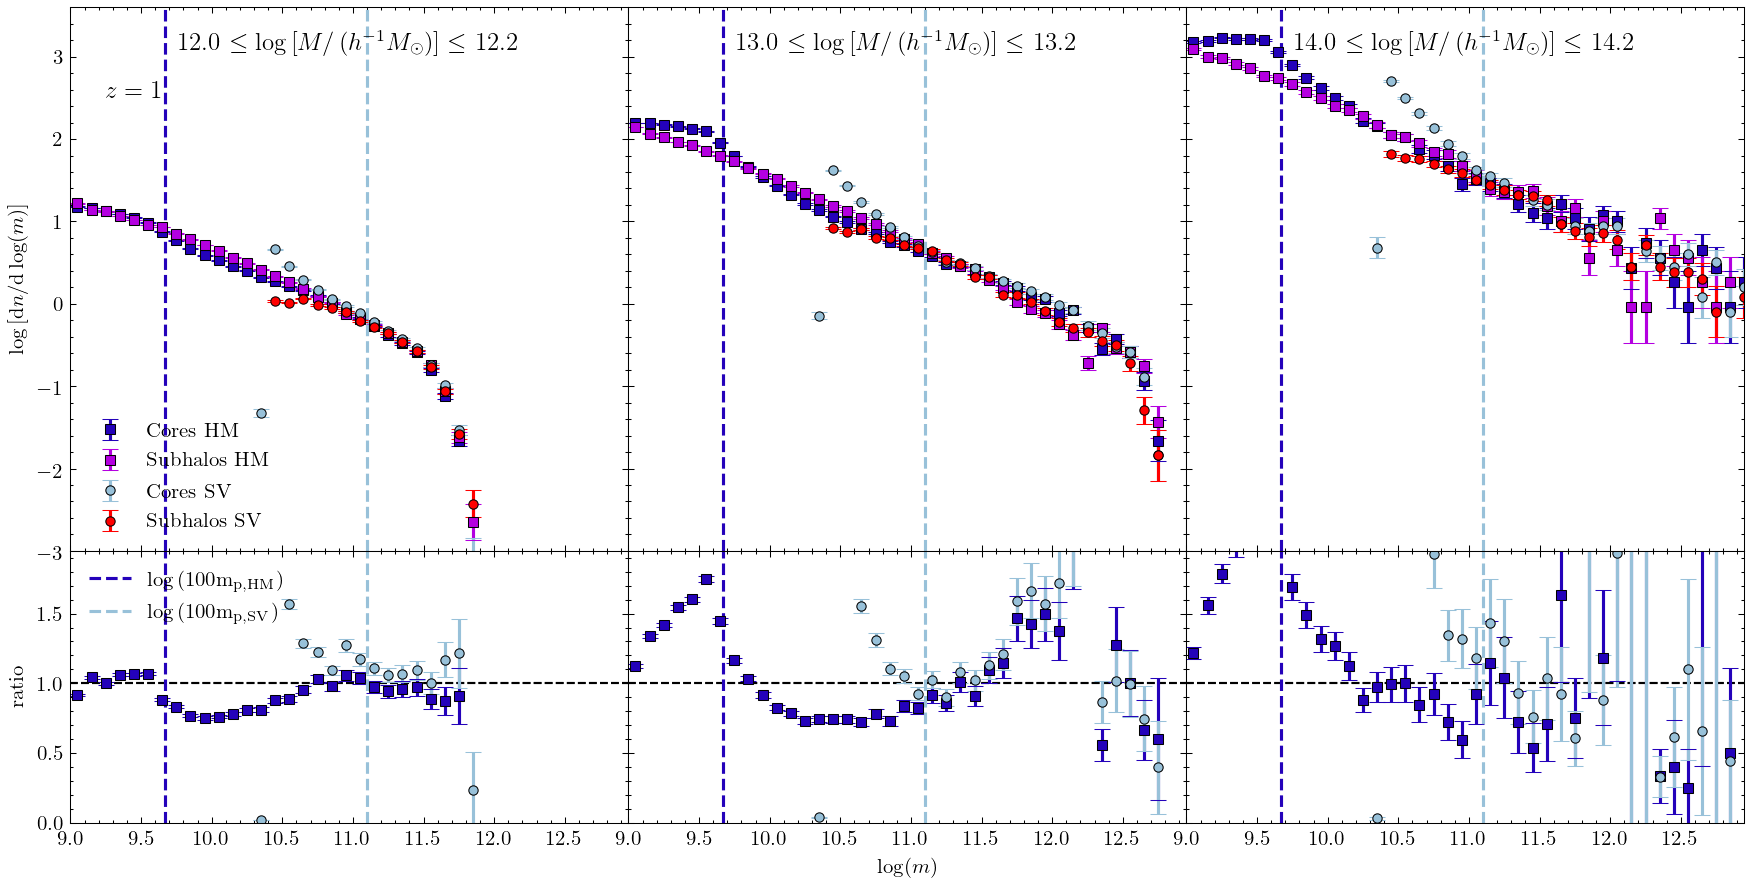

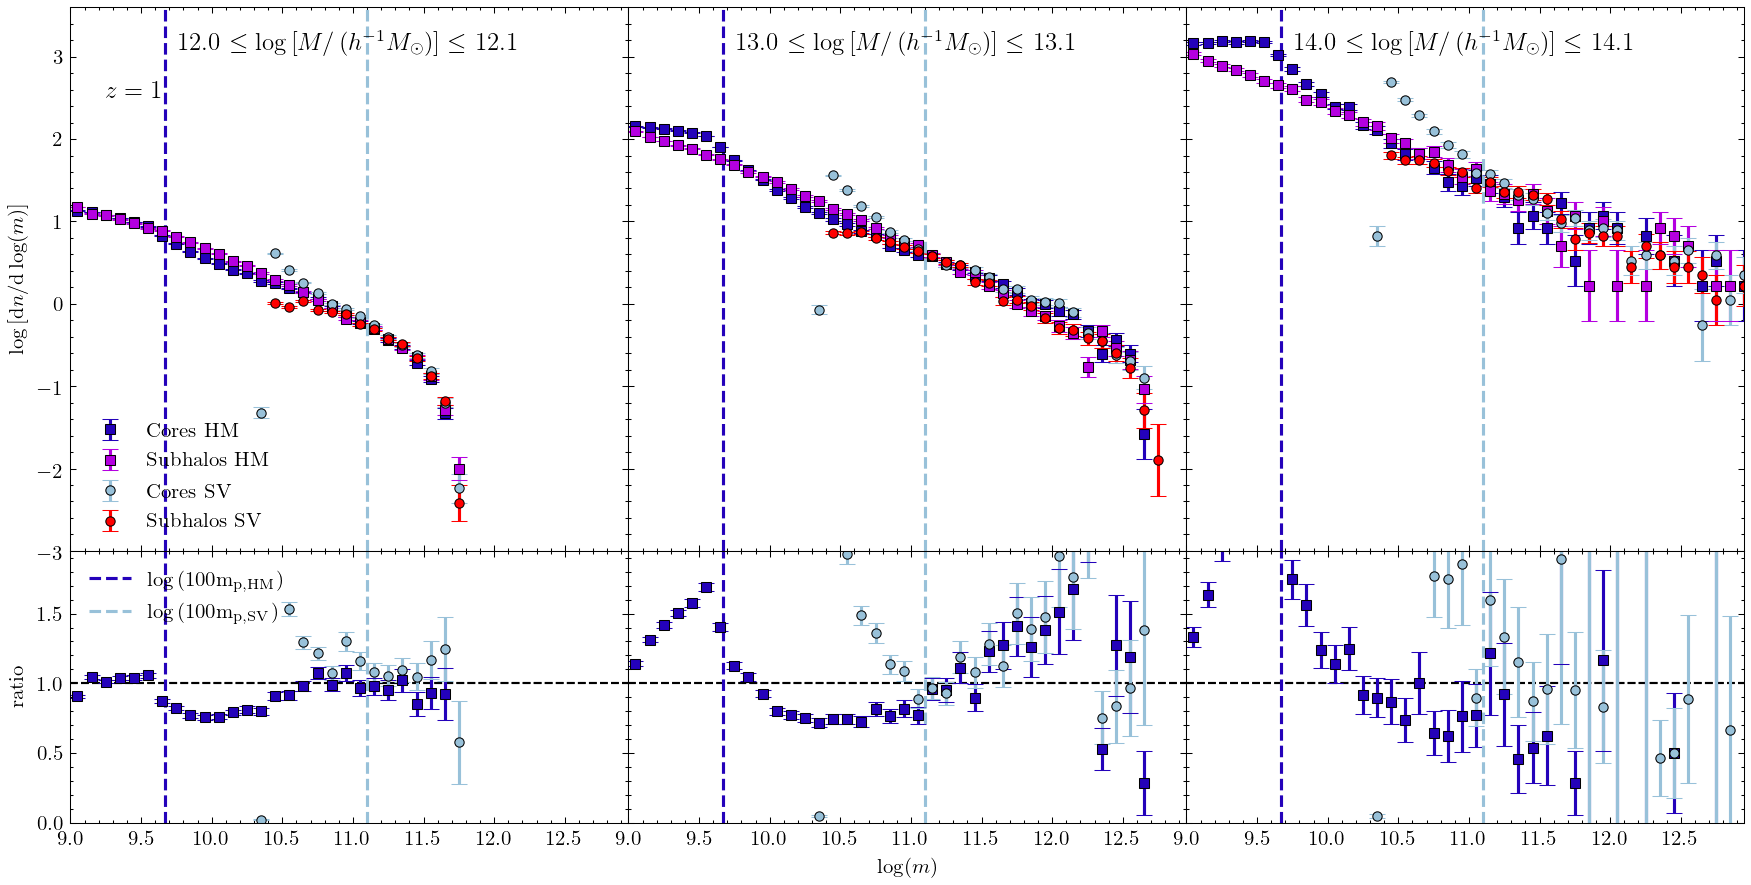

In [33]:
for binwidth in (1.0, 0.5, 0.2, 0.1):
    resolution_binwidth_tests(cc_HM1, sh_HM1, centrals_mask_HM1, cc_SV1, sh_SV1, centrals_mask_SV1, zlabel='$z=1$', smallRatioYaxis=True, mplot=True, binwidth=binwidth)
    plt.savefig(f'Paper2Figs/binwidth_mplot/z1_{binwidth}.pdf')

HM nH cores 53238
Mavg (cores centrals): 2.6449145e+12
HM nH_sh 53238
HM number of subhalos in bin 1073761
Mavg (sh centrals): 2.6449126e+12
6.937875487732647e-05 percent relative difference between Mavg_cores and Mavh_sh



/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in subtract


SV nH cores 54914
Mavg (cores centrals): 2.6633054e+12
SV nH_sh 54914
SV number of subhalos in bin 70951
Mavg (sh centrals): 2.6633052e+12
9.842806443967266e-06 percent relative difference between Mavg_cores and Mavh_sh



/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


HM nH cores 6134
Mavg (cores centrals): 2.500933e+13
HM nH_sh 6134
HM number of subhalos in bin 1049507
Mavg (sh centrals): 2.50093e+13
0.00011739676694335127 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 6197
Mavg (cores centrals): 2.4771652e+13
SV nH_sh 6197
SV number of subhalos in bin 65345
Mavg (sh centrals): 2.4771652e+13
0.0 percent relative difference between Mavg_cores and Mavh_sh

HM nH cores 385
Mavg (cores centrals): 1.9261846e+14
HM nH_sh 385
HM number of subhalos in bin 485152
Mavg (sh centrals): 1.9261833e+14
6.968063882512868e-05 percent relative difference between Mavg_cores and Mavh_sh

SV nH cores 384
Mavg (cores centrals): 2.0730478e+14
SV nH_sh 384
SV number of subhalos in bin 29871
Mavg (sh centrals): 2.073048e+14
8.093019220596928e-06 percent relative difference between Mavg_cores and Mavh_sh

HM nH cores 39505
Mavg (cores centrals): 1.6998947e+12
HM nH_sh 39505
HM number of subhalos in bin 532088
Mavg (sh centrals): 1.6998933e+12
7.7105

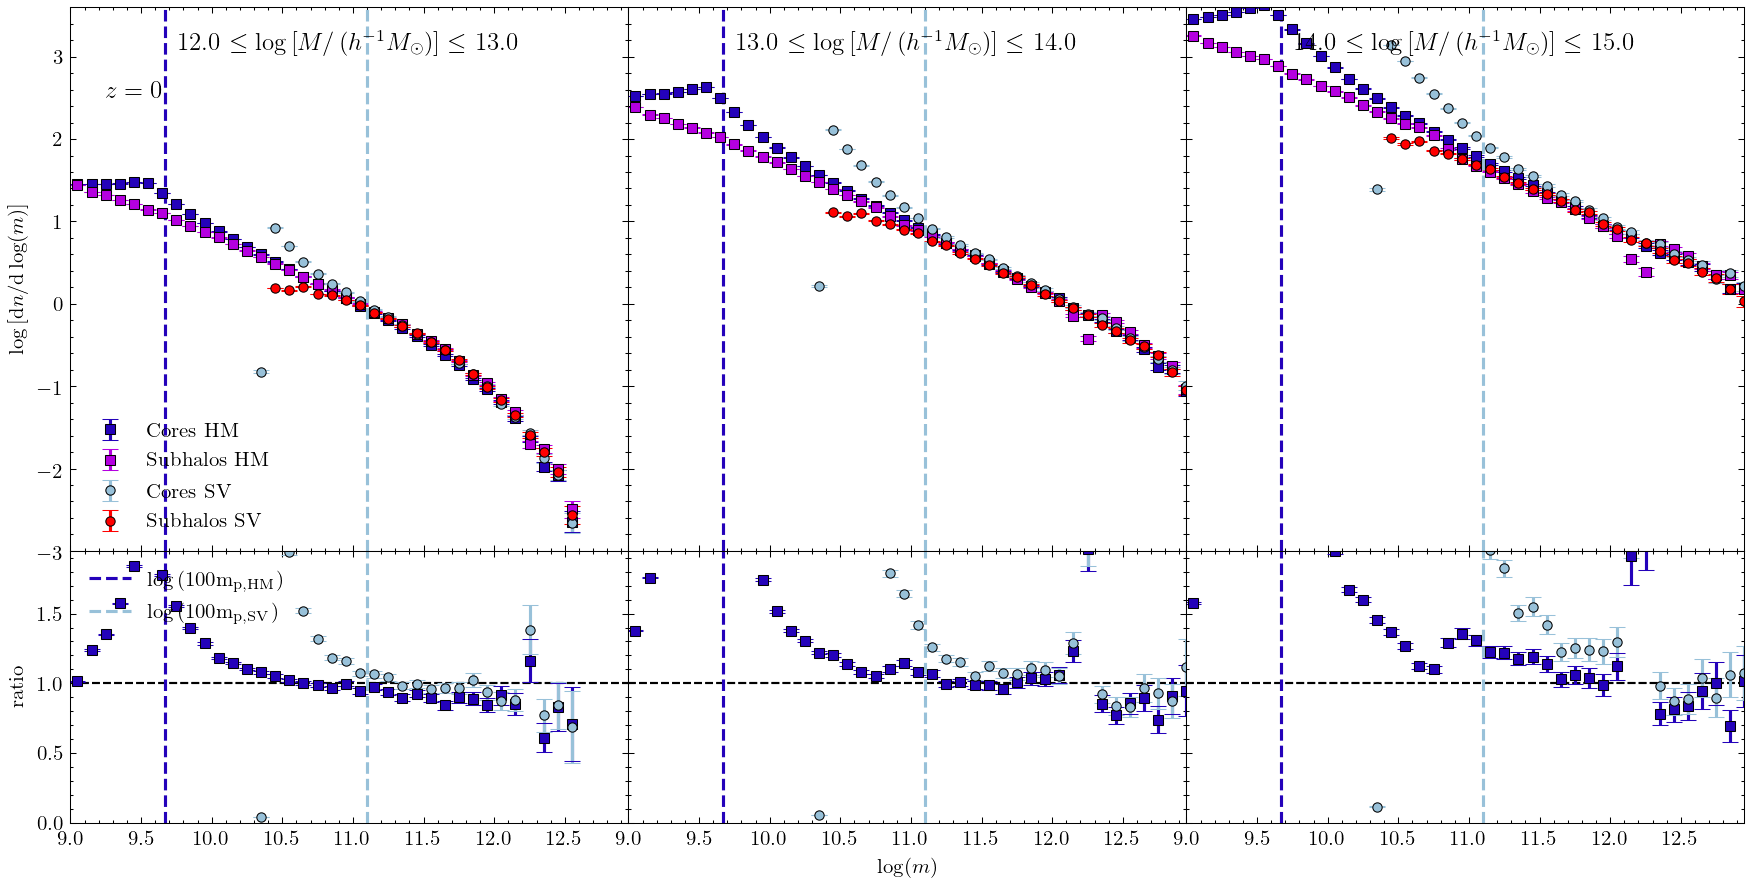

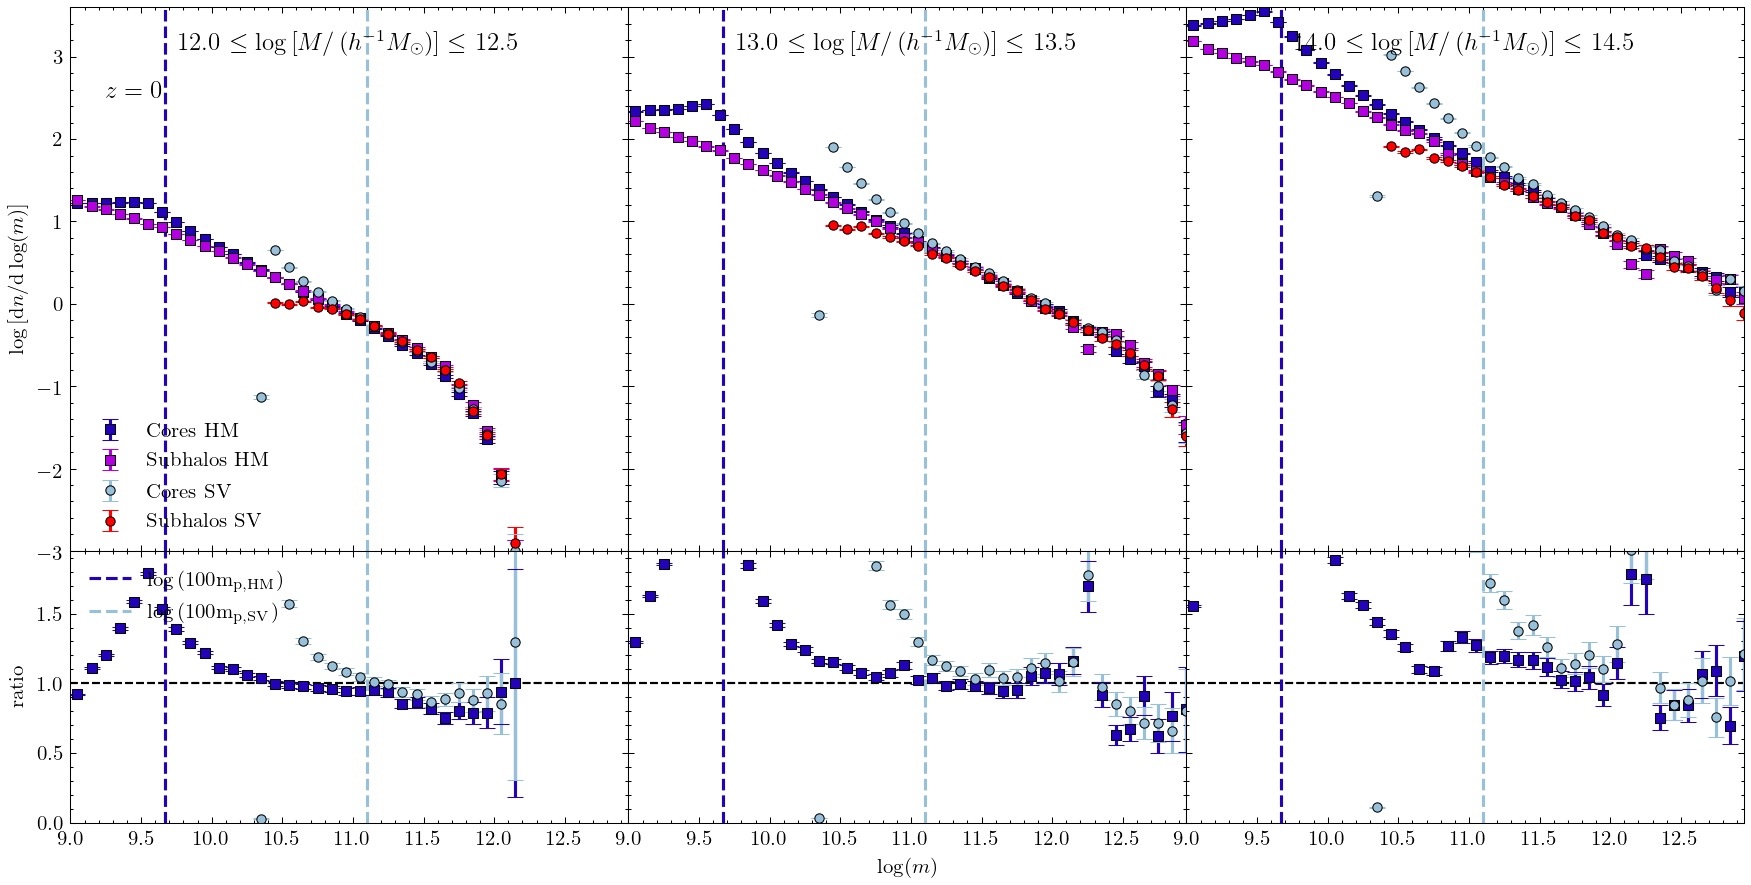

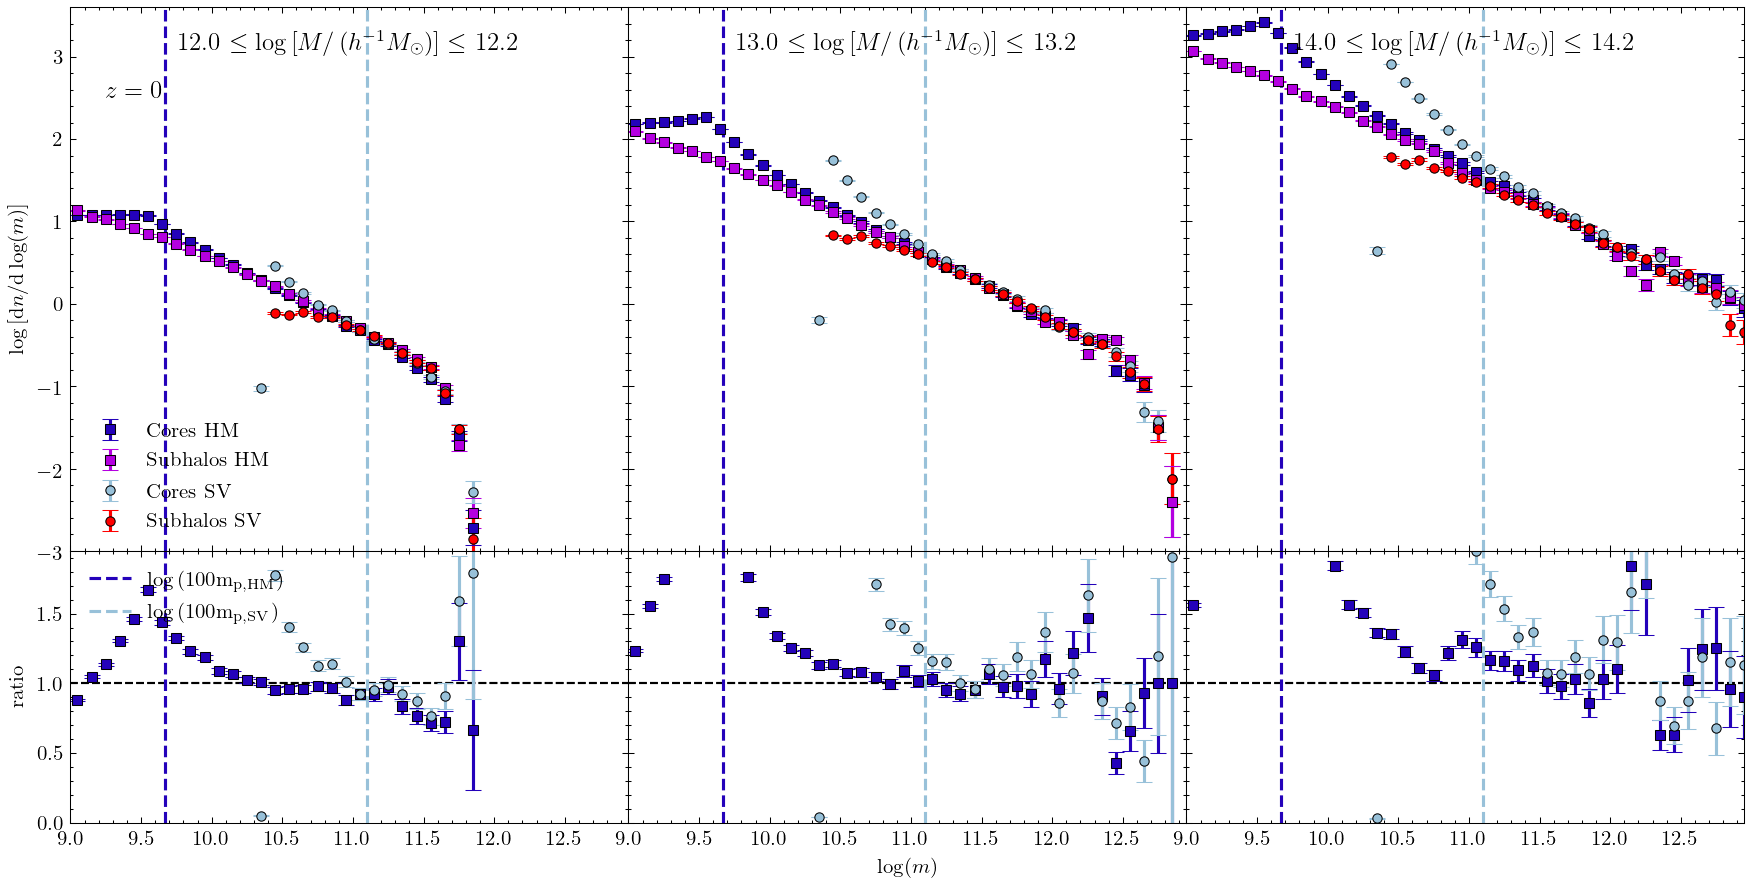

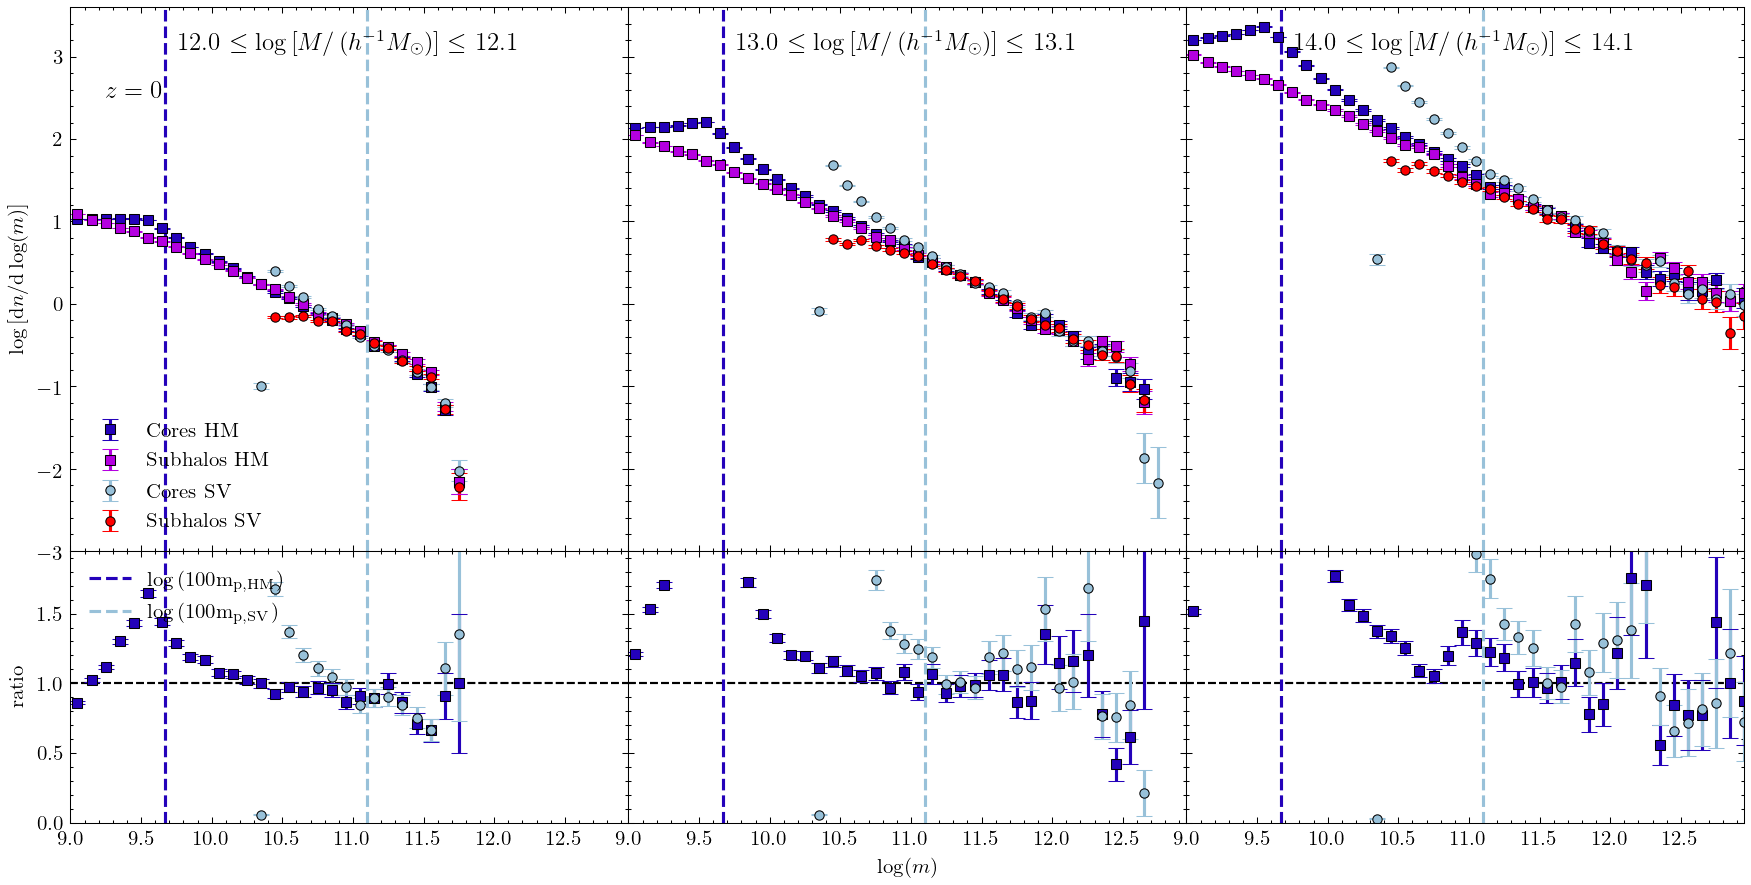

In [34]:
for binwidth in (1.0, 0.5, 0.2, 0.1):
    resolution_binwidth_tests(cc_HM0, sh_HM0, centrals_mask_HM0, cc_SV0, sh_SV0, centrals_mask_SV0, zlabel='$z=0$', smallRatioYaxis=True, mplot=True, binwidth=binwidth)
    plt.savefig(f'Paper2Figs/binwidth_mplot/z0_{binwidth}.pdf')